In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import pylab
import scipy.io
from scipy.signal import savgol_filter
from scipy import interpolate
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}',r'\sansmath']
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here
repo_data = "/Users/Ali/Dropbox/beams_and_flow_FSI/data"
figPath = "/Users/Ali/Dropbox/beams_and_flow_FSI/figures"
tick_font_size = 16

\begin{gather}
b = \text{inplane plate depth} & w = \text{plate thickness} & h = \text{plate height} \\[2ex]
h\angle = \text{bent plate height} & L = \text{Channel height} & \text{Force:0=Drag force}(F_D)\\[2ex]
\text{Force:1=Lift force}(F_L) & \text{p=Pressure}(p) & \text{rescaled_Ux=Average velocity}(U_{x,\text{avg}})\\[2ex]
\text{rescaled_Uy=Average velocity}(U_{y,\text{avg}}) & \text{Point Coordinates:0=tip location x}(u_x) & \text{Point Coordinates:1=tip location y}(u_y)\\[2ex]
F_{D} = b\int_{0}^{h}P(l)\,\cos(\theta(l))\cdot\hat{n}\,dl & F_{L} = b\int_{0}^{h}P(l)\,\sin(\theta(l))\cdot\hat{n}\,dl & R = \frac{F_D}{F_{D,\,\text{rigid}}}\\[2ex]
C_D = \frac{2F_{{d}}}{\rho\,U^2_{x,\text{avg}}\,A} & C_L = \frac{2F_{{l}}}{\rho\,U^2_{y,\text{avg}}\,A} & C_a = \frac{12F_D}{bhE}\\[2ex]
Z = \frac{F_D}{U_{x,\text{avg}}} &\tilde{Z} = \frac{Z-Z_{\infty}}{Z_0-Z_{\infty}}  & Z_{\infty}=\text{strongly deformed}\\[2ex]
Z_1 = \frac{\eta}{L-h\angle} &\tilde{Z_1} = \frac{Z_1-Z_{1,\infty}}{Z_{1,0}-Z_{1,\infty}}  & Z_{1,0}=\text{rigid}=\frac{\eta}{L-h}\\[2ex]
\tilde{v}=\frac{4\eta h^2U_{x,\text{avg}}}{EH}\bigg(1-\frac{h}{L}\bigg)^{-\frac{3}{2}} & V=\text{Vogel number}&\\
\text{Alvarado, low }Re:F_d\propto (U_{x,\text{avg}})^{1+V} &\text{de Langre, high }Re:F_d\propto (U_{x,\text{avg}})^{2+V} &\\[2ex]
\text{Alvarado, low }Re:Z\propto (U_{x,\text{avg}})^{V} &\text{de Langre, high }Re:R\propto (U_{x,\text{avg}})^{V}&\\[2ex]
\text{Alvarado, low }Re:V=\frac{\partial\log(Z/Z_{\infty})}{\partial\log\tilde{v}} &\text{de Langre, high }Re:V=2\frac{\partial\log R}{\partial\log C_a}&
\end{gather}

In [3]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def get_data(E,h,dataPath = repo_data):
    filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}".format(E,h))


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

"""
minimal example for smooth:

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.8
plot(x, y,'o')
plot(x, smooth(y,3), 'r-', lw=2)
plot(x, smooth(y,19), 'g-', lw=2)
"""

"\nminimal example for smooth:\n\nx = np.linspace(0,2*np.pi,100)\ny = np.sin(x) + np.random.random(100) * 0.8\nplot(x, y,'o')\nplot(x, smooth(y,3), 'r-', lw=2)\nplot(x, smooth(y,19), 'g-', lw=2)\n"

## E=1e6 MPa,  h=0.8 m

In [4]:
from scipy.signal import savgol_filter
dataPath = repo_data
rho=1000
E=6
h=8
L=1.2
w=0.05
b = 0.5
filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}.csv".format(E,h))
temporal_filePath=os.path.join(dataPath,"temporalVel_E_1e{0:d}_h_0.{1:d}_N.csv".format(E,h))
E_modulus = 10**E
h /=10
df = pd.read_csv(filePath)
df_temporal = pd.read_csv(temporal_filePath,header=None)
for column_name in ['Force:2','Normals:2','vtkValidPointMask','D:2','Point Coordinates:2']:
    df.drop(column_name, axis=1, inplace=True)
df.columns

Index(['p', 'Force:0', 'Force:1', 'Normals:0', 'Normals:1', 'U:0', 'U:1',
       'U:2', 'Area', 'Time', 'Point Coordinates:0', 'Point Coordinates:1',
       'D:0', 'D:1', 'rescaled_Ux', 'rescaled_Uy', 'Mag_normals', 'costheta'],
      dtype='object')

In [5]:
A = df['Area'][0]
start_id = np.where(df['Point Coordinates:0']>4.02)[0][0]
lmin=256
df_4_rigid=df.iloc[:lmin,:]
df_4_rigid_temporal=df_temporal.iloc[:lmin,:]
#skip = 20
df=df.iloc[start_id:lmin,:]
df_temporal=df_temporal.iloc[start_id:lmin,:]
df_4_rigid['local_velocity'] = df_4_rigid_temporal.iloc[:,0]
df_4_rigid['Z_fd_over_vloc'] = (1/A)*df_4_rigid['Force:0']/df_4_rigid['local_velocity']
df_4_rigid['fd_smooth'] = savgol_filter(df_4_rigid['Force:0'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['v_loc_smooth'] = savgol_filter(df_4_rigid['local_velocity'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['Cy'] = df_4_rigid['v_loc_smooth']**2*1000/E_modulus
df_4_rigid['Cys'] = df_4_rigid['Cy']*(h/w)**3
df_4_rigid['Cygap'] = df_4_rigid['Cy']*(df_4_rigid['Point Coordinates:1']/w)**3
df['Fdx'] = df['Force:0']*rho
df['Fdy'] = df['Force:1']*rho
df['gap'] = L-df['Point Coordinates:1']
df['Z_fd_over_vavg'] = (1/A)*df['Force:0']/df['rescaled_Ux']
df['local_velocity'] = df_temporal.iloc[:,0]
df['Z_fd_over_vloc'] = (1/A)*df['Force:0']/df['local_velocity']
#df['Z_fd_over_vavg'].fillna(0.001,inplace=True)
df['Z_eta_over_gap'] = 1/df['gap']
#df['Z_eta_over_gap'].fillna(0.001,inplace=True)
z_inf_eta_over_gap = df['Z_eta_over_gap'].values[-1]
z_inf_eta_over_gap_L = L
z_inf_fd_over_vavg = df['Z_fd_over_vavg'].values[-1]
z_inf_fd_over_vloc = df['Z_fd_over_vloc'].values[-1]
z_0_eta_over_gap=1/(L-h)
df['Z_tilde_gap']=(df['Z_eta_over_gap']-z_inf_eta_over_gap)/(z_0_eta_over_gap-z_inf_eta_over_gap)
df['Z_tilde_gap_L']=(df['Z_eta_over_gap']-z_inf_eta_over_gap_L)/(z_0_eta_over_gap-z_inf_eta_over_gap_L)
df['v_tilde_avg']=df['rescaled_Ux']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_loc_smooth'] = savgol_filter(df['local_velocity'], 51, 3) # window size 51, polynomial order 3
df['fd_smooth'] = savgol_filter(df['Force:0'], 51, 3) # window size 51, polynomial order 3
df['drag_coeff'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['drag_inst'] = df['fd_smooth']/df['v_loc_smooth']**2/b/(df['Point Coordinates:1'])
df['v_tilde_loc_smooth']=df['v_loc_smooth']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_final']=df['v_loc_smooth']/np.sqrt(E_modulus*(1-(h/L)))
dx = np.diff(np.log(df['v_loc_smooth']))
dy = np.diff(np.log(df['fd_smooth']))
dydx=dy/dx
df['derY']=df['v_loc_smooth']*0
df['derY'].values[1:]=dydx
df['yHat'] = savgol_filter(df['derY'], 51, 3) # window size 51, polynomial order 3

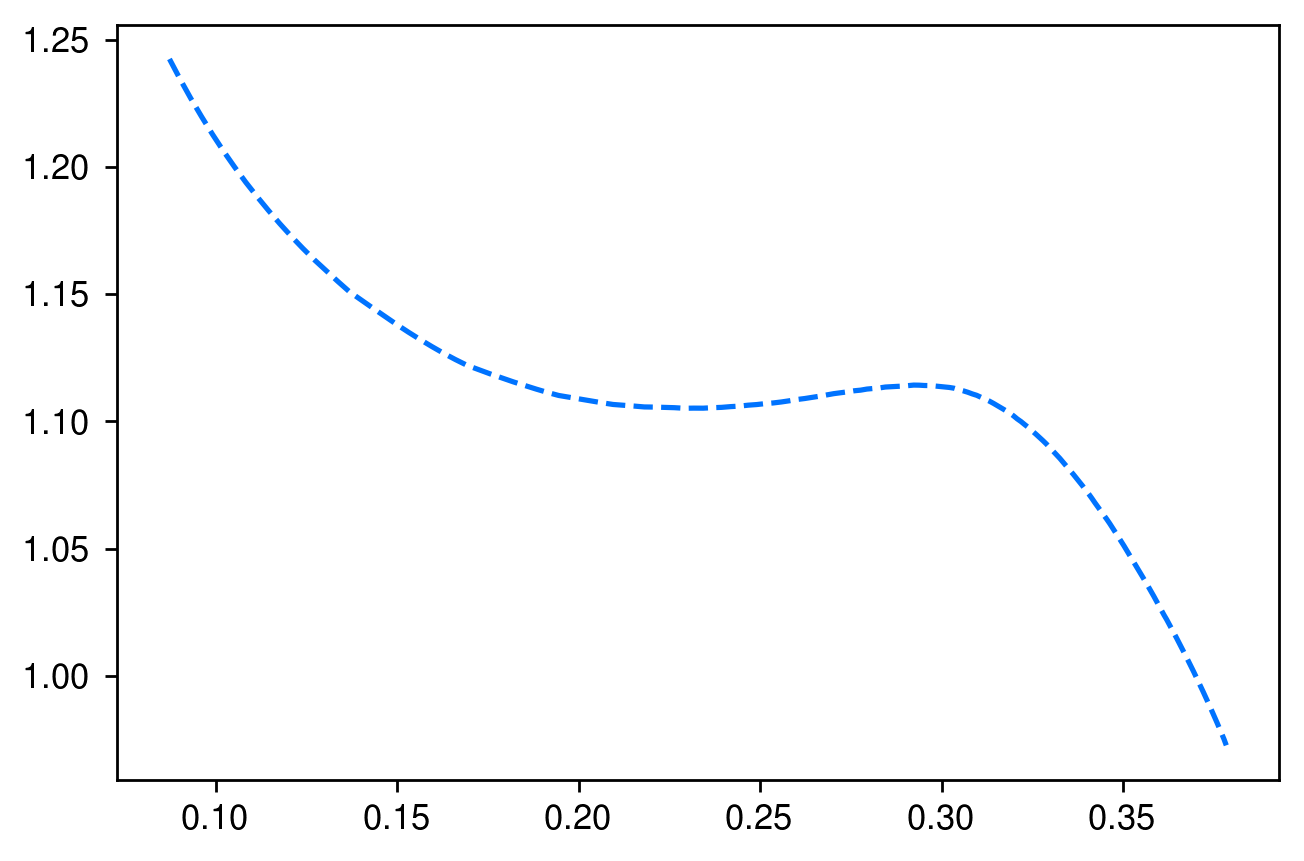

In [5]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
ax.plot(df_4_rigid['v_loc_smooth'][40:],(df_4_rigid['fd_smooth']/0.5/df['gap']/df_4_rigid['v_loc_smooth']**2)[40:],'--',c=cmap(600),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
pylab.show()


In [6]:
df68=df.copy()
df68_temporal=df_temporal.copy()
df68_4_rigid=df_4_rigid.copy()
df68_4_rigid_temporal=df_4_rigid_temporal.copy()

## E=1e7 MPa,  h=0.8 m

In [7]:
dataPath = repo_data
rho=1000
E=7
h=8
L=1.2
filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}.csv".format(E,h))
temporal_filePath=os.path.join(dataPath,"temporalVel_E_1e{0:d}_h_0.{1:d}_N.csv".format(E,h))
E_modulus = 10**E
h /=10
df = pd.read_csv(filePath)
df_temporal = pd.read_csv(temporal_filePath,header=None)
for column_name in ['Force:2','Normals:2','vtkValidPointMask','D:2','Point Coordinates:2']:
    df.drop(column_name, axis=1, inplace=True)
df.columns

Index(['p', 'Force:0', 'Force:1', 'Normals:0', 'Normals:1', 'U:0', 'U:1',
       'U:2', 'Area', 'Time', 'Point Coordinates:0', 'Point Coordinates:1',
       'D:0', 'D:1', 'rescaled_Ux', 'rescaled_Uy', 'Mag_normals', 'costheta'],
      dtype='object')

In [8]:
A = df['Area'][0]
start_id = np.where(df['Point Coordinates:0']>4.02)[0][0]
lmin=min(df.shape[0],df_temporal.shape[0])
df_4_rigid=df.iloc[:lmin,:]
df_4_rigid_temporal=df_temporal.iloc[:lmin,:]
skip = 20
df=df.iloc[start_id:lmin-skip,:]
df_temporal=df_temporal.iloc[start_id:lmin-skip,:]
df=df.iloc[:lmin,:]
df_4_rigid['local_velocity'] = df_4_rigid_temporal.iloc[:,0]
df_4_rigid['Z_fd_over_vloc'] = (1/A)*df_4_rigid['Force:0']/df_4_rigid['local_velocity']
df_4_rigid['fd_smooth'] = savgol_filter(df_4_rigid['Force:0'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['v_loc_smooth'] = savgol_filter(df_4_rigid['local_velocity'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['Cy'] = df_4_rigid['v_loc_smooth']**2*1000/E_modulus
df_4_rigid['Cys'] = df_4_rigid['Cy']*(h/w)**3
df_4_rigid['Cygap'] = df_4_rigid['Cy']*(df_4_rigid['Point Coordinates:1']/w)**3
df['Fdx'] = df['Force:0']*rho
df['Fdy'] = df['Force:1']*rho
df['gap'] = L-df['Point Coordinates:1']
df['Z_fd_over_vavg'] = (1/A)*df['Force:0']/df['rescaled_Ux']
df['local_velocity'] = df_temporal.iloc[:,1]
df['Z_fd_over_vloc'] = (1/A)*df['Force:0']/df['local_velocity']
#df['Z_fd_over_vavg'].fillna(0.001,inplace=True)
df['Z_eta_over_gap'] = 1/df['gap']
#df['Z_eta_over_gap'].fillna(0.001,inplace=True)
z_inf_eta_over_gap = df['Z_eta_over_gap'].values[-1]
z_inf_eta_over_gap_L = L
z_inf_fd_over_vavg = df['Z_fd_over_vavg'].values[-1]
z_inf_fd_over_vloc = df['Z_fd_over_vloc'].values[-1]
z_0_eta_over_gap=1/(L-h)
df['Z_tilde_gap']=(df['Z_eta_over_gap']-z_inf_eta_over_gap)/(z_0_eta_over_gap-z_inf_eta_over_gap)
df['Z_tilde_gap_L']=(df['Z_eta_over_gap']-z_inf_eta_over_gap_L)/(z_0_eta_over_gap-z_inf_eta_over_gap_L)
df['v_tilde_avg']=df['rescaled_Ux']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_loc_smooth'] = savgol_filter(df['local_velocity'], 51, 3) # window size 51, polynomial order 3
df['fd_smooth'] = savgol_filter(df['Force:0'], 51, 3) # window size 51, polynomial order 3
df['drag_coeff'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['drag_inst'] = df['fd_smooth']/df['v_loc_smooth']**2/b/(df['Point Coordinates:1'])
df['v_tilde_loc_smooth']=df['v_loc_smooth']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_final']=df['v_loc_smooth']/np.sqrt(E_modulus*(1-(h/L)))
dx = np.diff(np.log(df['v_loc_smooth']))
dy = np.diff(np.log(df['fd_smooth']))
dydx=dy/dx
df['derY']=df['v_loc_smooth']*0
df['derY'].values[1:]=dydx
df['yHat'] = savgol_filter(df['derY'], 51, 3) # window size 51, polynomial order 3

In [9]:
df78=df.copy()
df78_temporal=df_temporal.copy()
df78_4_rigid=df_4_rigid.copy()
df78_4_rigid_temporal=df_4_rigid_temporal.copy()

## E=1e6 MPa,  h=0.6 m

In [10]:
dataPath = repo_data
rho=1000
E=6
h=6
L=1.2
filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}.csv".format(E,h))
temporal_filePath=os.path.join(dataPath,"temporalVel_E_1e{0:d}_h_0.{1:d}_N.csv".format(E,h))
E_modulus = 10**E
h /=10
df = pd.read_csv(filePath)
df_temporal = pd.read_csv(temporal_filePath,header=None)
for column_name in ['Force:2','Normals:2','vtkValidPointMask','D:2','Point Coordinates:2']:
    df.drop(column_name, axis=1, inplace=True)
df.columns

Index(['p', 'Force:0', 'Force:1', 'Normals:0', 'Normals:1', 'U:0', 'U:1',
       'U:2', 'Area', 'Time', 'Point Coordinates:0', 'Point Coordinates:1',
       'D:0', 'D:1', 'rescaled_Ux', 'rescaled_Uy', 'Mag_normals', 'costheta'],
      dtype='object')

In [11]:
A = df['Area'][0]
start_id = np.where(df['Point Coordinates:0']>4.02)[0][0]
lmin=min(df.shape[0],df_temporal.shape[0])
skip = 20
df_4_rigid=df.iloc[:lmin,:]
df_4_rigid_temporal=df_temporal.iloc[:lmin,:]
df=df.iloc[start_id:lmin-skip,:]
df_temporal=df_temporal.iloc[start_id:lmin-skip,:]
df_4_rigid['local_velocity'] = df_4_rigid_temporal.iloc[:,0]
df_4_rigid['Z_fd_over_vloc'] = (1/A)*df_4_rigid['Force:0']/df_4_rigid['local_velocity']
df_4_rigid['fd_smooth'] = savgol_filter(df_4_rigid['Force:0'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['v_loc_smooth'] = savgol_filter(df_4_rigid['local_velocity'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['Cy'] = df_4_rigid['v_loc_smooth']**2*1000/E_modulus
df_4_rigid['Cys'] = df_4_rigid['Cy']*(h/w)**3
df_4_rigid['Cygap'] = df_4_rigid['Cy']*(df_4_rigid['Point Coordinates:1']/w)**3
df['Fdx'] = df['Force:0']*rho
df['Fdy'] = df['Force:1']*rho
df['gap'] = L-df['Point Coordinates:1']
df['Z_fd_over_vavg'] = (1/A)*df['Force:0']/df['rescaled_Ux']
df['local_velocity'] = df_temporal.iloc[:,1]
df['Z_fd_over_vloc'] = (1/A)*df['Force:0']/df['local_velocity']
#df['Z_fd_over_vavg'].fillna(0.001,inplace=True)
df['Z_eta_over_gap'] = 1/df['gap']
#df['Z_eta_over_gap'].fillna(0.001,inplace=True)
z_inf_eta_over_gap = df['Z_eta_over_gap'].values[-1]
z_inf_eta_over_gap_L = L
z_inf_fd_over_vavg = df['Z_fd_over_vavg'].values[-1]
z_inf_fd_over_vloc = df['Z_fd_over_vloc'].values[-1]
z_0_eta_over_gap=1/(L-h)
df['Z_tilde_gap']=(df['Z_eta_over_gap']-z_inf_eta_over_gap)/(z_0_eta_over_gap-z_inf_eta_over_gap)
df['Z_tilde_gap_L']=(df['Z_eta_over_gap']-z_inf_eta_over_gap_L)/(z_0_eta_over_gap-z_inf_eta_over_gap_L)
df['v_tilde_avg']=df['rescaled_Ux']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_loc_smooth'] = savgol_filter(df['local_velocity'], 51, 3) # window size 51, polynomial order 3
df['fd_smooth'] = savgol_filter(df['Force:0'], 51, 3) # window size 51, polynomial order 3
df['drag_coeff'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['drag_inst'] = df['fd_smooth']/df['v_loc_smooth']**2/b/(df['Point Coordinates:1'])
df['v_tilde_loc_smooth']=df['v_loc_smooth']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_final']=df['v_loc_smooth']/np.sqrt(E_modulus*(1-(h/L)))
dx = np.diff(np.log(df['v_loc_smooth']))
dy = np.diff(np.log(df['fd_smooth']))
dydx=dy/dx
df['derY']=df['v_loc_smooth']*0
df['derY'].values[1:]=dydx
df['yHat'] = savgol_filter(df['derY'], 51, 3) # window size 51, polynomial order 3

In [12]:
df66=df.copy()
df66_temporal=df_temporal.copy()
df66_4_rigid=df_4_rigid.copy()
df66_4_rigid_temporal=df_4_rigid_temporal.copy()

## E=1e7 MPa,  h=0.6 m

In [13]:
dataPath = repo_data
rho=1000
E=7
h=6
L=1.2
filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}.csv".format(E,h))
temporal_filePath=os.path.join(dataPath,"temporalVel_E_1e{0:d}_h_0.{1:d}_N.csv".format(E,h))
E_modulus = 10**E
h /=10
df = pd.read_csv(filePath)
df_temporal = pd.read_csv(temporal_filePath,header=None)
for column_name in ['Force:2','Normals:2','vtkValidPointMask','D:2','Point Coordinates:2']:
    df.drop(column_name, axis=1, inplace=True)
df.columns

Index(['p', 'Force:0', 'Force:1', 'Normals:0', 'Normals:1', 'U:0', 'U:1',
       'U:2', 'Area', 'Time', 'Point Coordinates:0', 'Point Coordinates:1',
       'D:0', 'D:1', 'rescaled_Ux', 'rescaled_Uy', 'Mag_normals', 'costheta'],
      dtype='object')

In [14]:
A = df['Area'][0]
start_id = np.where(df['Point Coordinates:0']>4.02)[0][0]
lmin=min(df.shape[0],df_temporal.shape[0])
skip = 20
df_4_rigid=df.iloc[:lmin,:]
df_4_rigid_temporal=df_temporal.iloc[:lmin,:]
df=df.iloc[start_id:lmin-skip,:]
df_temporal=df_temporal.iloc[start_id:lmin-skip,:]
df_4_rigid['gap'] = L-df_4_rigid['Point Coordinates:1']
df_4_rigid['local_velocity'] = df_4_rigid_temporal.iloc[:,0]
#df_4_rigid['local_velocity'] = df_4_rigid_temporal.iloc[:,2]*0.03/(2*(df_4_rigid['gap']-0.02)/100+0.01)
df_4_rigid['Z_fd_over_vloc'] = (1/A)*df_4_rigid['Force:0']/df_4_rigid['local_velocity']
df_4_rigid['fd_smooth'] = savgol_filter(df_4_rigid['Force:0'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['v_loc_smooth'] = savgol_filter(df_4_rigid['local_velocity'], 51, 3) # window size 51, polynomial order 3
df_4_rigid['Cy'] = df_4_rigid['v_loc_smooth']**2*1000/E_modulus
df_4_rigid['Cys'] = df_4_rigid['Cy']*(h/w)**3
df_4_rigid['Cygap'] = df_4_rigid['Cy']*(df_4_rigid['Point Coordinates:1']/w)**3
df['Fdx'] = df['Force:0']*rho
df['Fdy'] = df['Force:1']*rho
df['gap'] = L-df['Point Coordinates:1']
df['Z_fd_over_vavg'] = (1/A)*df['Force:0']/df['rescaled_Ux']
df['local_velocity'] = df_temporal.iloc[:,0]
df['Z_fd_over_vloc'] = (1/A)*df['Force:0']/df['local_velocity']
#df['Z_fd_over_vavg'].fillna(0.001,inplace=True)
df['Z_eta_over_gap'] = 1/df['gap']
#df['Z_eta_over_gap'].fillna(0.001,inplace=True)
z_inf_eta_over_gap = df['Z_eta_over_gap'].values[-1]
z_inf_eta_over_gap_L = L
z_inf_fd_over_vavg = df['Z_fd_over_vavg'].values[-1]
z_inf_fd_over_vloc = df['Z_fd_over_vloc'].values[-1]
z_0_eta_over_gap=1/(L-h)
df['Z_tilde_gap']=(df['Z_eta_over_gap']-z_inf_eta_over_gap)/(z_0_eta_over_gap-z_inf_eta_over_gap)
df['Z_tilde_gap_L']=(df['Z_eta_over_gap']-z_inf_eta_over_gap_L)/(z_0_eta_over_gap-z_inf_eta_over_gap_L)
df['v_tilde_avg']=df['rescaled_Ux']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_loc_smooth'] = savgol_filter(df['local_velocity'], 51, 3) # window size 51, polynomial order 3
df['fd_smooth'] = savgol_filter(df['Force:0'], 51, 3) # window size 51, polynomial order 3
df['drag_coeff'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['drag_inst'] = df['fd_smooth']/df['v_loc_smooth']**2/b/(df['Point Coordinates:1'])
df['v_tilde_loc_smooth']=df['v_loc_smooth']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_final']=df['v_loc_smooth']/np.sqrt(E_modulus*(1-(h/L)))
dx = np.diff(np.log(df['v_loc_smooth']))
dy = np.diff(np.log(df['fd_smooth']))
dydx=dy/dx
df['derY']=df['v_loc_smooth']*0
df['derY'].values[1:]=dydx
df['yHat'] = savgol_filter(df['derY'], 51, 3) # window size 51, polynomial order 3

In [15]:
df76=df.copy()
df76_temporal=df_temporal.copy()
df76_4_rigid=df_4_rigid.copy()
df76_4_rigid_temporal=df_4_rigid_temporal.copy()

## E=1e12 MPa,  h=0.8 m

In [16]:
dataPath = repo_data
rho=1000
E=12
h=8
L=1.2
filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}.csv".format(E,h))
temporal_filePath=os.path.join(dataPath,"temporalVel_E_1e{0:d}_h_0.{1:d}_N.csv".format(E,h))
E_modulus = 10**E
h /=10
df = pd.read_csv(filePath)
df_temporal = pd.read_csv(temporal_filePath,header=None)
for column_name in ['Force:2','Normals:2','vtkValidPointMask']:
    df.drop(column_name, axis=1, inplace=True)
df.columns

Index(['p', 'Force:0', 'Force:1', 'Normals:0', 'Normals:1', 'U:0', 'U:1',
       'U:2', 'Area', 'Time', 'rescaled_Ux', 'rescaled_Uy'],
      dtype='object')

In [17]:
A = df['Area'][0]
start_id = 10
lmin=min(df.shape[0],df_temporal.shape[0])
skip = 0
df=df.iloc[start_id:lmin-skip,:]
df_temporal=df_temporal.iloc[start_id:lmin-skip,:]
df['Fdx'] = df['Force:0']*rho
df['Fdy'] = df['Force:1']*rho
df['gap'] = L-h
df['Z_fd_over_vavg'] = (1/A)*df['Force:0']/df['rescaled_Ux']
df['local_velocity'] = df_temporal.iloc[:,0]
df['Z_fd_over_vloc'] = (1/A)*df['Force:0']/df['local_velocity']
#df['Z_fd_over_vavg'].fillna(0.001,inplace=True)
df['Z_eta_over_gap'] = 1/df['gap']
#df['Z_eta_over_gap'].fillna(0.001,inplace=True)
z_inf_eta_over_gap = df['Z_eta_over_gap'].values[-1]
z_inf_eta_over_gap_L = L
z_inf_fd_over_vavg = df['Z_fd_over_vavg'].values[-1]
z_inf_fd_over_vloc = df['Z_fd_over_vloc'].values[-1]
z_0_eta_over_gap=1/(L-h)
df['Z_tilde_gap']=(df['Z_eta_over_gap']-z_inf_eta_over_gap)/(z_0_eta_over_gap-z_inf_eta_over_gap)
df['Z_tilde_gap_L']=(df['Z_eta_over_gap']-z_inf_eta_over_gap_L)/(z_0_eta_over_gap-z_inf_eta_over_gap_L)
df['v_tilde_avg']=df['rescaled_Ux']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_loc_smooth'] = savgol_filter(df['local_velocity'], 51, 3) # window size 51, polynomial order 3
df['fd_smooth'] = savgol_filter(df['Force:0'], 51, 3) # window size 51, polynomial order 3
df['drag_coeff'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['v_loc_smooth2'] = savgol_filter(df['local_velocity'], 51, 3)**2 # window size 51, polynomial order 3
df['drag_coeff2'] = df['fd_smooth']/df['v_loc_smooth2']**2/b/h

df['drag_inst'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['Cy'] = df['v_loc_smooth']**2*1000/E_modulus
df['Cys'] = df['Cy']*(h/w)**3
df['v_tilde_loc_smooth']=df['v_loc_smooth']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_final']=df['v_loc_smooth']/np.sqrt(E_modulus*(1-(h/L)))
dx = np.diff(np.log(df['v_loc_smooth']))
dy = np.diff(np.log(df['fd_smooth']))
dydx=dy/dx
df['derY']=df['v_loc_smooth']*0
df['derY'].values[1:]=dydx
df['yHat'] = savgol_filter(df['derY'], 51, 3) # window size 51, polynomial order 3

In [18]:
dfrigid8=df.copy()
dfrigid8_temporal=df_temporal.copy()
#f_rigid8_interp = InterpolatedUnivariateSpline(dfrigid8['local_velocity'],dfrigid8['Force:0'], k=2)
f_rigid8_interp = interpolate.interp1d(dfrigid8['v_loc_smooth'].values,dfrigid8['fd_smooth'].values, fill_value='extrapolate')

## E=1e12 MPa,  h=0.6 m

In [19]:
from scipy.signal import savgol_filter
dataPath = repo_data
rho=1000
E=12
h=6
L=1.2
filePath=os.path.join(dataPath,"all_E{0:d}_h{1:d}.csv".format(E,h))
temporal_filePath=os.path.join(dataPath,"temporalVel_E_1e{0:d}_h_0.{1:d}_N.csv".format(E,h))
E_modulus = 10**E
h /=10
df = pd.read_csv(filePath)
df_temporal = pd.read_csv(temporal_filePath,header=None)
for column_name in ['Force:2','Normals:2','vtkValidPointMask']:
    df.drop(column_name, axis=1, inplace=True)
df.columns

Index(['p', 'Force:0', 'Force:1', 'Normals:0', 'Normals:1', 'U:0', 'U:1',
       'U:2', 'Area', 'Time', 'rescaled_Ux', 'rescaled_Uy'],
      dtype='object')

In [20]:
A = df['Area'][0]
start_id = 0
lmin=min(df.shape[0],df_temporal.shape[0])
skip = 0
df=df.iloc[start_id:lmin-skip,:]
df_temporal=df_temporal.iloc[start_id:lmin-skip,:]
df['Fdx'] = df['Force:0']*rho
df['Fdy'] = df['Force:1']*rho
df['gap'] = L-h
df['Z_fd_over_vavg'] = (1/A)*df['Force:0']/df['rescaled_Ux']
df['local_velocity'] = df_temporal.iloc[:,0]
df['Z_fd_over_vloc'] = (1/A)*df['Force:0']/df['local_velocity']
#df['Z_fd_over_vavg'].fillna(0.001,inplace=True)
df['Z_eta_over_gap'] = 1/df['gap']
#df['Z_eta_over_gap'].fillna(0.001,inplace=True)
z_inf_eta_over_gap = df['Z_eta_over_gap'].values[-1]
z_inf_eta_over_gap_L = L
z_inf_fd_over_vavg = df['Z_fd_over_vavg'].values[-1]
z_inf_fd_over_vloc = df['Z_fd_over_vloc'].values[-1]
z_0_eta_over_gap=1/(L-h)
df['Z_tilde_gap']=(df['Z_eta_over_gap']-z_inf_eta_over_gap)/(z_0_eta_over_gap-z_inf_eta_over_gap)
df['Z_tilde_gap_L']=(df['Z_eta_over_gap']-z_inf_eta_over_gap_L)/(z_0_eta_over_gap-z_inf_eta_over_gap_L)
df['v_tilde_avg']=df['rescaled_Ux']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_loc_smooth'] = savgol_filter(df['local_velocity'], 51, 3) # window size 51, polynomial order 3
df['fd_smooth'] = savgol_filter(df['Force:0'], 51, 3) # window size 51, polynomial order 3
df['drag_coeff'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['drag_inst'] = df['fd_smooth']/df['v_loc_smooth']**2/b/h
df['Cy'] = df['v_loc_smooth']**2*1000/E_modulus
df['Cys'] = df['Cy']*(h/w)**3
df['v_tilde_loc_smooth']=df['v_loc_smooth']*(4*h**2/(1-(h/L))**(-1.5))/(1e-6*E_modulus*L)
df['v_final']=df['v_loc_smooth']/np.sqrt(E_modulus*(1-(h/L)))
dx = np.diff(np.log(df['v_loc_smooth']))
dy = np.diff(np.log(df['fd_smooth']))
dydx=dy/dx
df['derY']=df['v_loc_smooth']*0
df['derY'].values[1:]=dydx
df['yHat'] = savgol_filter(df['derY'], 51, 3) # window size 51, polynomial order 3

In [21]:
dfrigid6=df.copy()
dfrigid6_temporal=df_temporal.copy()
f_rigid6_interp = interpolate.interp1d(dfrigid6['v_loc_smooth'].values,dfrigid6['fd_smooth'].values, fill_value='extrapolate')

## Reconfiguration parameter

In [22]:
rig6 = interpolate.interp1d(dfrigid6['Cys'].values,dfrigid6['fd_smooth'].values, fill_value='extrapolate')
rig8 = interpolate.interp1d(dfrigid8['Cys'].values,dfrigid8['fd_smooth'].values, fill_value='extrapolate')
df66_4_rigid['Reconf2']=df66_4_rigid['fd_smooth']/rig6(df66_4_rigid['Cys'])
df76_4_rigid['Reconf2']=df76_4_rigid['fd_smooth']/rig6(df76_4_rigid['Cys'])
df68_4_rigid['Reconf2']=df68_4_rigid['fd_smooth']/rig8(df68_4_rigid['Cys'])
df78_4_rigid['Reconf2']=df78_4_rigid['fd_smooth']/rig8(df78_4_rigid['Cys'])

## Force velocity

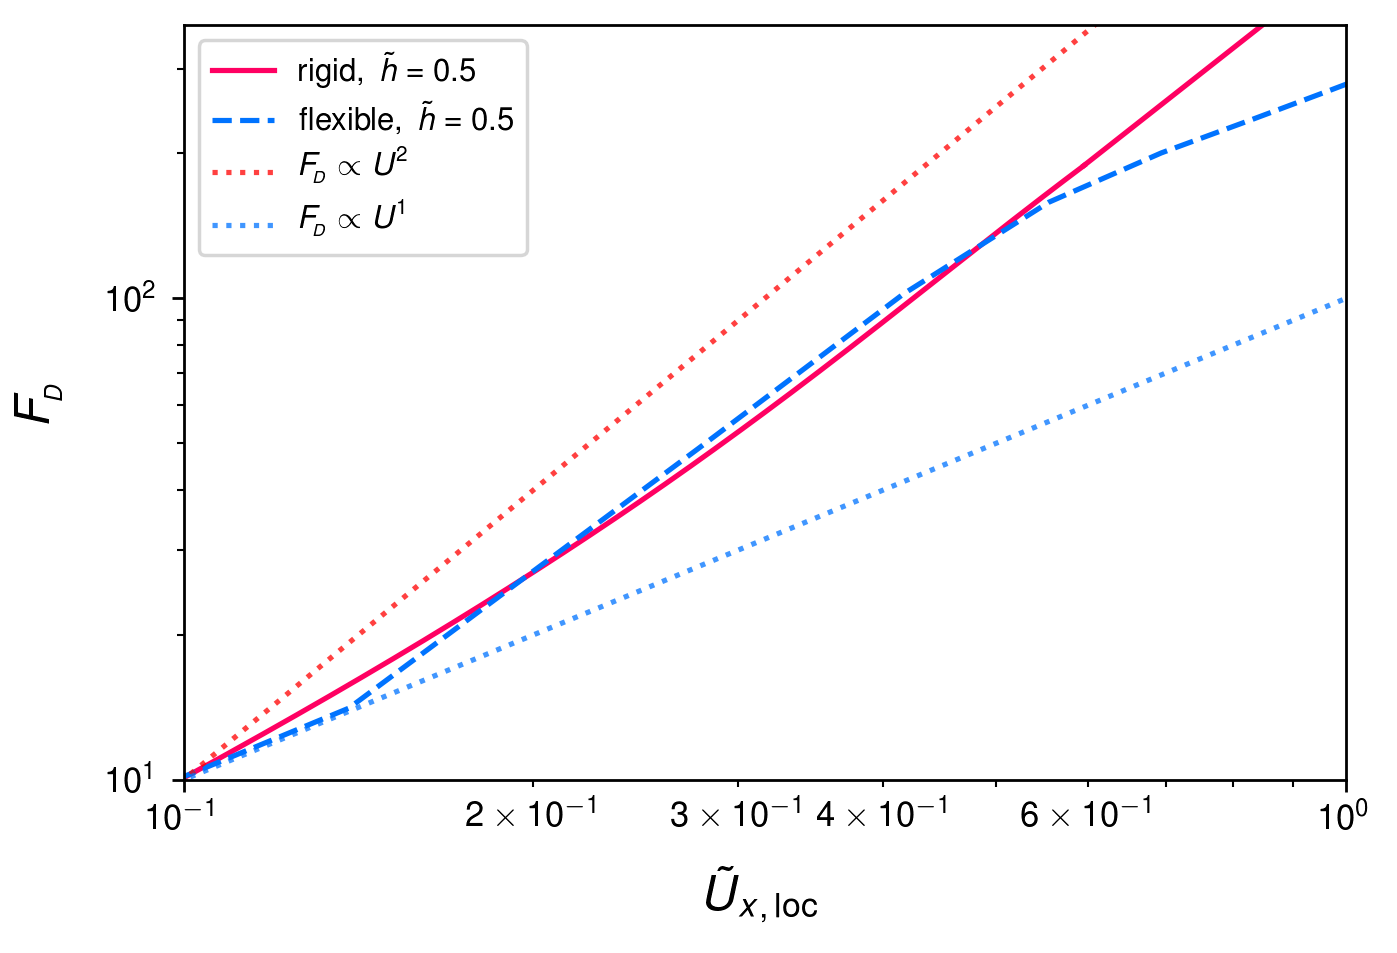

In [61]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
end_id = np.where(dfrigid6['v_loc_smooth']>0.737)[0][0]
ax.plot(dfrigid6['v_loc_smooth'].values[:end_id]**(1.7),520*dfrigid6['fd_smooth'].values[:end_id]*0.59,'-',c=cmap(950),mfc='w',markersize=2,label=r'$\mathrm{rigid}, \ \tilde{h}=%.1f$' % (0.5))
xx = np.linspace(dfrigid6['v_loc_smooth'].values[end_id-1]**(1.7),1,100)
yy = 1000*xx**2
ax.loglog(xx,0.715*yy**0.95,'-',c=cmap(950),mfc='w')#,label=r'$F_{_{\!D}} \propto U^%d$'%power)

#ax.plot(dfrigid6['v_loc_smooth'].values[:end_id]**(1.7),520*dfrigid6['fd_smooth'].values[:end_id]*0.59,'-',c=cmap(950),mfc='w',markersize=2,label=r'$\mathrm{rigid}, \ \tilde{h}=%.1f$' % (0.5))
end_id = np.where(df66_4_rigid['v_loc_smooth']>0.68)[0][0]
xxx=df66_4_rigid['v_loc_smooth'].values[:end_id]
yyy=df66_4_rigid['fd_smooth'].values[:end_id]
y_interp = interpolate.interp1d(xxx,yyy, fill_value='extrapolate')
xxX=np.linspace(xxx[0],xxx[-1]*10)
ax.plot(xxX,2700*y_interp(xxX)*0.95,'--',c=cmap(600),mfc='w',markersize=2,label=r'$\mathrm{flexible}, \ \tilde{h}=%.1f$' % (0.5))
ax.set_ylabel(r'$F_{_{\!D}}$',fontsize=14)
ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(0.01,1,100)
yy = 1000*xx**2
ax.loglog(xx,yy, 'r:',alpha=0.75,label=r'$F_{_{\!D}} \propto U^%d$'%power)
yy = 100*xx
ax.loglog(xx,yy, ':',c=cmap(600),alpha=0.75,label=r'$F_{_{\!D}} \propto U^%d$'%1)
ax.set_xlim([0.1,1]) #
ax.set_ylim([10,370])
ax.legend(loc='ne',fontsize=9)
fig.savefig('%s/fdrag_vloc_normal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()


In [50]:
df66_4_rigid['Point Coordinates:1'].iloc[700]

0.5149

In [51]:
max(df78_4_rigid_temporal.iloc[700])

2.1446

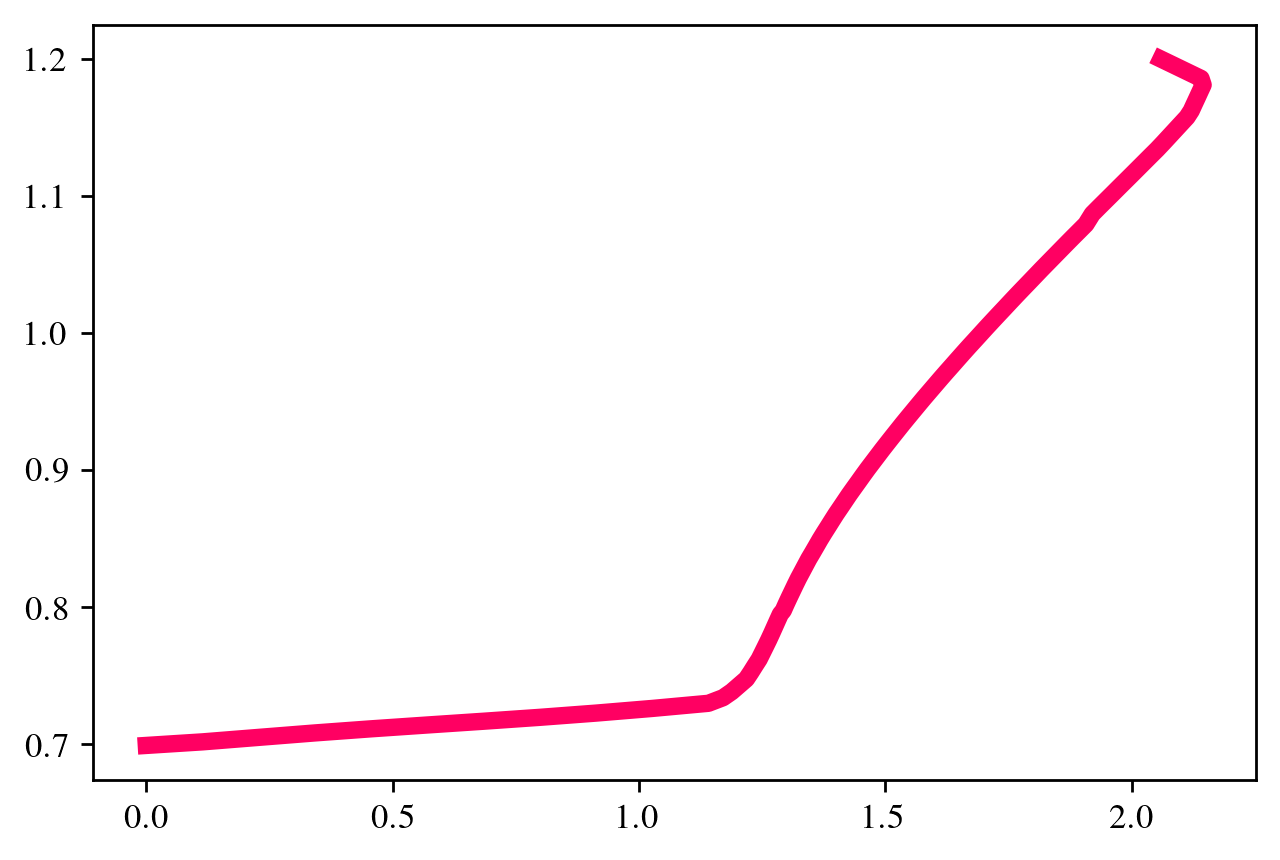

In [586]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
#ax.plot(df78_4_rigid_temporal.iloc[700,:],np.linspace(0,1.2-0.7292,101)+0.7292,'-',c=cmap(950),mfc='w',markersize=2,label="rigid, h=%.1f m" % (0.6))
xx=np.linspace(0,df78_4_rigid_temporal.iloc[700,0],11)[:-1]
xxx=np.zeros(111)
xxx[:10]=xx
xxx[10:]=df78_4_rigid_temporal.iloc[700,:]
yyy=np.zeros(111)
yy=np.linspace(0.6992,0.7292,11)[:-1]
yyy[:10]=yy
yyy[10:]=np.linspace(0,1.2-0.7292,101)+0.7292
ax.plot(xxx,savgol_filter(yyy,51,11),'-',c=cmap(950),mfc='w',lw=5,label="rigid, h=%.1f m" % (0.6))
#ax.legend(loc='ne',fontsize=9)
fig.savefig('%s/vel_prof_700.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

pylab.show()

## Equivalent drag coefficient

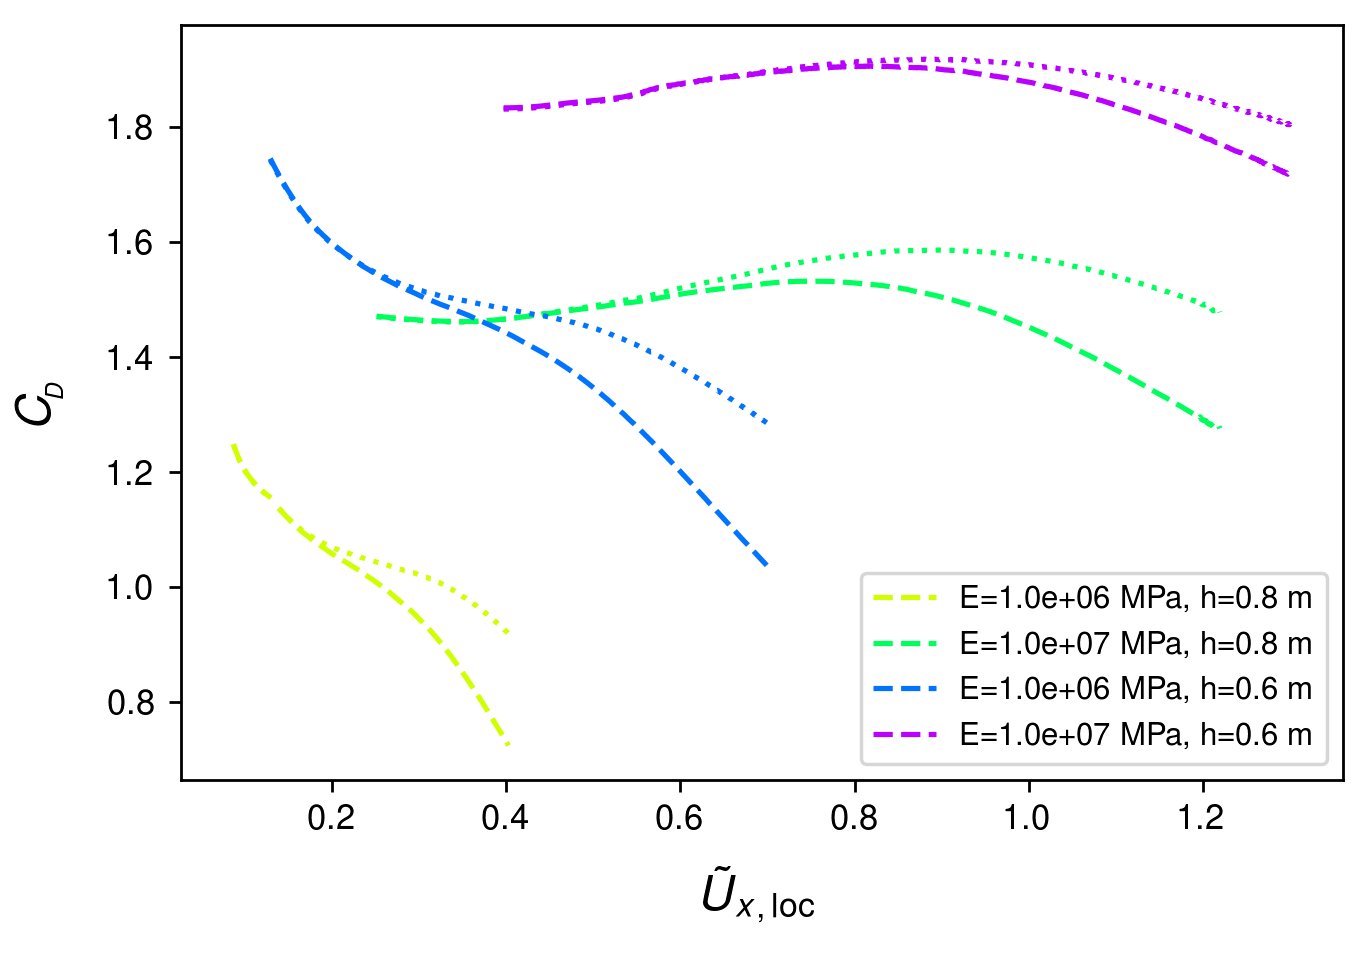

In [62]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
"""end_id = np.where(dfrigid8['v_loc_smooth']>0.68)[0][0]
start_id = np.where(dfrigid8['v_loc_smooth']>0.01)[0][0]
ax.plot(dfrigid8['v_loc_smooth'].values[start_id:end_id],dfrigid8['drag_coeff'].values[start_id:end_id],'-',c=cmap(490),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**12,0.8))
end_id = np.where(dfrigid6['v_loc_smooth']>0.68)[0][0]
start_id = np.where(dfrigid6['v_loc_smooth']>0.01)[0][0]
ax.plot(dfrigid8['v_loc_smooth2'].values[start_id:end_id],2*dfrigid8['drag_coeff2'].values[start_id:end_id],'-',c=cmap(50),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**12,0.6))
"""
end_id = np.where(df68['v_loc_smooth']>0.8)[0]
ax.plot(df68['v_loc_smooth'].values[:-160],2*df68['drag_coeff'].values[:-160],'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.8))
ax.plot(df68['v_loc_smooth'].values[:-160],2*df68['drag_inst'].values[:-160],':',c=cmap(200),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.8))
end_id = np.where(df78['v_loc_smooth']>1.22)[0][0]
ax.plot(df78['v_loc_smooth'].values[:end_id],2*df78['drag_coeff'].values[:end_id],'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.8))
ax.plot(df78['v_loc_smooth'].values[:end_id],2*df78['drag_inst'].values[:end_id],':',c=cmap(400),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.8))
end_id = np.where(df66['v_loc_smooth']>0.7)[0][0]
ax.plot(df66['v_loc_smooth'].values[:end_id],2*df66['drag_coeff'].values[:end_id],'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
ax.plot(df66['v_loc_smooth'].values[:end_id],2*df66['drag_inst'].values[:end_id],':',c=cmap(600),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
ax.plot(df66['v_loc_smooth'].values[50:500]*0.65,2*(df66['drag_coeff'].values[50:500]-0.222),'--',c=cmap(200),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
ax.plot(df66['v_loc_smooth'].values[50:500]*0.65,2*(df66['drag_inst'].values[50:500]-0.222),':',c=cmap(200),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
end_id = np.where(df76['v_loc_smooth']>1.3)[0][0]
ax.plot(df76['v_loc_smooth'].values[:end_id],2*df76['drag_coeff'].values[:end_id],'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.6))
ax.plot(df76['v_loc_smooth'].values[:end_id],2*df76['drag_inst'].values[:end_id],':',c=cmap(800),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.6))

ax.set_ylabel(r'${C}_{_{\!D}}$',fontsize=14)
ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = 500*xx**2
#ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$F_d \propto U^%d$'%power)
#ax.set_xlim([.01,0.7]) #

#ax.set_ylim([0,3])
ax.legend(loc='nw',fontsize=9)
fig.savefig('%s/drag_norm_inst_vloc_normal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

### Instantaneous drag coefficient

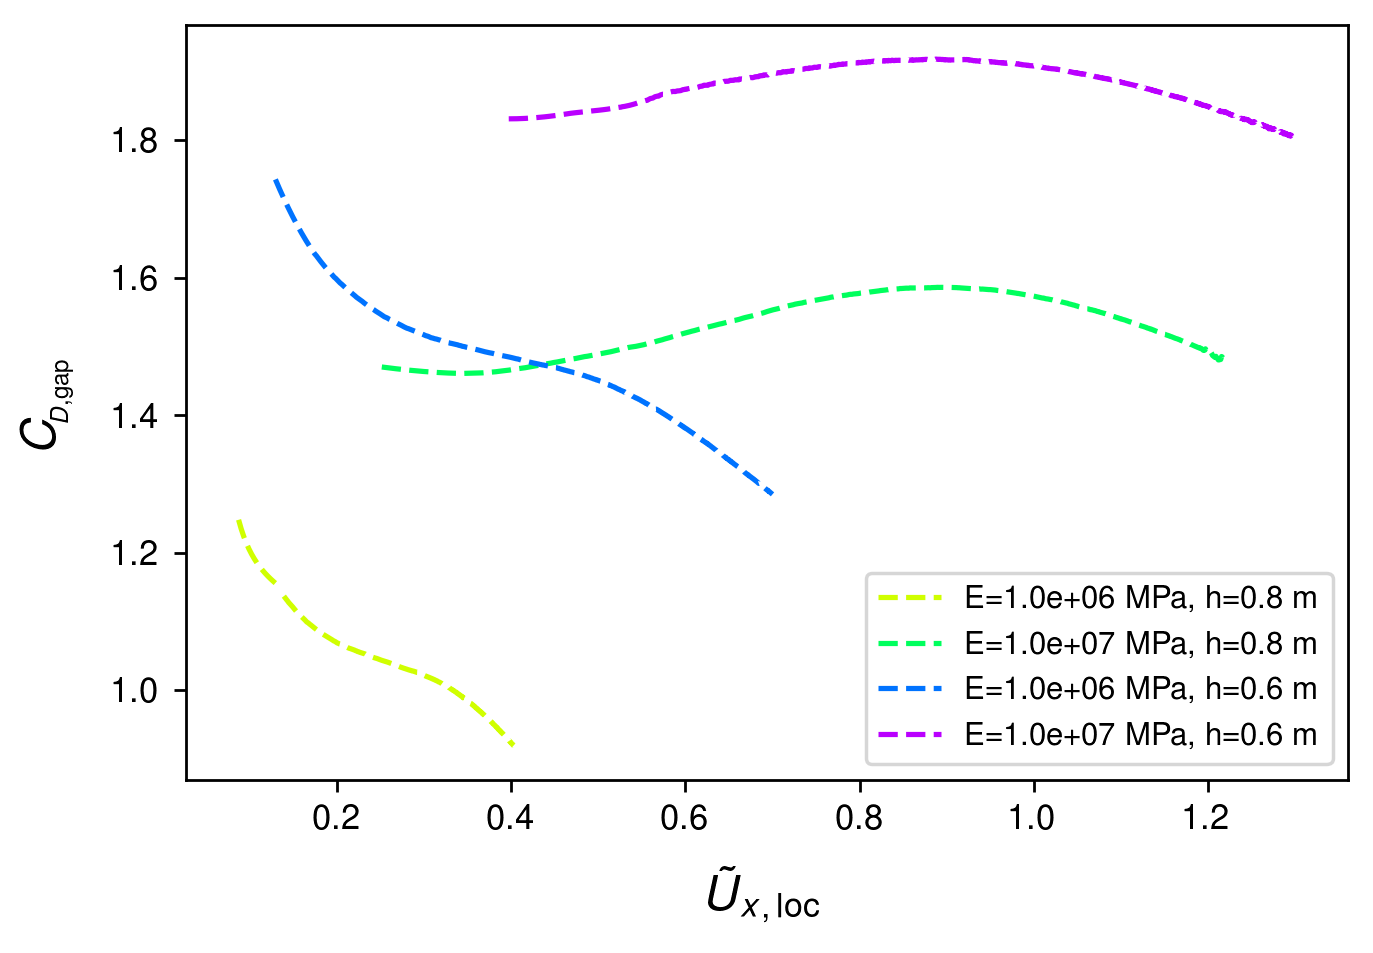

In [63]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
#end_id = np.where(dfrigid8['v_loc_smooth']>0.68)[0][0]
#ax.plot(dfrigid8['v_loc_smooth'].values[:end_id],dfrigid8['drag_coeff'].values[:end_id],'-',c=cmap(50),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**12,0.8))
#end_id = np.where(dfrigid6['v_loc_smooth']>0.68)[0][0]
#ax.plot(dfrigid6['v_loc_smooth'].values[:end_id],dfrigid6['drag_coeff'].values[:end_id],'-',c=cmap(950),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**12,0.6))
end_id = np.where(df68['v_loc_smooth']>0.8)[0]
ax.plot(df68['v_loc_smooth'].values[:-160],2*df68['drag_inst'].values[:-160],'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.8))
end_id = np.where(df78['v_loc_smooth']>1.22)[0][0]
ax.plot(df78['v_loc_smooth'].values[:end_id],2*df78['drag_inst'].values[:end_id],'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.8))
end_id = np.where(df66['v_loc_smooth']>0.7)[0][0]
ax.plot(df66['v_loc_smooth'].values[:end_id],2*df66['drag_inst'].values[:end_id],'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
ax.plot(df66['v_loc_smooth'].values[50:500]*0.65,2*(df66['drag_inst'].values[50:500]-0.222),'--',c=cmap(200),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
end_id = np.where(df76['v_loc_smooth']>1.3)[0][0]
ax.plot(df76['v_loc_smooth'].values[:end_id],2*df76['drag_inst'].values[:end_id],'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.6))

ax.set_ylabel(r'${C}_{_{\!D,\mathrm{gap}}}$',fontsize=14)
ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = 500*xx**2
#ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$F_d \propto U^%d$'%power)
#ax.set_xlim([.01,0.7]) #

#ax.set_ylim([0,1.5])
ax.legend(loc='ne',fontsize=9)
fig.savefig('%s/drag_gap_vloc_normal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

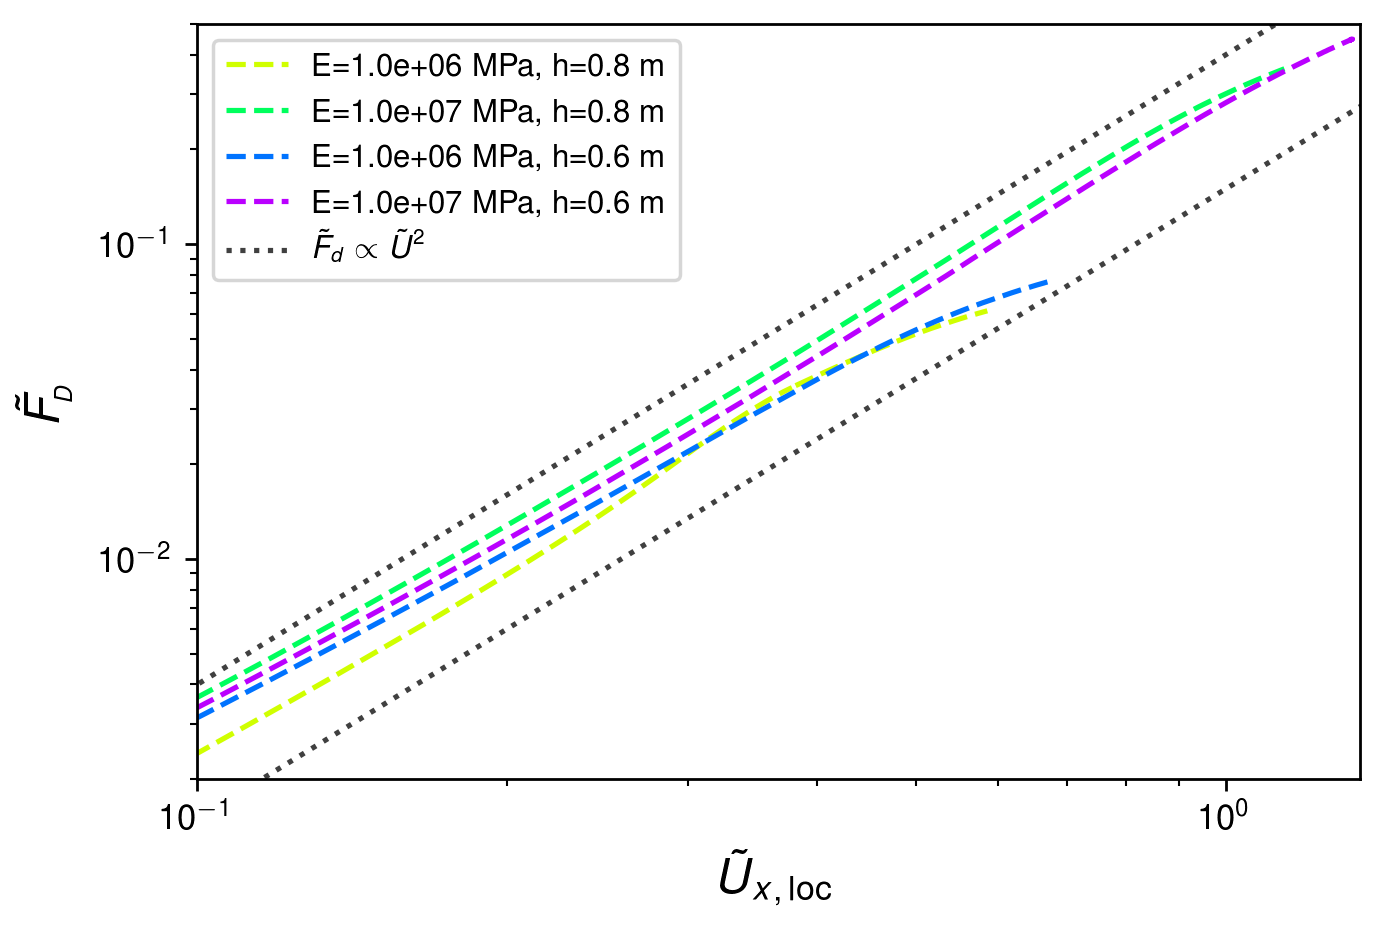

In [70]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
factor=1/(0.5*1*1.2)
ax.loglog(df68_4_rigid['v_loc_smooth'].values[:],df68_4_rigid['fd_smooth'].values[:],'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.8))
ax.loglog(df66_4_rigid['v_loc_smooth'].values[-610:-340]+0.025,0.779*df66_4_rigid['fd_smooth'].values[-610:-340]/(df66_4_rigid['v_loc_smooth'].values[-610:-340])**(0.4),'--',c=cmap(200),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.8))
ax.loglog(df78_4_rigid['v_loc_smooth'].values[:-200],df78_4_rigid['fd_smooth'].values[:-200],'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.8))
ax.loglog(df66_4_rigid['v_loc_smooth'].values[:-20],df66_4_rigid['fd_smooth'].values[:-20],'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,0.6))
ax.loglog(df76_4_rigid['v_loc_smooth'].values,df76_4_rigid['fd_smooth'].values,'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,0.6))
ax.set_ylabel(r'$\tilde{F\,}{\!\!}_{_{\!D}}$',fontsize=14)
ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = 0.4*xx**2
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$\tilde{F}_d \propto \tilde{U}^%d$'%power)
yy = 0.15*xx**2
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)#,label=r'$F_d \propto U^%d$'%power)
ax.set_xlim([0.1,1.35]) #
ax.set_ylim([0.002,0.5])
ax.legend(loc='nw',fontsize=9)
fig.savefig('%s/fdrag_vloc_normal_fix_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

In [71]:
df68_4_rigid['gap']=1.2-df68_4_rigid['Point Coordinates:1']
df78_4_rigid['gap']=1.2-df78_4_rigid['Point Coordinates:1']
df66_4_rigid['gap']=1.2-df66_4_rigid['Point Coordinates:1']
df76_4_rigid['gap']=1.2-df76_4_rigid['Point Coordinates:1']
dfrigid6['gap']=0.6
dfrigid8['gap']=0.8
df68_4_rigid['gamma_dot']=100*(df68_4_rigid_temporal.iloc[:,2]-df68_4_rigid_temporal.iloc[:,1])/(df68_4_rigid['gap']-0.02)
df78_4_rigid['gamma_dot']=100*(df78_4_rigid_temporal.iloc[:,2]-df78_4_rigid_temporal.iloc[:,1])/(df78_4_rigid['gap']-0.02)
df66_4_rigid['gamma_dot']=100*(df66_4_rigid_temporal.iloc[:,2]-df66_4_rigid_temporal.iloc[:,1])/(df66_4_rigid['gap']-0.02)
df76_4_rigid['gamma_dot']=100*(df76_4_rigid_temporal.iloc[:,2]-df76_4_rigid_temporal.iloc[:,1])/(df76_4_rigid['gap']-0.02)
dfrigid6['gamma_dot']=50*(dfrigid6_temporal.iloc[:,3]-dfrigid6_temporal.iloc[:,2])/0.6
dfrigid8['gamma_dot']=33*(dfrigid8_temporal.iloc[:,3]-dfrigid8_temporal.iloc[:,2])/0.4

## $\theta: \ $ beam tip angle

In [72]:
df68['normals_smooth'] = savgol_filter(df68['Mag_normals'], 51, 3)
df78['normals_smooth'] = savgol_filter(df78['Mag_normals'], 51, 3)
df66['normals_smooth'] = savgol_filter(df66['Mag_normals'], 51, 3)
df76['normals_smooth'] = savgol_filter(df76['Mag_normals'], 51, 3)
df68_4_rigid['normals_smooth'] = savgol_filter(df68_4_rigid['Mag_normals'], 51, 3)
df78_4_rigid['normals_smooth'] = savgol_filter(df78_4_rigid['Mag_normals'], 51, 3)
df66_4_rigid['normals_smooth'] = savgol_filter(df66_4_rigid['Mag_normals'], 51, 3)
df76_4_rigid['normals_smooth'] = savgol_filter(df76_4_rigid['Mag_normals'], 51, 3)
df68_4_rigid['normals_smoother'] = smooth(df68_4_rigid['normals_smooth'].values,11)
df78_4_rigid['normals_smoother'] = smooth(df78_4_rigid['normals_smooth'].values,11)
df66_4_rigid['normals_smoother'] = smooth(df66_4_rigid['normals_smooth'].values,11)
df76_4_rigid['normals_smoother'] = smooth(df76_4_rigid['normals_smooth'].values,11)


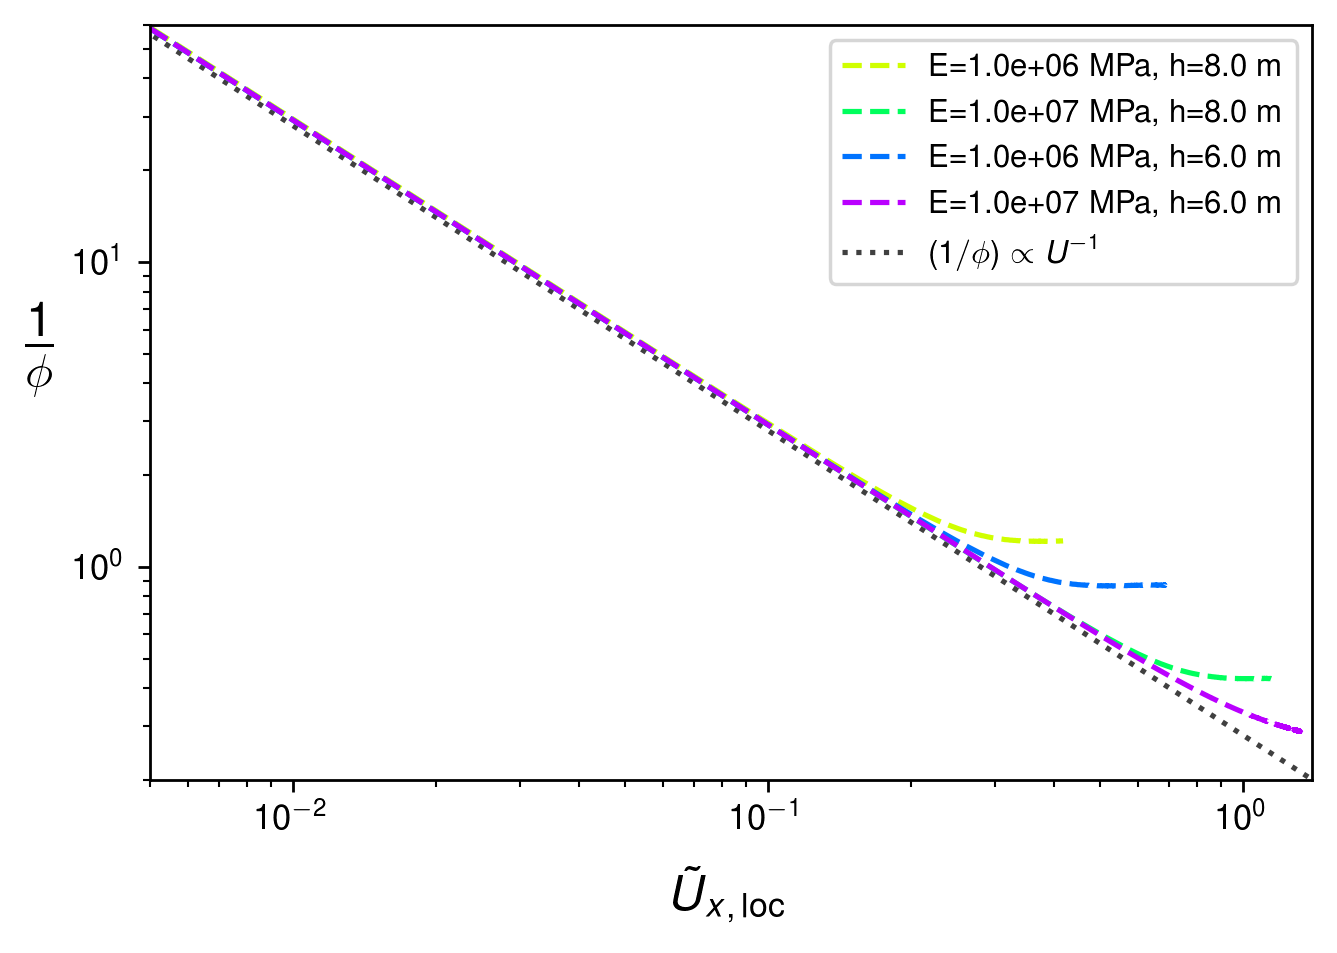

In [73]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-1

ax.loglog(df66_4_rigid['v_loc_smooth'].values[:-300]*0.72,1.4*(np.cos((df66_4_rigid['costheta'].values[:-300])))**2/df66_4_rigid['v_loc_smooth'].values[:-300],'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['v_loc_smooth'].values[:-190],(np.cos((df78_4_rigid['costheta'].values[:-190])))**2/df78_4_rigid['v_loc_smooth'].values[:-190],'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['v_loc_smooth'].values,(np.cos((df66_4_rigid['costheta'].values)))**2/df66_4_rigid['v_loc_smooth'].values,'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['v_loc_smooth'].values[:],(np.cos((df76_4_rigid['costheta'].values[:])))**2/df76_4_rigid['v_loc_smooth'].values[:],'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\frac{1}{\phi}$',fontsize=20,rotation=0)
ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = 0.28*xx**power
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$({1}/{\phi}) \propto {U}^{%d}$'%power)
ax.set_xlim([5e-3,1.4]) 
ax.set_ylim([0.2,60])
ax.legend(loc='ne',fontsize=9)
fig.savefig('%s/chapman_1_over_phi_vloc_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

## $\phi=\dfrac{\tilde{U}_{x}}{\cos^2\,\theta}$

### $\cos \theta \ \ $ vs. $ \ \ \tilde{U}_{x}$

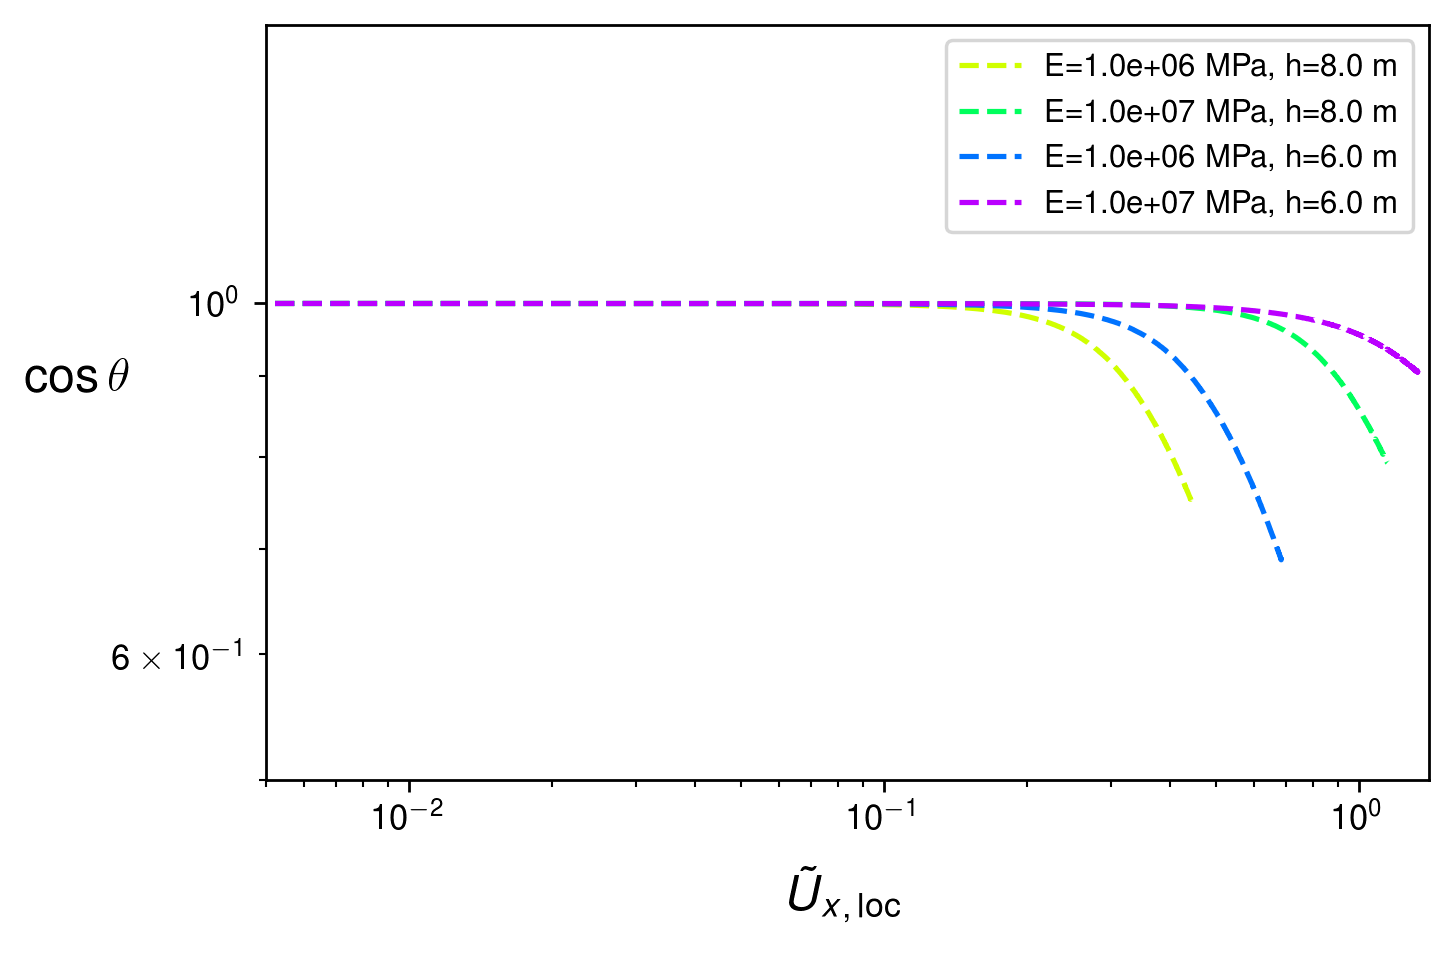

In [74]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-1

ax.loglog(df66_4_rigid['v_loc_smooth'].values[:-200]*0.72,(((df66_4_rigid['costheta'].values[:-200]))),'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['v_loc_smooth'].values[:-190],(((df78_4_rigid['costheta'].values[:-190]))),'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['v_loc_smooth'].values,(((df66_4_rigid['costheta'].values))),'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['v_loc_smooth'].values[:],(((df76_4_rigid['costheta'].values[:]))),'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\cos \theta$',fontsize=14,rotation=0)
#ax.set_xlabel(r'$\phi=(\tilde{U}_{x,\,\mathrm{local}}/\cos^2\,\theta)$',fontsize=14)

ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
ax.set_xlim([5e-3,1.4]) 
ax.set_ylim([0.5,1.5])
ax.legend(loc='nw',fontsize=9)
pylab.show()

## $\alpha_{_{\phi}}=\cos^2\theta$

### $\alpha_{_{\phi}} \ \ $ vs. $ \ \ \tilde{U}_{x}$

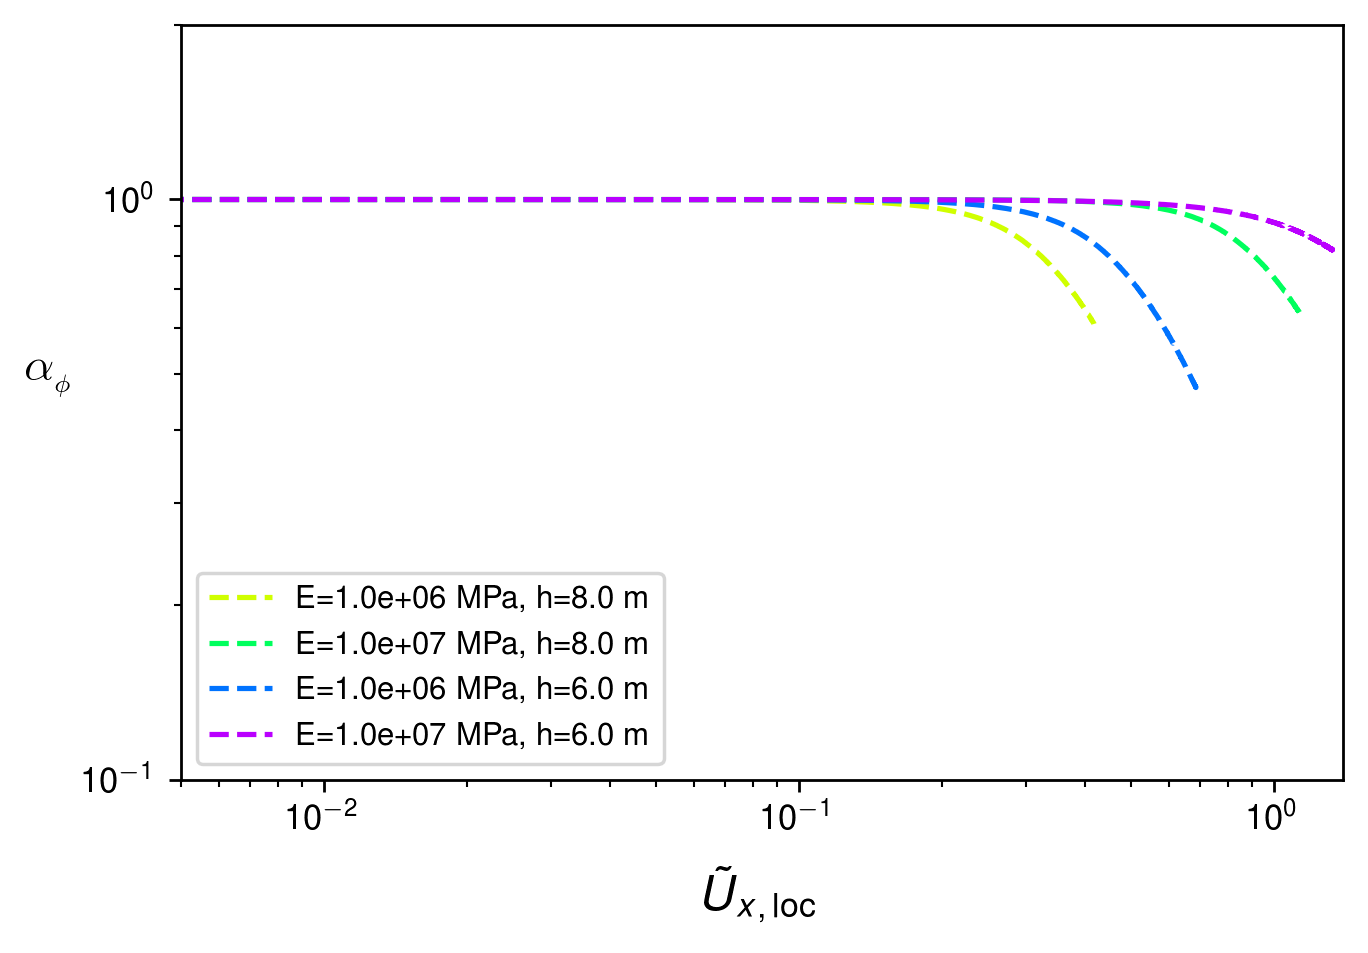

In [75]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-1

ax.loglog(df66_4_rigid['v_loc_smooth'].values[:-300]*0.72,(((df66_4_rigid['costheta'].values[:-300])))**2,'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['v_loc_smooth'].values[:-190],(((df78_4_rigid['costheta'].values[:-190])))**2,'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['v_loc_smooth'].values,(((df66_4_rigid['costheta'].values)))**2,'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['v_loc_smooth'].values[:],(((df76_4_rigid['costheta'].values[:])))**2,'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\alpha_{_{\phi}}$',fontsize=14,rotation=0)
#ax.set_xlabel(r'$\phi=(\tilde{U}_{x,\,\mathrm{local}}/\cos^2\,\theta)$',fontsize=14)

ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
ax.set_xlim([5e-3,1.4]) 
ax.set_ylim([0.1,2])
ax.legend(loc='nw',fontsize=9)
fig.savefig('%s/chapman_fig6_vloc_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

## $\alpha_{_{\phi}} \ \ $ vs. $ \ \ \dfrac{\tilde{U}^2_{x}}{E}$  

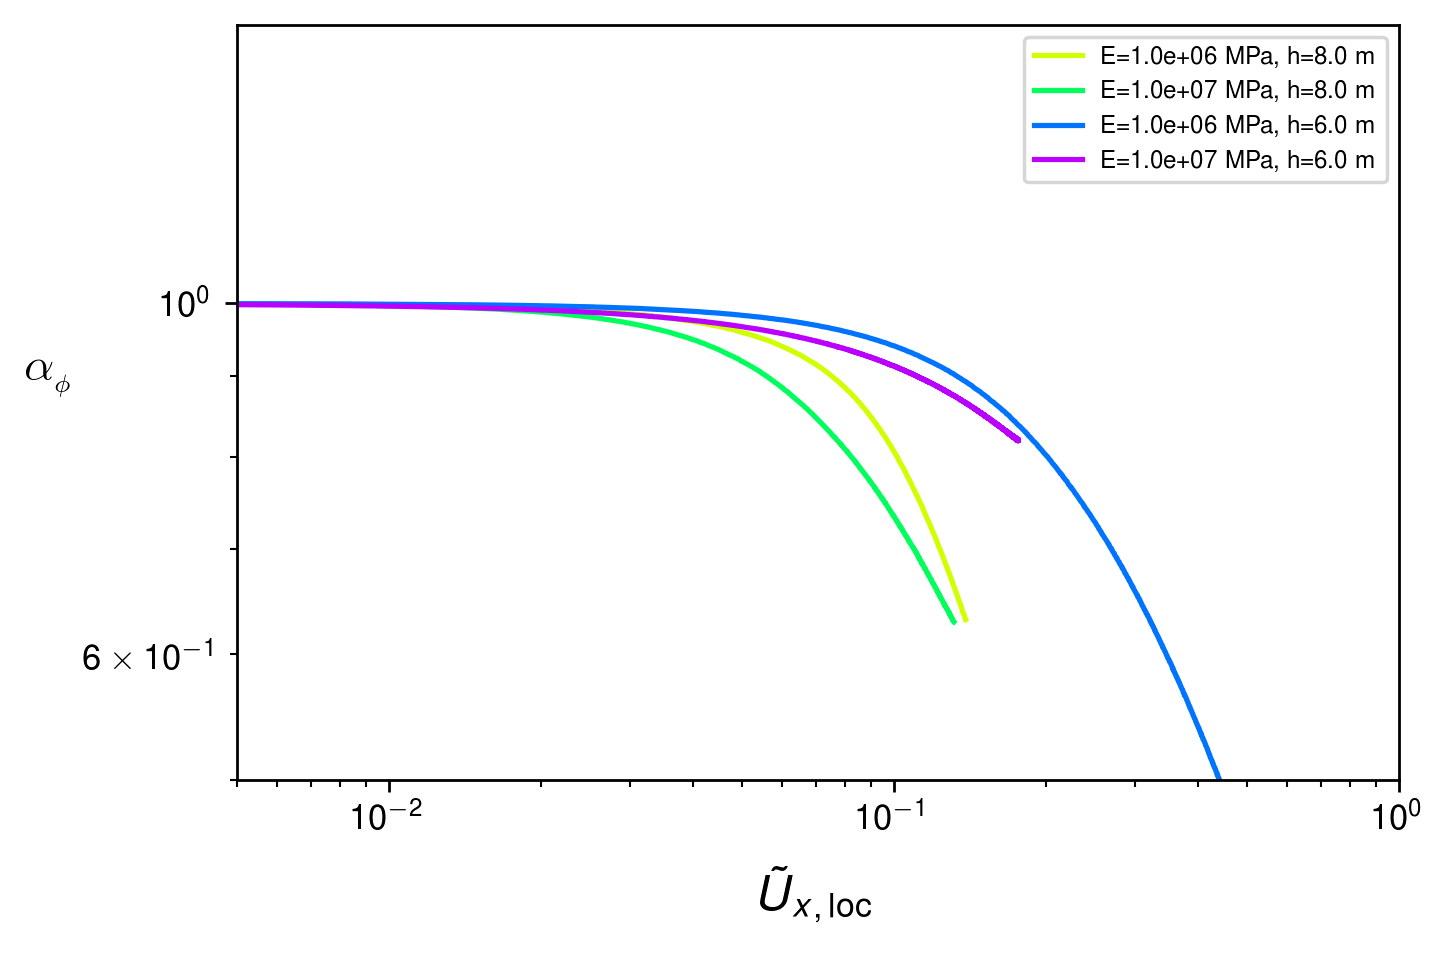

In [76]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-1

ax.loglog(df68_4_rigid['v_loc_smooth'].values[:-10]**2,(((df68_4_rigid['costheta'].values[:-10])))**2,'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(1/10*df78_4_rigid['v_loc_smooth'].values[:-190]**2,(((df78_4_rigid['costheta'].values[:-190])))**2,'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['v_loc_smooth'].values**2,(((df66_4_rigid['costheta'].values)))**2,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(1/10*df76_4_rigid['v_loc_smooth'].values[:]**2,(((df76_4_rigid['costheta'].values[:])))**2,'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\alpha_{_{\phi}}$',fontsize=14,rotation=0)

ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
ax.set_xlim([5e-3,1]) 
ax.set_ylim([0.5,1.5])
ax.legend(loc='nw',fontsize=7)
fig.savefig('%s/chapman_fig6_sq(vloc)_over_E_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

pylab.show()

# $\alpha_{_{\phi}} \ \ $ vs. $ \ \ \dfrac{\tilde{U}^2_{x}}{\big(1-(h/L)\big)^2 E}$  

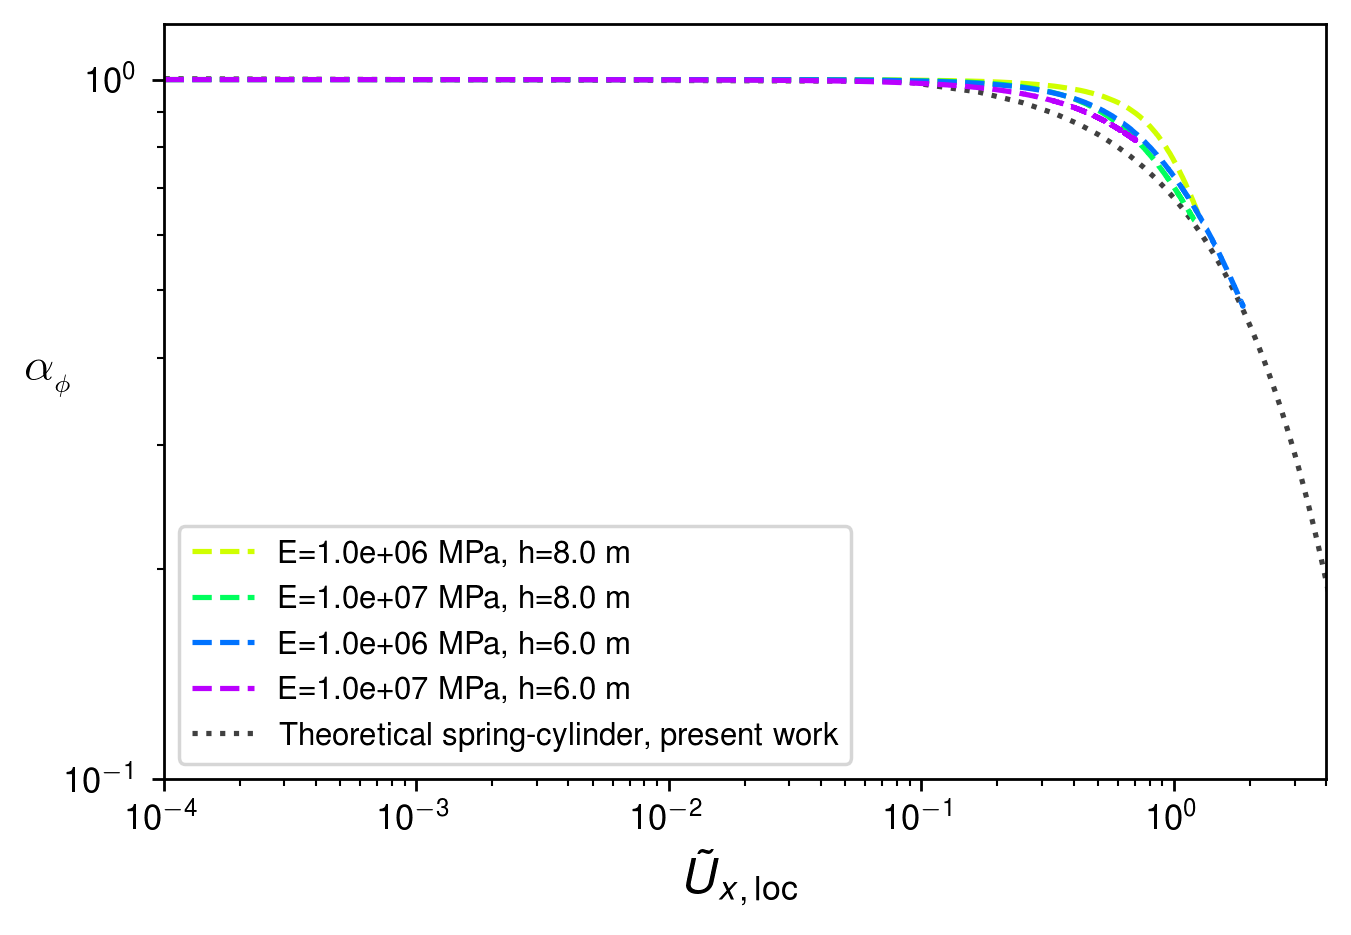

In [77]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-1
pp=-2
ax.loglog(0.33**pp*df68_4_rigid['v_loc_smooth'].values[:-10]**2,(((df68_4_rigid['costheta'].values[:-10])))**2,'--',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(0.33**pp*1/10*df78_4_rigid['v_loc_smooth'].values[:-190]**2,(((df78_4_rigid['costheta'].values[:-190])))**2,'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(0.5**pp*df66_4_rigid['v_loc_smooth'].values**2,(((df66_4_rigid['costheta'].values)))**2,'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(0.5**pp*1/10*df76_4_rigid['v_loc_smooth'].values[:]**2,(((df76_4_rigid['costheta'].values[:])))**2,'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\alpha_{_{\phi}}$',fontsize=14,rotation=0)

ax.set_xlabel(r'$\tilde{U\,}{\!}_{x,\,\mathrm{loc}}$',fontsize=14)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = xx**power
yy = 1.03*np.exp(-0.42*xx)
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label='Theoretical spring-cylinder, present work')

ax.set_xlim([1e-4,4]) 
ax.set_ylim([0.1,1.2])
ax.legend(loc='nw',fontsize=9)
fig.savefig('%s/chapman_fig6_alvarado_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

## $\alpha_{_{\phi}} \ \ $ vs. $ \ \ C_{YS}=\dfrac{\tilde{U}^2_{x}(h/w)^3}{E}$  

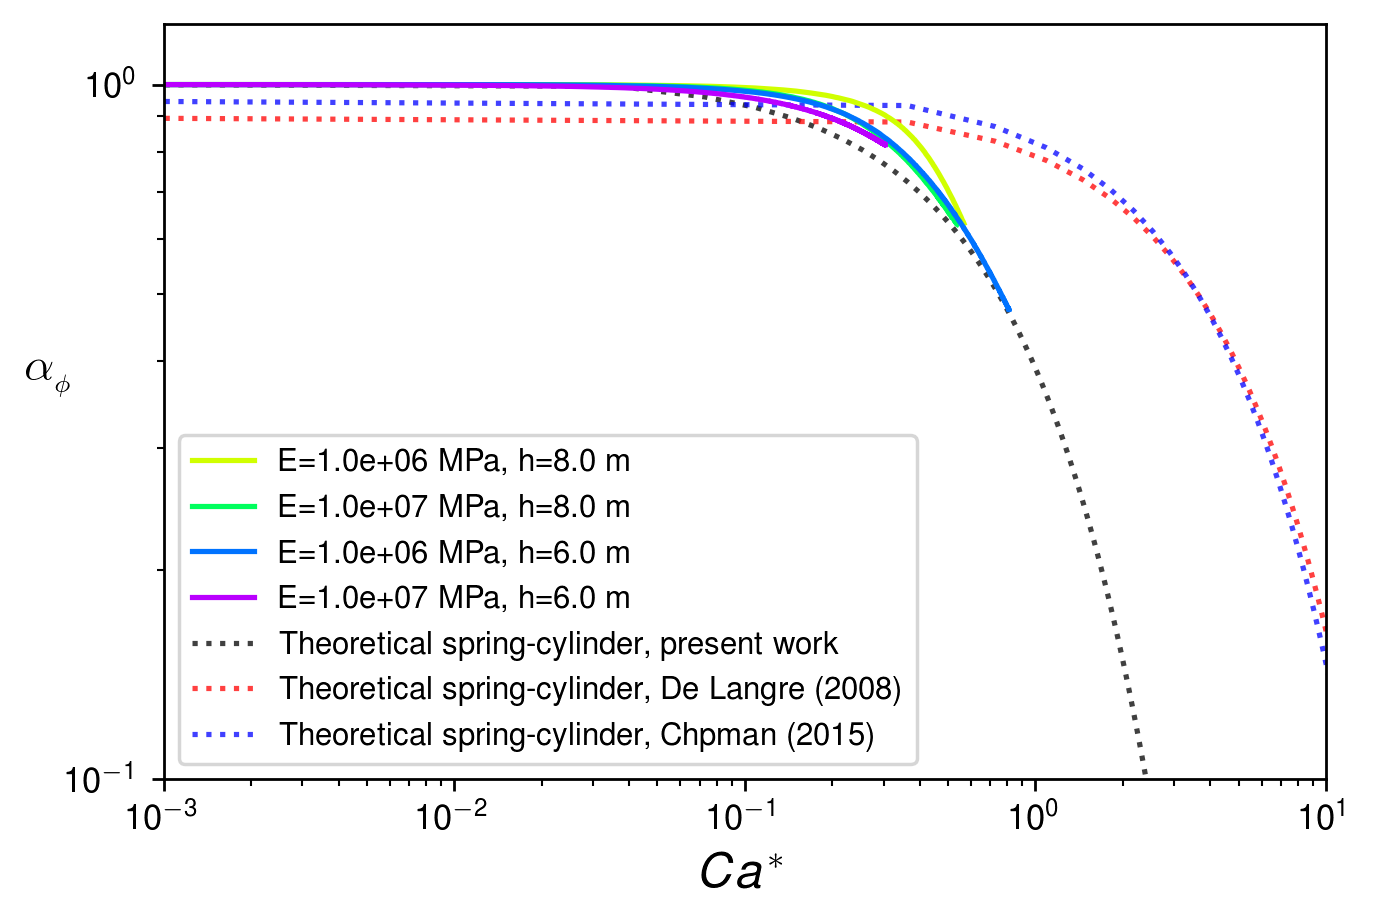

In [91]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-0.5

ax.loglog(df68_4_rigid['Cys'].values[:-10],(((df68_4_rigid['costheta'].values[:-10])))**2,'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['Cys'].values[:-190],(((df78_4_rigid['costheta'].values[:-190])))**2,'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['Cys'].values,(((df66_4_rigid['costheta'].values)))**2,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['Cys'].values[:],(((df76_4_rigid['costheta'].values[:])))**2,'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\alpha_{_{\phi}}$',fontsize=14,rotation=0)

ax.set_xlabel(r'$Ca^{\,{*}}$',fontsize=14)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = xx**power
yy = 1.03*np.exp(-0.97*xx)
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label='Theoretical spring-cylinder, present work')
xx_literature = np.linspace(xmin,xmax*10,100)

yy_delangre08 = 0.941*np.exp(-0.175*xx_literature)
yy_chapman15 = np.exp(-0.192*xx_literature)
ax.loglog(xx_literature,yy_delangre08, 'r:',alpha=0.75, zorder=0,label='Theoretical spring-cylinder, De Langre (2008)')
ax.loglog(xx_literature,yy_chapman15, 'b:',alpha=0.75, zorder=0,label='Theoretical spring-cylinder, Chpman (2015)')
ax.set_xlim([1e-3,10]) 
ax.set_ylim([1e-1,1.22])
ax.legend(loc='nw',fontsize=9)
fig.savefig('%s/chapman_fig6_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

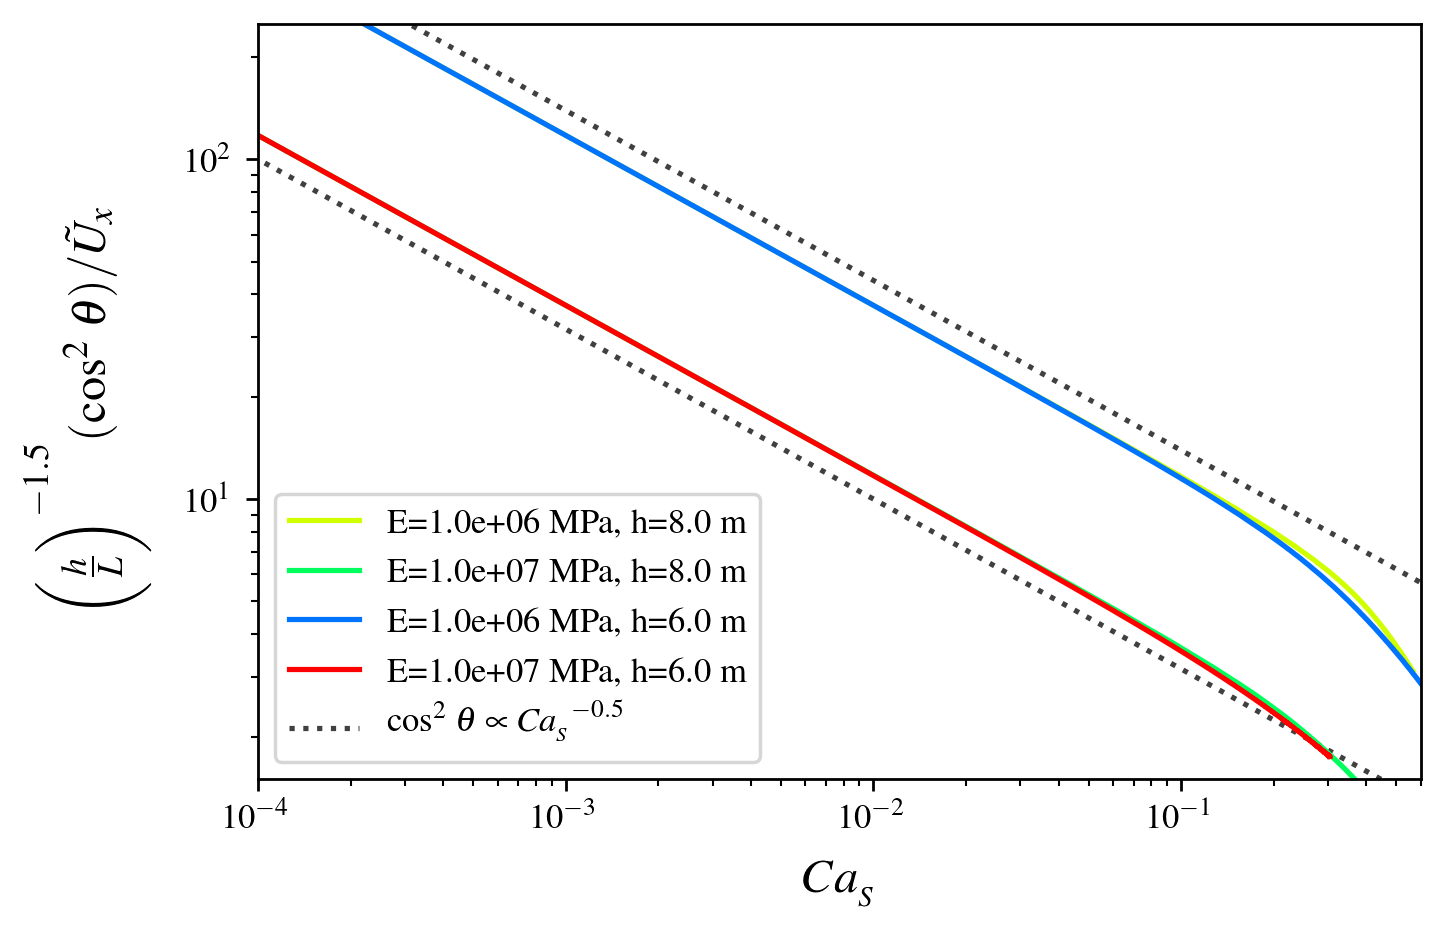

In [599]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-0.5

#ax.loglog(df66_4_rigid['Cys'].values[:-300]*0.7,1.2*(np.cos((df66_4_rigid['costheta'].values[:-300])))**2/df66_4_rigid['v_loc_smooth'].values[:-300],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df68_4_rigid['Cys'].values[:-10],1.5**1.5*(((df68_4_rigid['costheta'].values[:-10])))**2/df68_4_rigid['v_loc_smooth'].values[:-10],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['Cys'].values[:-190],1.5**1.5*(((df78_4_rigid['costheta'].values[:-190])))**2/df78_4_rigid['v_loc_smooth'].values[:-190],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['Cys'].values,2**1.5*(((df66_4_rigid['costheta'].values)))**2/df66_4_rigid['v_loc_smooth'].values,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['Cys'].values[:],2**1.5*(((df76_4_rigid['costheta'].values[:])))**2/df76_4_rigid['v_loc_smooth'].values[:],'-',c='r',mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
#ax.set_ylabel(r'$1/\phi$',fontsize=14)
ax.set_ylabel(r'$\bigg(\frac{h}{L}\bigg)^{-1.5}(\cos^2\,\theta)/\tilde{U}_{x}$',fontsize=14)
#ax.set_xlabel(r'$\phi=(\tilde{U}_{x,\,\mathrm{local}}/\cos^2\,\theta)$',fontsize=14)
ax.set_xlabel(r'$Ca_{_{S}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax/5,100)
yy = xx**power
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$\cos^2\,\theta \propto {Ca_{_{S}}}^{%.1f}$'%power)
yy = 4.4*xx**power
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)
ax.set_xlim([1e-4,6e-1]) 
ax.set_ylim([1.5,2.5e2])
ax.legend(loc='nw')
pylab.show()

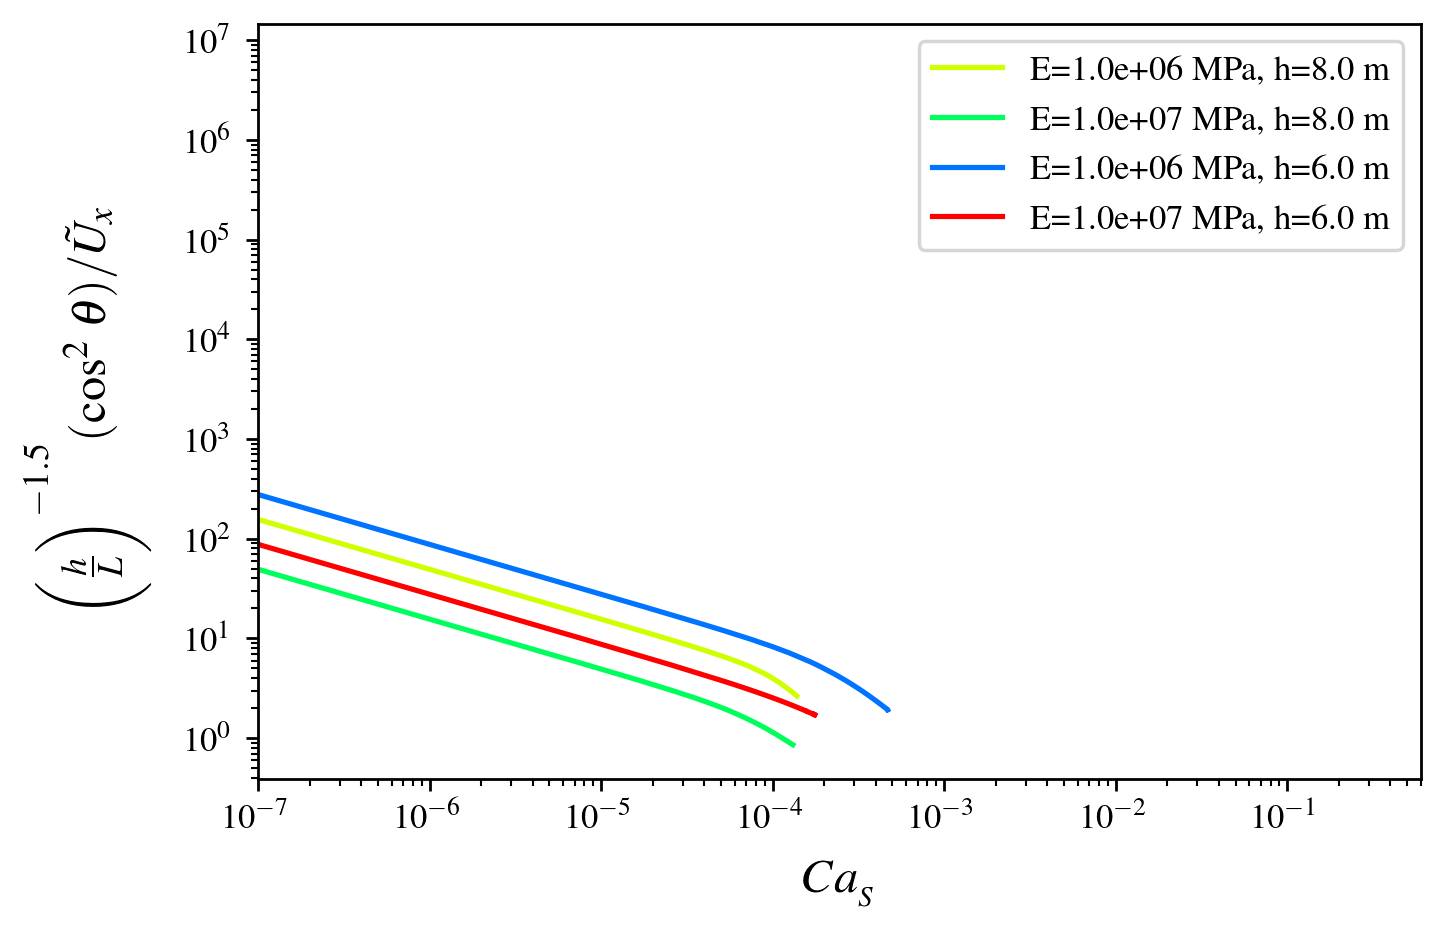

In [600]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-0.5

#ax.loglog(df66_4_rigid['Cys'].values[:-300]*0.7,1.2*(np.cos((df66_4_rigid['costheta'].values[:-300])))**2/df66_4_rigid['v_loc_smooth'].values[:-300],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df68_4_rigid['Cy'].values[:-10],(((df68_4_rigid['costheta'].values[:-10]))/0.8)**2/df68_4_rigid['v_loc_smooth'].values[:-10],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['Cy'].values[:-190],(((df78_4_rigid['costheta'].values[:-190]))/0.8)**2/df78_4_rigid['v_loc_smooth'].values[:-190],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['Cy'].values,(((df66_4_rigid['costheta'].values))/0.6)**2/df66_4_rigid['v_loc_smooth'].values,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['Cy'].values[:],(((df76_4_rigid['costheta'].values[:]))/0.6)**2/df76_4_rigid['v_loc_smooth'].values[:],'-',c='r',mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
#ax.set_ylabel(r'$1/\phi$',fontsize=14)
ax.set_ylabel(r'$\bigg(\frac{h}{L}\bigg)^{-1.5}(\cos^2\,\theta)/\tilde{U}_{x}$',fontsize=14)
#ax.set_xlabel(r'$\phi=(\tilde{U}_{x,\,\mathrm{local}}/\cos^2\,\theta)$',fontsize=14)
ax.set_xlabel(r'$Ca_{_{S}}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
"""xx = np.linspace(xmin,xmax/5,100)
yy = xx**power
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$\cos^2\,\theta \propto {Ca_{_{S}}}^{%.1f}$'%power)
yy = 4.4*xx**power
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)
ax.set_xlim([1e-4,6e-1]) 
ax.set_ylim([1.5,2.5e2])"""
ax.set_xlim([1e-7,6e-1]) 
ax.legend(loc='nw')
pylab.show()

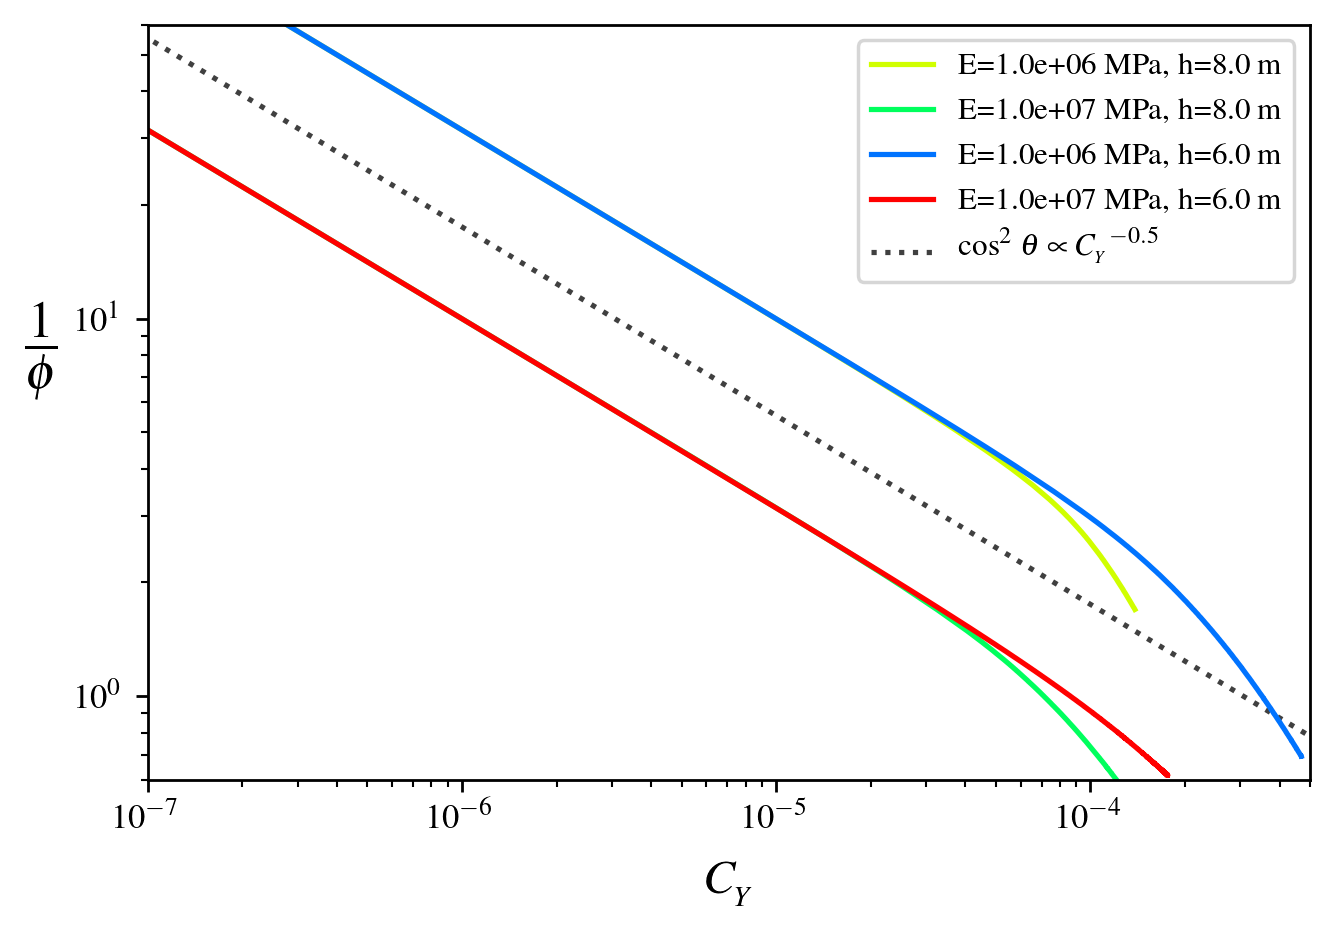

In [602]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=-0.5

#ax.loglog(df66_4_rigid['Cys'].values[:-300]*0.7,1.2*(np.cos((df66_4_rigid['costheta'].values[:-300])))**2/df66_4_rigid['v_loc_smooth'].values[:-300],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df68_4_rigid['Cy'].values[:-10],(((df68_4_rigid['costheta'].values[:-10])))**2/df68_4_rigid['v_loc_smooth'].values[:-10],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78_4_rigid['Cy'].values[:-190],(((df78_4_rigid['costheta'].values[:-190])))**2/df78_4_rigid['v_loc_smooth'].values[:-190],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66_4_rigid['Cy'].values,(((df66_4_rigid['costheta'].values)))**2/df66_4_rigid['v_loc_smooth'].values,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76_4_rigid['Cy'].values[:],(((df76_4_rigid['costheta'].values[:])))**2/df76_4_rigid['v_loc_smooth'].values[:],'-',c='r',mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
#ax.set_ylabel(r'$1/\phi$',fontsize=14)
ax.set_ylabel(r'$\frac{1}{\phi}$',fontsize=20,rotation=0)
#ax.set_xlabel(r'$\phi=(\tilde{U}_{x,\,\mathrm{local}}/\cos^2\,\theta)$',fontsize=14)
ax.set_xlabel(r'$C_{_Y}$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax/2,100)
yy = 1.75e-2*xx**power
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0,label=r'$\cos^2\,\theta \propto {C_{_Y}}^{%.1f}$'%power)
ax.set_xlim([1e-7,5e-4]) 
ax.set_ylim([6e-1,6e1])
ax.legend(loc='nw',fontsize=9)
pylab.show()

In [92]:
rig6 = interpolate.interp1d(dfrigid6['v_loc_smooth'].values**2,dfrigid6['fd_smooth'].values, fill_value='extrapolate')
rig8 = interpolate.interp1d(dfrigid8['v_loc_smooth'].values**2,dfrigid8['fd_smooth'].values, fill_value='extrapolate')
df66_4_rigid['Reconf3']=df66_4_rigid['fd_smooth']/rig6(df66_4_rigid['v_loc_smooth']**2)
df76_4_rigid['Reconf3']=df76_4_rigid['fd_smooth']/rig6(df76_4_rigid['v_loc_smooth']**2)
df68_4_rigid['Reconf3']=df68_4_rigid['fd_smooth']/rig8(df68_4_rigid['v_loc_smooth']**2)
df78_4_rigid['Reconf3']=df78_4_rigid['fd_smooth']/rig8(df78_4_rigid['v_loc_smooth']**2)

In [93]:
ids = np.where(dfrigid8['v_loc_smooth']>0.01)[0]
rig8 = interpolate.interp1d(dfrigid8['v_loc_smooth'][ids]**2,dfrigid8['fd_smooth'][ids], fill_value='extrapolate')
ids = np.where(df68_4_rigid['v_loc_smooth']>0.01)[0]
vel_68 = df68_4_rigid['v_loc_smooth'].values[ids]
f_elas_68 = df68_4_rigid['fd_smooth'].values[ids]
cy_68 = df68_4_rigid['Cys'].values[ids]
f_rig_68 = rig8(vel_68**2)
Reconf_68=f_elas_68/f_rig_68

ids = np.where(df78_4_rigid['v_loc_smooth']>0.01)[0]
vel_78 = df78_4_rigid['v_loc_smooth'].values[ids]
f_elas_78 = df78_4_rigid['fd_smooth'].values[ids]
cy_78 = df78_4_rigid['Cys'].values[ids]
f_rig_78 = rig8(vel_78**2)
Reconf_78=f_elas_78/f_rig_78

ids = np.where(dfrigid6['v_loc_smooth']>0.01)[0]
rig8 = interpolate.interp1d(dfrigid6['v_loc_smooth'][ids]**2,dfrigid6['fd_smooth'][ids], fill_value='extrapolate')
ids = np.where(df66_4_rigid['v_loc_smooth']>0.1)[0]
vel_66 = df66_4_rigid['v_loc_smooth'].values[ids]
f_elas_66 = df66_4_rigid['fd_smooth'].values[ids]
cy_66 = df66_4_rigid['Cys'].values[ids]
f_rig_66 = rig8(vel_66**2)
Reconf_66=f_elas_66/f_rig_66

ids = np.where(df76_4_rigid['v_loc_smooth']>0.01)[0]
vel_76 = df76_4_rigid['v_loc_smooth'].values[ids]
f_elas_76 = df76_4_rigid['fd_smooth'].values[ids]
cy_76 = df76_4_rigid['Cys'].values[ids]
f_rig_76 = rig8(vel_76**2)
Reconf_76=f_elas_76/f_rig_76



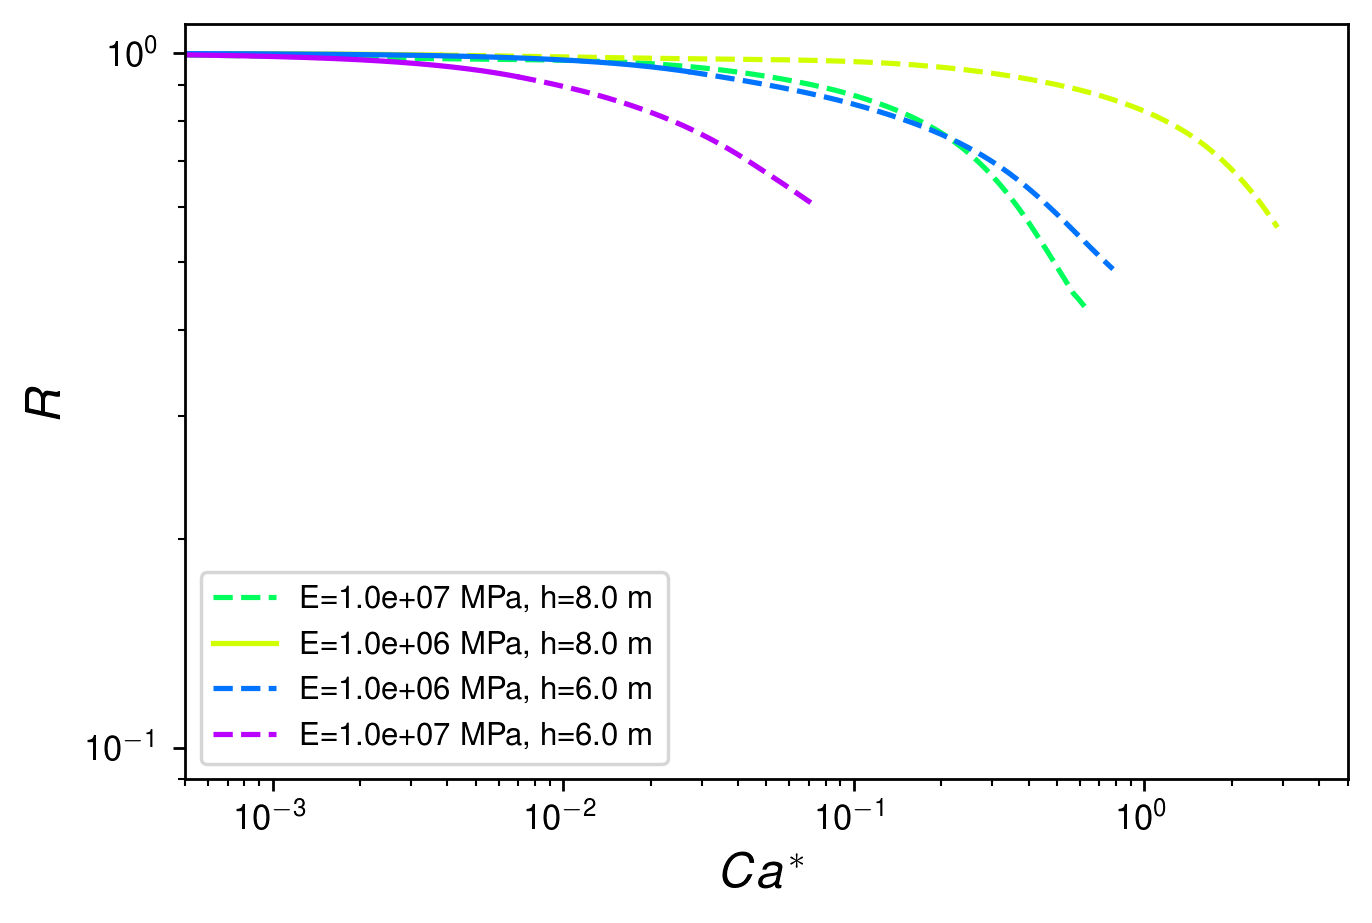

In [96]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
x_78 = np.logspace(-6,-1,1000)
y_78 = np.logspace(6,1,1000)


yy = interpolate.interp1d(cy_78[16:-50],(smooth(Reconf_78,33))[16:-50], fill_value='extrapolate')
xx = np.linspace(1e-4,min(cy_78[16:-50]),1000)
ax.loglog(xx,yy(xx)+1-yy(1e-6),'-',c=cmap(400),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(cy_78[16:-50],(smooth(Reconf_78,33))[16:-50]+1-yy(1e-6),'--',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
xxx78=np.zeros(len(xx)+len(cy_78[16:-50]))
Ryy78=np.zeros(len(xx)+len(cy_78[16:-50]))
xxx78[:1000]=xx
xxx78[1000:]=cy_78[16:-50]
Ryy78[:1000]=yy(xx)+1-yy(1e-6)
Ryy78[1000:]=(smooth(Reconf_78,33))[16:-50]+1-yy(1e-6)

yy = interpolate.interp1d(cy_78[16:-550],(smooth(Reconf_78,33))[16:-550], fill_value='extrapolate')
xx = np.linspace(1e-4,min(cy_78[16:-550]),1000)
ax.loglog(7*cy_78[16:-400],(smooth(Reconf_78,33))[16:-400]+1-yy(1e-6),'--',c=cmap(200),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(7*xx,yy(xx)+1-yy(1e-6),'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
xxx68=np.zeros(len(xx)+len(cy_78[16:-550]))
Ryy68=np.zeros(len(xx)+len(cy_78[16:-550]))
xxx68[:1000]=7*xx
xxx68[1000:]=7*cy_78[16:-550]
Ryy68[:1000]=yy(xx)+1-yy(1e-6)
Ryy68[1000:]=(smooth(Reconf_78,33))[16:-550]+1-yy(1e-6)

yy = interpolate.interp1d(cy_66[16:-50],(smooth(Reconf_66,33))[16:-50], fill_value='extrapolate')
xx = np.linspace(1e-6,min(cy_66[16:-50]),1000)
ax.loglog(xx,yy(xx)+1-yy(1e-6),'-',c=cmap(600),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(cy_66[16:-50],(smooth(Reconf_66,33))[16:-50]+1-yy(1e-6),'--',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
xxx66=np.zeros(len(xx)+len(cy_66[16:-50]))
Ryy66=np.zeros(len(xx)+len(cy_66[16:-50]))
xxx66[:1000]=xx
xxx66[1000:]=cy_66[16:-50]
Ryy66[:1000]=yy(xx)+1-yy(1e-6)
Ryy66[1000:]=(smooth(Reconf_66,33))[16:-50]+1-yy(1e-6)


yy = interpolate.interp1d(cy_76[157:-50],(smooth(Reconf_76,33))[157:-50], fill_value='extrapolate')
xx = np.linspace(1e-6,min(cy_76[157:-50]),1000)
ax.loglog(xx,yy(xx)+1-yy(1e-6),'-',c=cmap(800),mfc='w',markersize=2)#,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(cy_76[157:-3950],(smooth(Reconf_76,33))[157:-3950]+1-yy(1e-6),'--',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
xxx76=np.zeros(len(xx)+len(cy_76[157:-50]))
Ryy76=np.zeros(len(xx)+len(cy_76[157:-50]))
xxx76[:1000]=xx
xxx76[1000:]=cy_76[157:-50]
Ryy76[:1000]=yy(xx)+1-yy(1e-6)
Ryy76[1000:]=(smooth(Reconf_76,33))[157:-50]+1-yy(1e-6)



ax.set_ylabel(r'$R$',fontsize=14)
ax.set_xlabel(r'$Ca^{\,{*}}$',fontsize=14)
ax.set_xlim(5e-4,5)
ax.set_ylim(0.9e-1,1.1)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5
ax.legend(loc='nw',fontsize=9)
fig.savefig('%s/leclercq16_fig3b_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

##  For the sake of clarity, the velocity and drag data have been normalized by the value of the first point where significant reconfiguration was evident. Then, the Vogel exponent is calculated from data above this point

In [97]:
dx = np.diff(np.log(xxx66))
dy = np.diff(np.log(Ryy66))
dydx=dy/dx
derY_66=xxx66*0
derY_66[1:]=dydx
dx = np.diff(np.log(xxx68))
dy = np.diff(np.log(Ryy68))
dydx=dy/dx
derY_68=xxx68*0
derY_68[1:]=dydx
dx = np.diff(np.log(xxx76[:-3700]))
dy = np.diff(np.log(Ryy76[:-3700]))
dydx=dy/dx
derY_76=xxx76[:-3700]*0
derY_76[1:]=dydx
dx = np.diff(np.log(xxx78))
dy = np.diff(np.log(Ryy78))
dydx=dy/dx
derY_78=xxx78*0
derY_78[1:]=dydx

In [98]:
dx = np.diff(np.log(cy_66))
dy = np.diff(np.log(Reconf_66))
dydx=dy/dx
dY_66=cy_66*0
dY_66[1:]=dydx
dx = np.diff(np.log(cy_76))
dy = np.diff(np.log(Reconf_76))
dydx=dy/dx
dY_76=cy_76*0
dY_76[1:]=dydx
dx = np.diff(np.log(cy_68))
dy = np.diff(np.log(Reconf_68))
dydx=dy/dx
dY_68=cy_68*0
dY_68[1:]=dydx
dx = np.diff(np.log(cy_78))
dy = np.diff(np.log(Reconf_78))
dydx=dy/dx
dY_78=cy_78*0
dY_78[1:]=dydx

In [99]:
nsamp=20
window_length = len(dY_78[::nsamp])-3+len(dY_78[::nsamp])%2
amin=np.argmin(smooth(savgol_filter(dY_78[::nsamp],window_length,3),3))
id_start = int(np.ceil((len(dY_78[::nsamp])+amin)/2))
ntail=20
ddy78=np.zeros(id_start+ntail)
ccy78=np.zeros(id_start+ntail)
ccy78[:id_start]=smooth(savgol_filter(cy_78[::nsamp],window_length,3),3)[:id_start]
ccy78[id_start:]=ccy78[:id_start][-1]+np.linspace(0,1,ntail)
ddy78[:id_start]=smooth(savgol_filter(dY_78[::nsamp],window_length,3),3)[:id_start]
ddy78[id_start:]=smooth(savgol_filter(dY_78[::nsamp],window_length,3),3)[id_start-1]-0.02/(np.linspace(1,0.1,ntail)[::-1])
ddy78[id_start:]+= ddy78[id_start-1]-ddy78[id_start]

In [100]:
nsamp=10
window_length = len(dY_66[::nsamp])-3+len(dY_66[::nsamp])%2
amin=np.argmin(smooth(savgol_filter(dY_66[::nsamp],window_length,3),3))
id_start = int(np.ceil((len(dY_66[::nsamp])+amin)/2))
ntail=60
ddy66=np.zeros(id_start+ntail)
ccy66=np.zeros(id_start+ntail)
ccy66[:id_start]=smooth(savgol_filter(cy_66[::nsamp],window_length,3),3)[:id_start]
ccy66[id_start:]=ccy66[:id_start][-1]+np.linspace(0,1,ntail)
ddy66[:id_start]=smooth(savgol_filter(dY_66[::nsamp],window_length,3),3)[:id_start]
ddy66[id_start:]=smooth(savgol_filter(dY_66[::nsamp],window_length,3),3)[id_start-1]-0.02/(np.linspace(1,0.1,ntail)[::-1])
ddy66[id_start:]+= ddy66[id_start-1]-ddy66[id_start]
ytemp_terp = interpolate.interp1d(ccy66,ddy66, fill_value='extrapolate')
xx=np.linspace(1e-6,ccy66[-1],1000)
ddy66=ytemp_terp(xx)
ccy66=xx

In [101]:
xtemp=xxx76[:-3700]
ytemp=smooth(savgol_filter(derY_76,5,3),47)
index=np.where(np.isnan(ytemp))[0][-1]+1
ytemp_terp = interpolate.interp1d(xtemp[index:],ytemp[index:], fill_value='extrapolate')
xx = np.linspace(1e-6,xtemp[-1],4000)
nsamp=1
window_length = 21
amin=np.argmin(ytemp_terp(xx))
id_start = int(np.ceil((len(ytemp_terp(xx)[::nsamp])+amin)/2))
ntail=20
ddy76=np.zeros(id_start+ntail)
ccy76=np.zeros(id_start+ntail)
ccy76[:id_start]=smooth(savgol_filter(xx[::nsamp],window_length,3),3)[:id_start]
ccy76[id_start:]=ccy76[:id_start][-1]+np.linspace(0,0.2,ntail)
ddy76[:id_start]=smooth(savgol_filter(ytemp_terp(xx)[::nsamp],window_length,3),3)[:id_start]
ddy76[id_start:]=smooth(savgol_filter(ytemp_terp(xx)[::nsamp],window_length,3),3)[id_start-1]-0.006/(np.linspace(1,0.1,ntail)[::-1])
ddy76[id_start:]+= ddy76[id_start-1]-ddy76[id_start]
ddy76*= 2
ddy76-= ddy76[0]

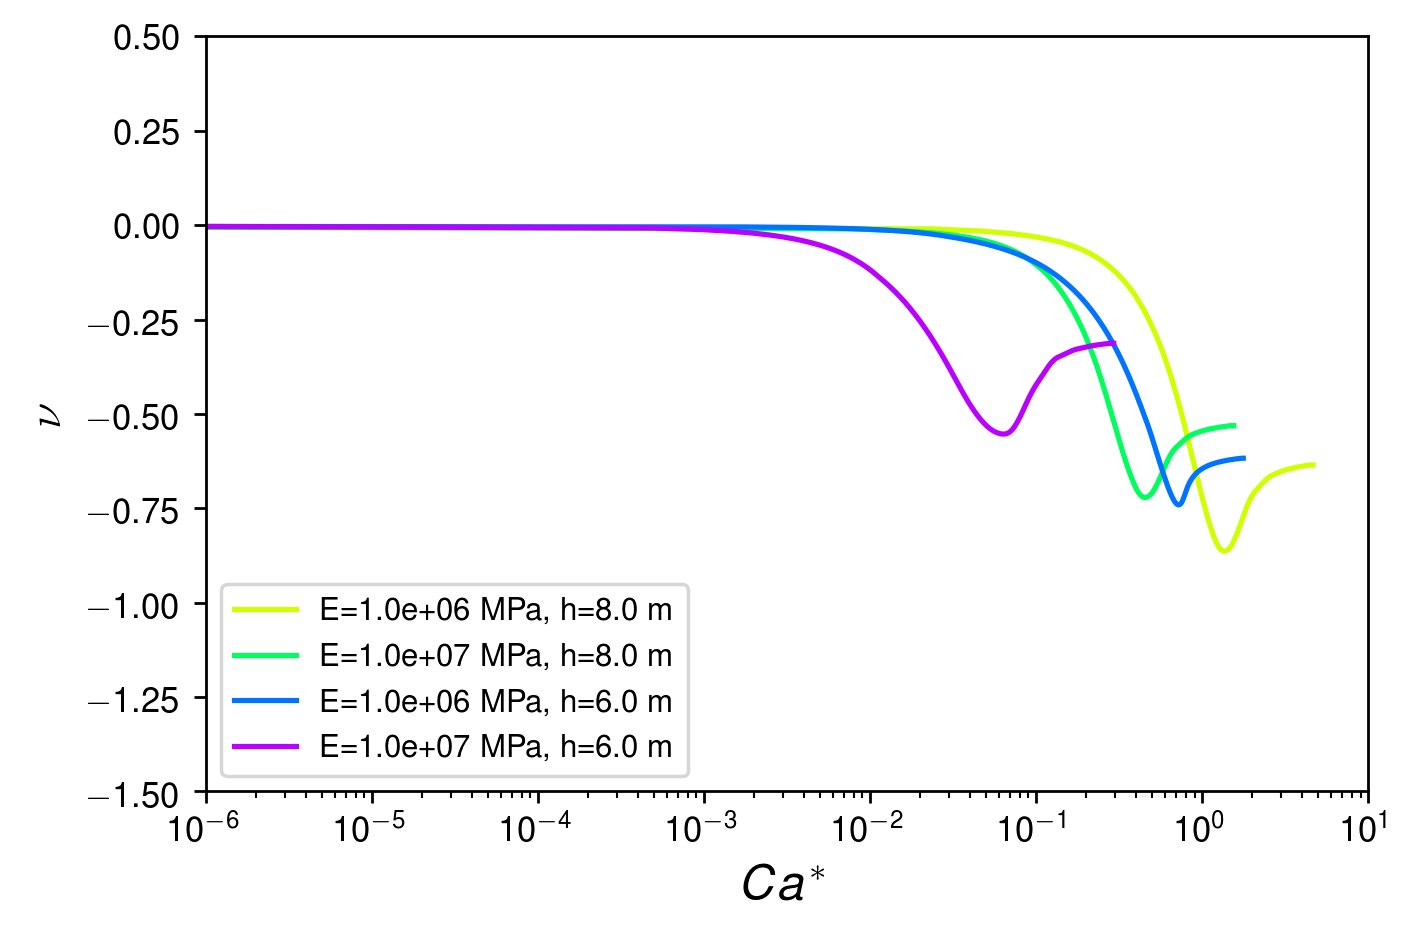

In [115]:
xx = ccy78[::4]
yy = ddy78[::4]
ytemp_terp = interpolate.interp1d(xx,yy, fill_value='extrapolate')
xx78 = np.linspace(1e-6,ccy78[-1],200)
yy78 = smooth(ytemp_terp(xx78),23)
yy78[-11:] = yy78[-12]*np.ones(11)
xx68 = 3*xx78
yy68 = 1.2*yy78
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
xx = ccy76[::4]
yy = ddy76[::4]
ytemp_terp = interpolate.interp1d(xx,yy, fill_value='extrapolate')
xx76 = np.linspace(1e-6,ccy76[-1],600)
yy76 = smooth(ytemp_terp(xx76),45)
yy76[-29:] = yy76[-30]*np.ones(29)
xx = ccy66[::18]
yy = ddy66[::18]
ytemp_terp = interpolate.interp1d(xx,yy, fill_value='extrapolate')
xx66 = np.linspace(1e-6,ccy66[-1],1000)
yy66 = smooth(ytemp_terp(xx66),35)
yy66[-19:] = yy66[-20]*np.ones(19)
ax.semilogx(xx68,yy68/1.4+0.02,'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.semilogx(xx78,yy78/1.4+0.015,'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.semilogx(xx66,yy66/1.6+0.01,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.semilogx(xx76,yy76/0.85+0.05,'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\nu$',fontsize=14)
ax.set_xlabel(r'$Ca^{\,{*}}$',fontsize=14)
ax.legend(loc='best',fontsize=9)
ax.set_xlim(1e-6,10)
ax.set_ylim(-1.5,0.5)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5

fig.savefig('%s/leclercq16_fig3c_vogel_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)
pylab.show()

array([ 0.00417692, -0.67993546, -1.04586275, -0.77761197])

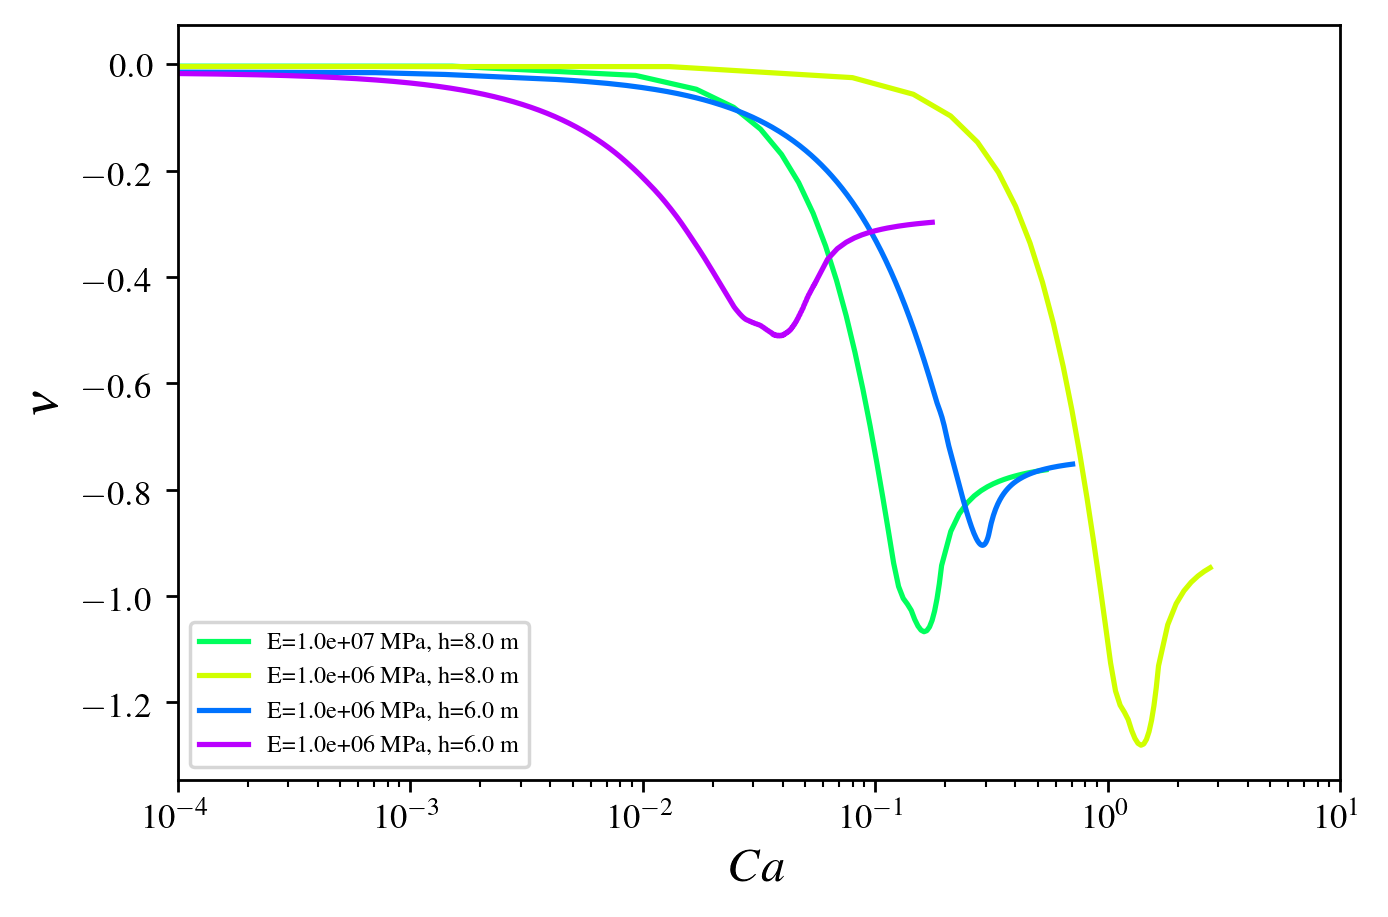

In [314]:
# Z vs. v
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
ax.semilogx(0.35*ccy78,ddy78,'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.semilogx(3*ccy78[:-12],1.2*ddy78[:-12],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.semilogx(0.4*ccy66,0.75*ddy66,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.semilogx(0.6*ccy76,0.01+ddy76,'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.set_ylabel(r'${\nu}$',fontsize=14)
ax.set_xlabel(r'$Ca$',fontsize=14)
ax.legend(loc='best',fontsize=7)
ax.set_xlim(1e-4,10)
fig.savefig('%s/leclercq16_fig3c_vogel_loglog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

pylab.show()

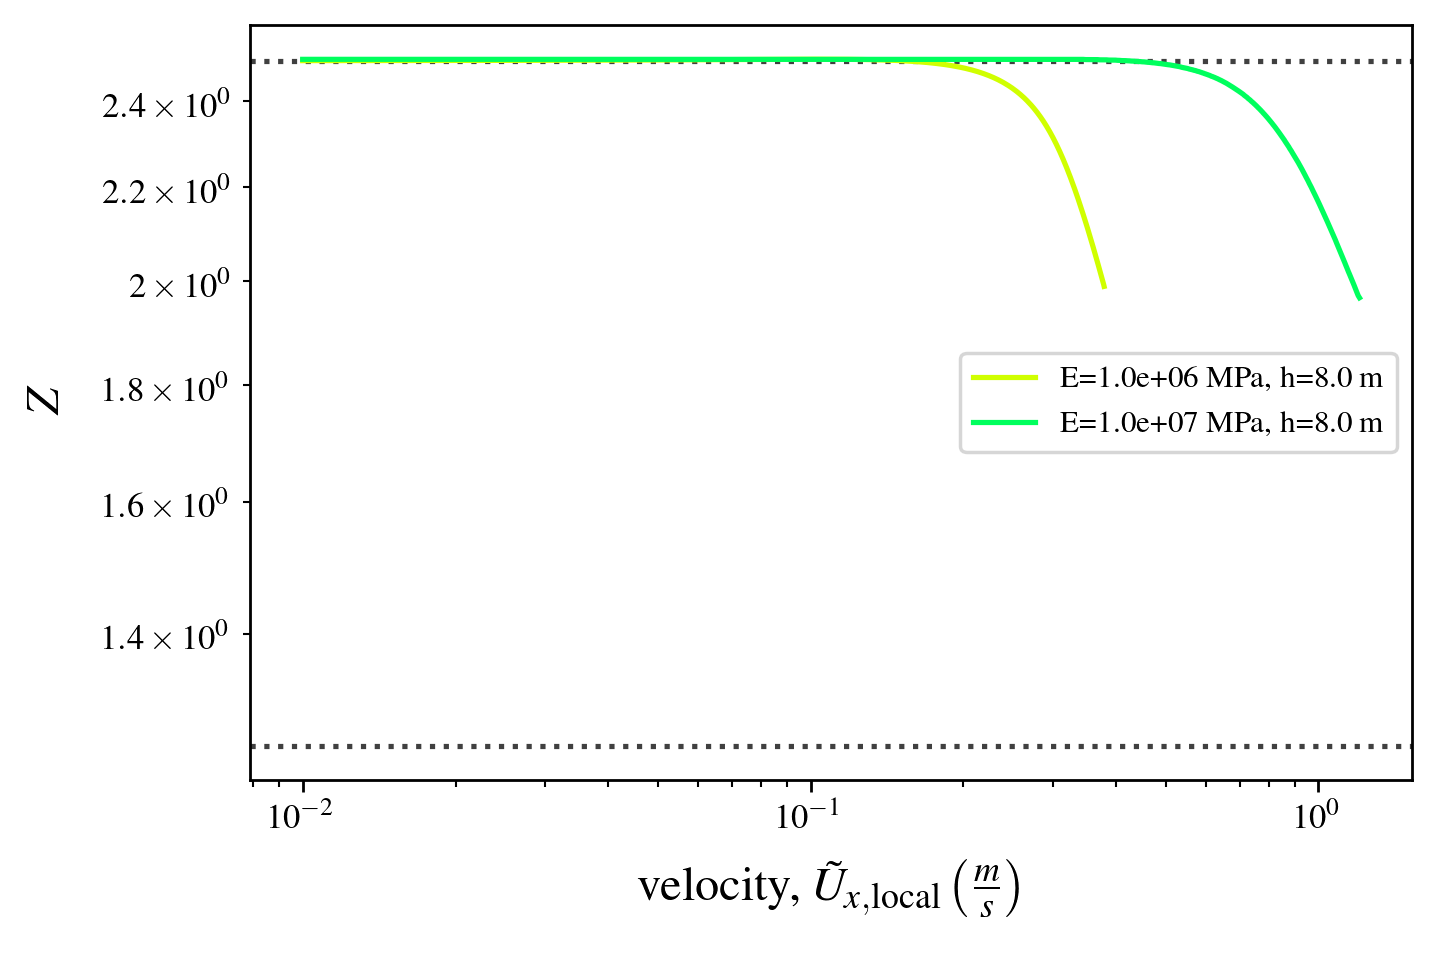

In [158]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
ytemp_terp = interpolate.interp1d(df68['v_loc_smooth'],1/df68['gap'], fill_value='extrapolate')
xx=np.linspace(1e-2,df68['v_loc_smooth'].values[-1],1000)
yy=ytemp_terp(xx)
ax.semilogx(xx,yy,'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ytemp_terp = interpolate.interp1d(df78['v_loc_smooth'],1/df78['gap'], fill_value='extrapolate')
xx=np.linspace(1e-2,df78['v_loc_smooth'].values[-1],1000)
yy=ytemp_terp(xx)
ax.semilogx(xx[:-70],yy[:-70],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.set_ylabel(r'${Z}$',fontsize=14)
ax.set_xlabel('velocity, '+r'$\tilde{U}_{x,\mathrm{local}} \, \big(\frac{m}{s}\big)$',fontsize=14)
ax.legend(loc='west',fontsize=9)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = 1/0.4*np.ones(len(xx))
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)#,label=r'$\cos^2\,\theta \propto {C_{_Y}}^{%.1f}$'%power)
yy=1/0.8*np.ones(len(xx))
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)#,label=r'$\cos^2\,\theta \propto {C_{_Y}}^{%.1f}$'%power)
#ax.legend(loc='l',fontsize=7)
ax.set_xlim([xx[0], xx[-1]])
fig.savefig('%s/alvarado17_fig2b_semilog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

pylab.show()

In [179]:
df76_4_rigid_temp = df76_4_rigid[['fd_smooth','gap','v_loc_smooth']].dropna(how='any',axis=0)
df66_4_rigid_temp = df66_4_rigid[['fd_smooth','gap','v_loc_smooth']].dropna(how='any',axis=0)
df78_4_rigid_temp = df78_4_rigid[['fd_smooth','gap','v_loc_smooth']].dropna(how='any',axis=0)
df68_4_rigid_temp = df68_4_rigid[['fd_smooth','gap','v_loc_smooth']].dropna(how='any',axis=0)

In [171]:
df76_4_rigid_temp

,fd_smooth,gap,v_loc_smooth
0,-0.00000,0.60000,0.00000
1,-0.00000,0.60000,0.00000
2,-0.00000,0.60000,0.00000
3,-0.00000,0.60000,0.00000
4,0.00000,0.60000,0.00000
...,...,...,...
4495,0.44865,0.63130,1.32678
4496,0.44868,0.63130,1.32676
4497,0.44870,0.63130,1.32674
4498,0.44873,0.63130,1.32671


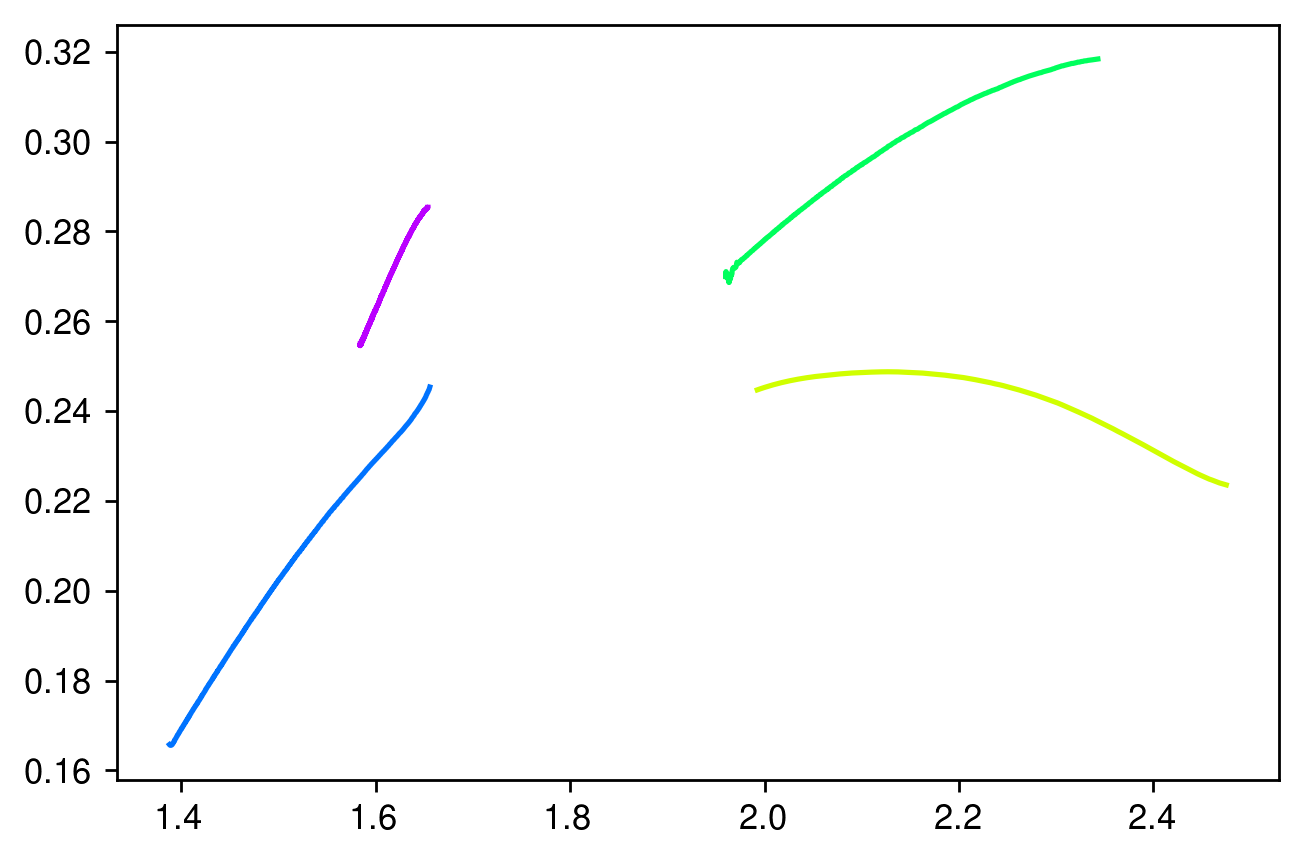

In [189]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
#ax.plot((1/df68_4_rigid['gap'])[120:256],(df68_4_rigid['fd_smooth']/df68_4_rigid['v_loc_smooth']**2)[120:256],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
#ax.plot((1/df78_4_rigid['gap'])[220:-100],(df78_4_rigid['fd_smooth']/df78_4_rigid['v_loc_smooth']**2)[220:-100],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
#ax.plot((1/df66_4_rigid['gap'])[320:-1],(df66_4_rigid['fd_smooth']/df66_4_rigid['v_loc_smooth']**2)[320:-1],'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.plot(((1/df76_4_rigid_temp['gap'])[800:-1]),((df76_4_rigid_temp['fd_smooth']/df76_4_rigid_temp['v_loc_smooth']**2)[800:-1]),'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.plot(((1/df66_4_rigid_temp['gap']))[310:-1],((df66_4_rigid_temp['fd_smooth']/df66_4_rigid_temp['v_loc_smooth']**2))[310:-1],'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.plot(((1/df78_4_rigid_temp['gap']))[320:-100],((df78_4_rigid_temp['fd_smooth']/df78_4_rigid_temp['v_loc_smooth']**2))[320:-100],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.plot(((1/df68_4_rigid_temp['gap']))[120:-1],((df68_4_rigid_temp['fd_smooth']/df68_4_rigid_temp['v_loc_smooth']**2))[120:-1],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
#ax.set_ylim([0.1,0.3])
pylab.show()

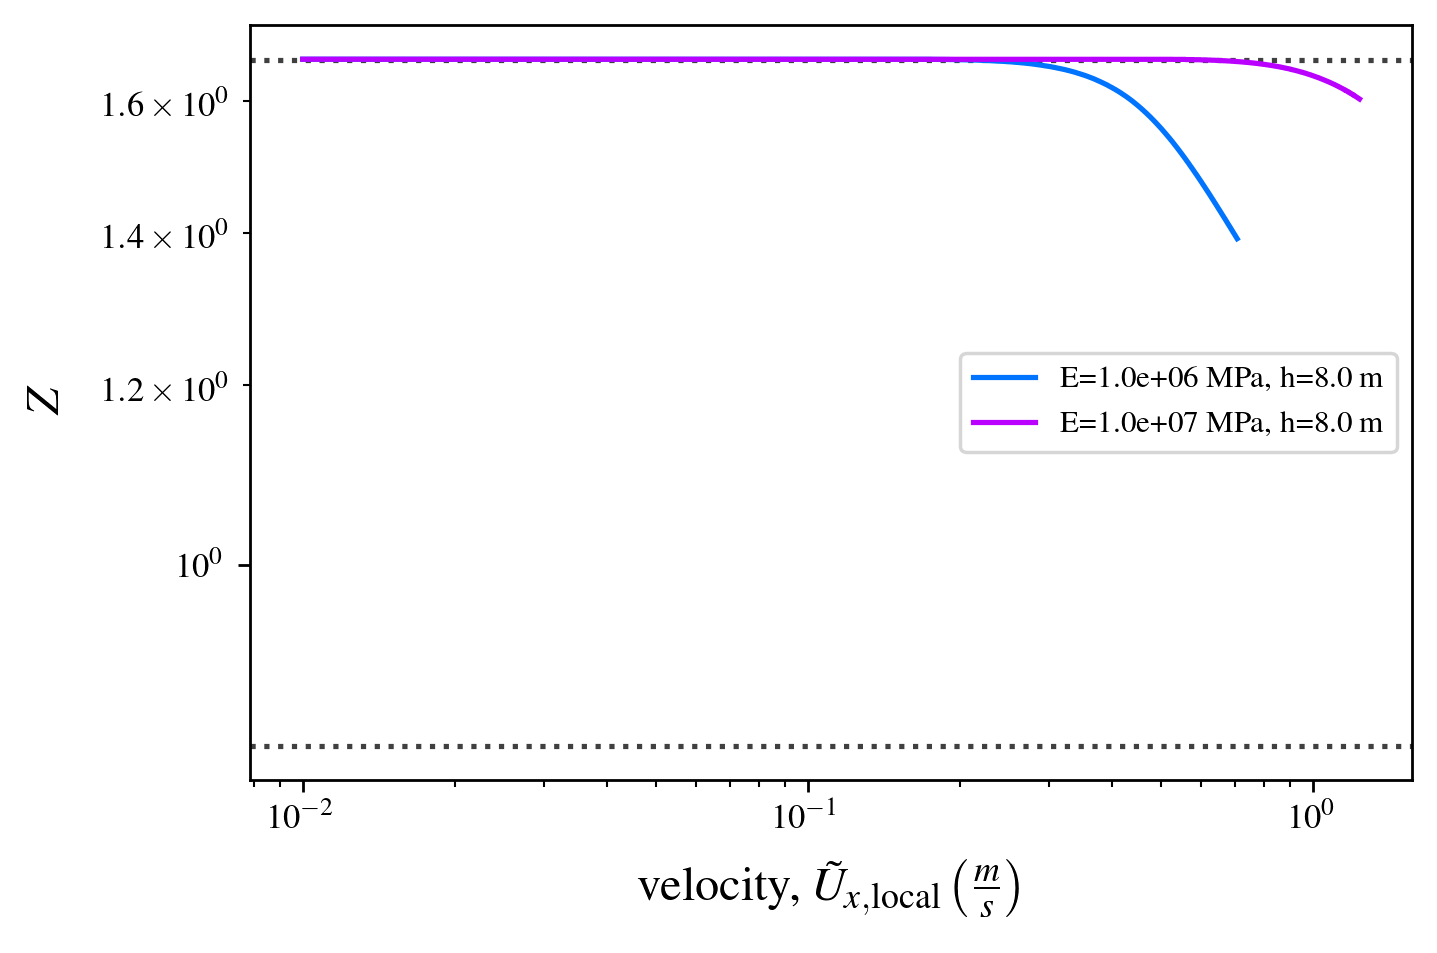

In [162]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
ytemp_terp = interpolate.interp1d(df66['v_loc_smooth'],1/df66['gap'], fill_value='extrapolate')
xx=np.linspace(1e-2,df66['v_loc_smooth'].values[-1],1000)
yy=ytemp_terp(xx)
ax.semilogx(xx,yy,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ytemp_terp = interpolate.interp1d(df76['v_loc_smooth'],1/df76['gap'], fill_value='extrapolate')
xx=np.linspace(1e-2,df76['v_loc_smooth'].values[-1],1000)
yy=ytemp_terp(xx)
ax.semilogx(xx[:-70],yy[:-70],'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.set_ylabel(r'${Z}$',fontsize=14)
ax.set_xlabel('velocity, '+r'$\tilde{U}_{x,\mathrm{local}} \, \big(\frac{m}{s}\big)$',fontsize=14)
ax.legend(loc='west',fontsize=9)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
xmin = ax.get_xlim()[0]
ymin = ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
xx = np.linspace(xmin,xmax,100)
yy = 1/0.6*np.ones(len(xx))
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)#,label=r'$\cos^2\,\theta \propto {C_{_Y}}^{%.1f}$'%power)
yy=1/1.2*np.ones(len(xx))
ax.loglog(xx,yy, 'k:',alpha=0.75, zorder=0)#,label=r'$\cos^2\,\theta \propto {C_{_Y}}^{%.1f}$'%power)
#ax.legend(loc='l',fontsize=7)
ax.set_xlim([xx[0], xx[-1]])
fig.savefig('%s/alvarado17_fig2b2_semilog.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

pylab.show()

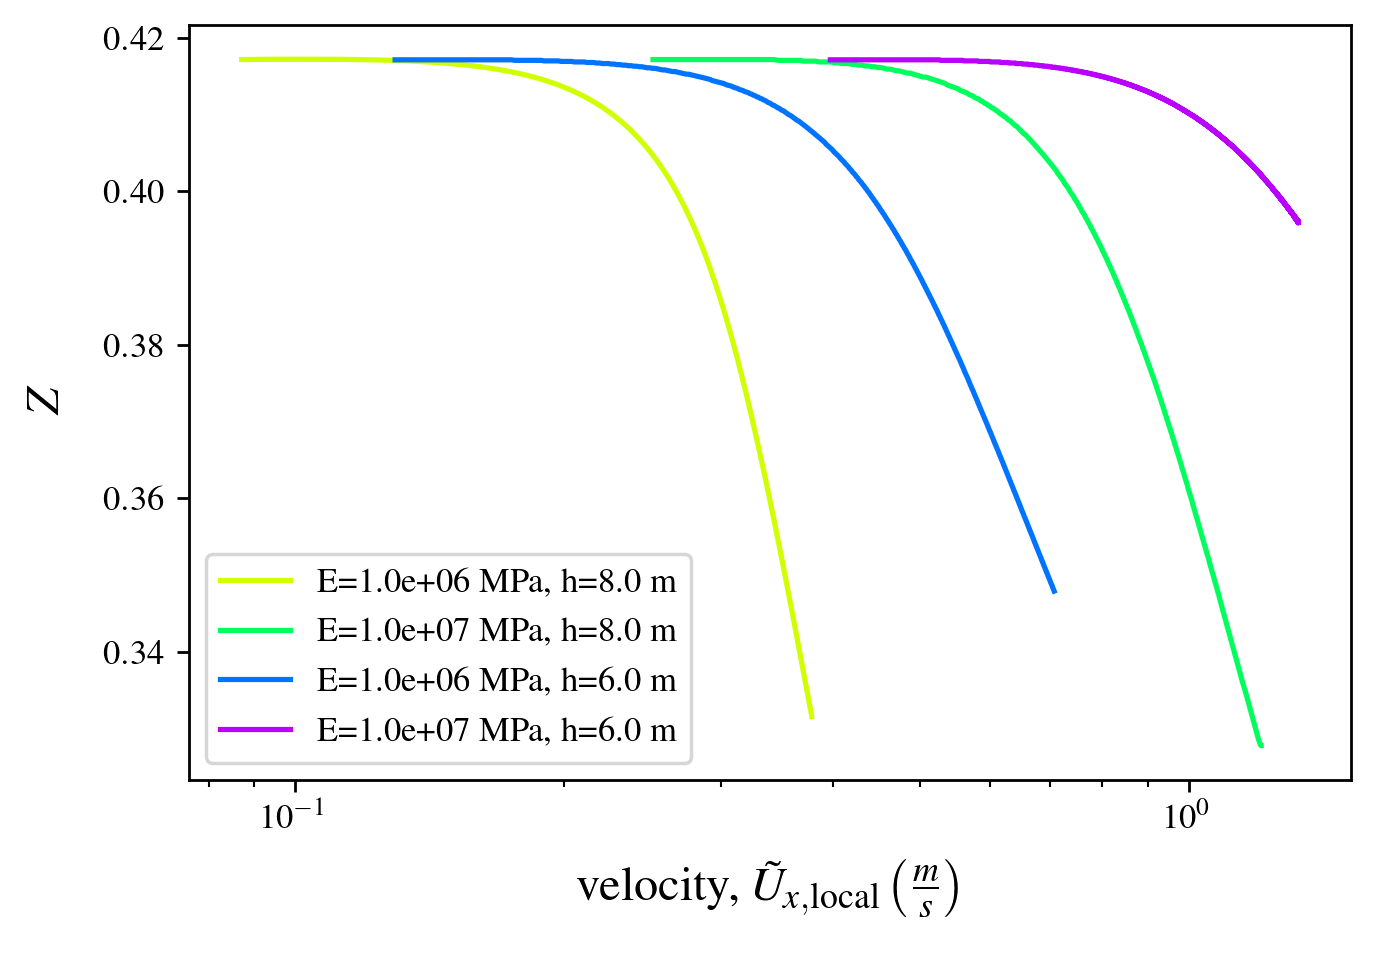

In [1105]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
origin=df68['v_loc_smooth'].values[0]
shift68=0
shift78=0
shift66=0
shift76=0
ax.semilogx(df68['v_loc_smooth'],1/df68['gap']/6,'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.semilogx(df78['v_loc_smooth'][:-120],1/df78['gap'][:-120]/6,'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.semilogx(df66['v_loc_smooth'],1/df66['gap']/4,'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.semilogx(df76['v_loc_smooth'],1/df76['gap']/4,'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'${Z}$',fontsize=14)
ax.set_xlabel('velocity, '+r'$\tilde{U}_{x,\mathrm{local}} \, \big(\frac{m}{s}\big)$',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.legend(loc='nw')
pylab.show()

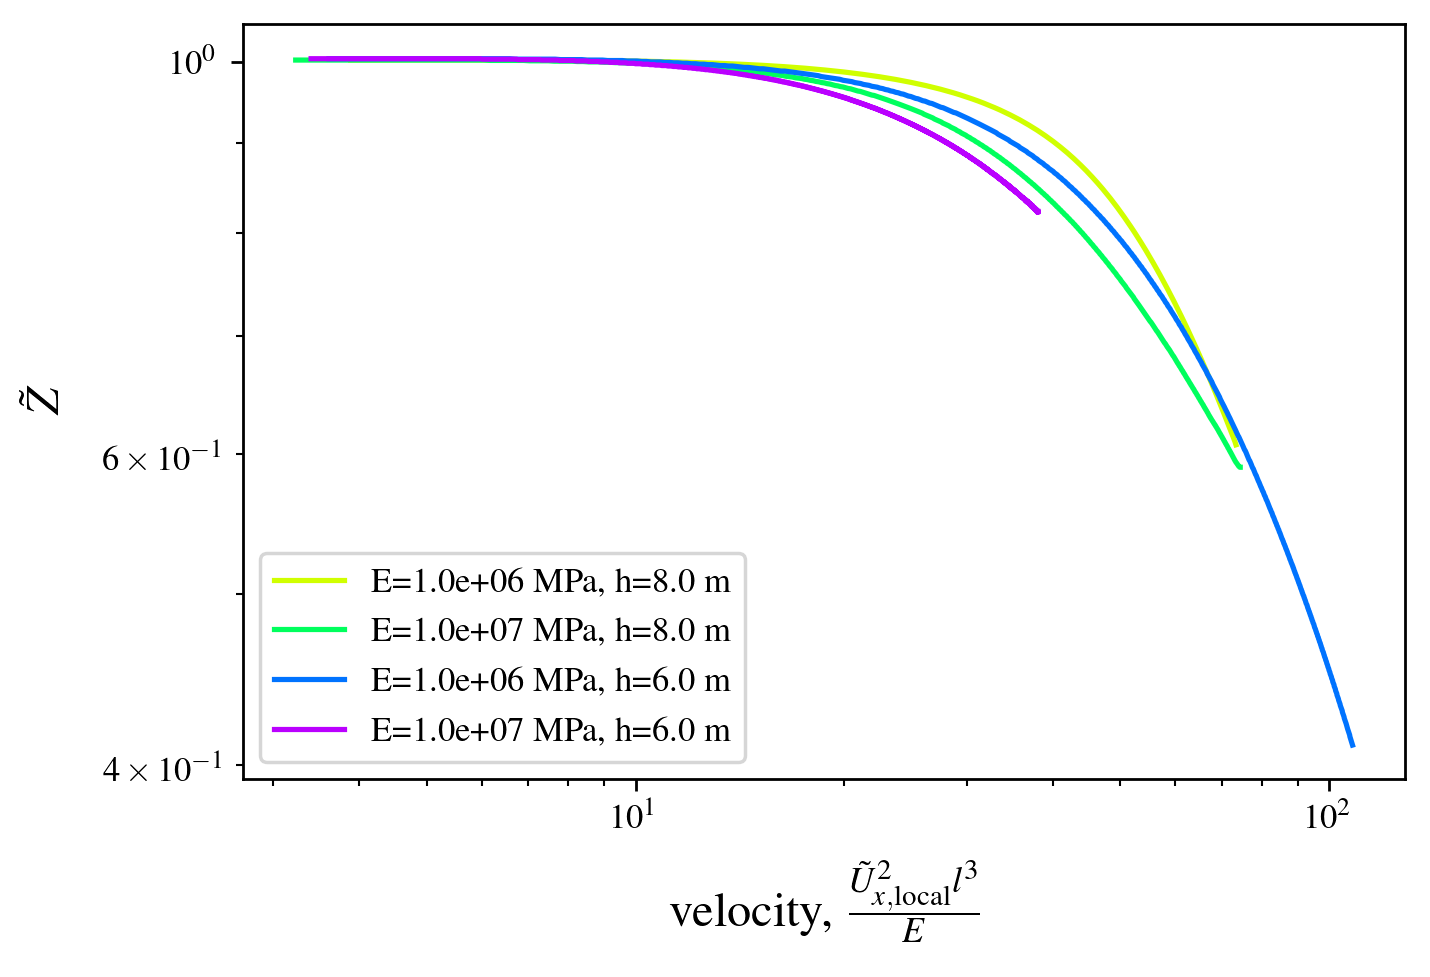

In [1125]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
origin=df68['v_loc_smooth'].values[0]
ax.loglog(df68['v_loc_smooth']**2*8**3,df68['Z_tilde_gap_L'],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78['v_loc_smooth'][:-120]**2*8**3/10,df78['Z_tilde_gap_L'][:-120],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66['v_loc_smooth']**2*6**3,df66['Z_tilde_gap_L'],'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76['v_loc_smooth']**2*6**3/10,df76['Z_tilde_gap_L'],'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\tilde{Z}$',fontsize=14)
ax.set_xlabel('velocity, '+r'$\frac{\tilde{U}^2_{x,\mathrm{local}}l^3}{E} $',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.legend(loc='nw')
pylab.show()

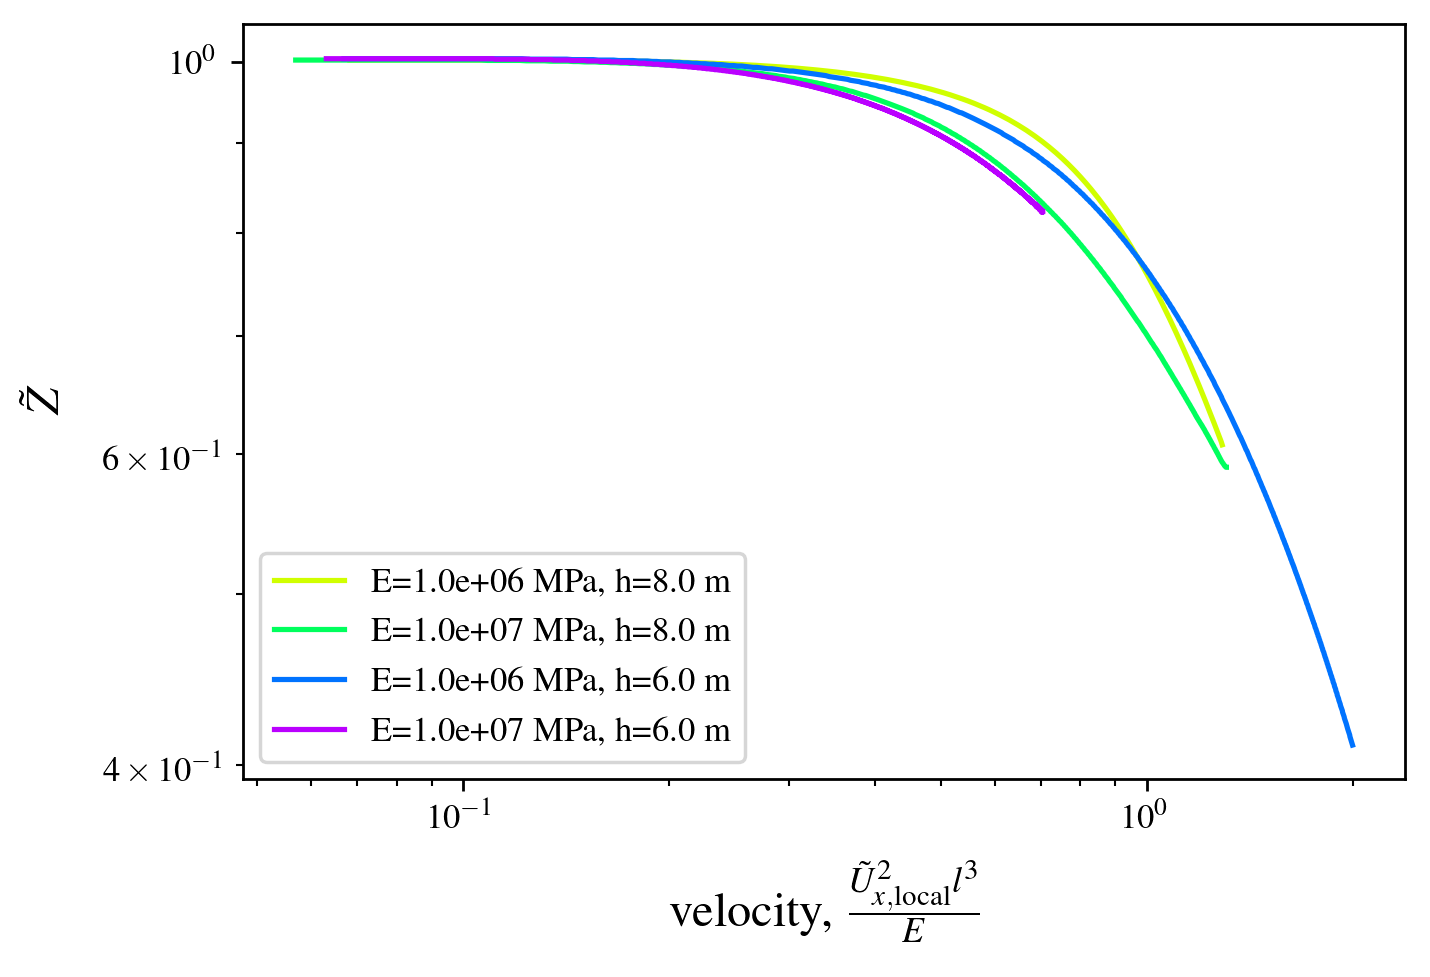

In [1130]:
fig, ax = plt.subplots(figsize=(6,4),dpi=250,facecolor='w')
cmap=get_cmap(1000,name='hsv')
power=2
origin=df68['v_loc_smooth'].values[0]
ax.loglog(df68['v_loc_smooth']**2/(1/3)**2,df68['Z_tilde_gap_L'],'-',c=cmap(200),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,8))
ax.loglog(df78['v_loc_smooth'][:-120]**2/(1/3)**2/10,df78['Z_tilde_gap_L'][:-120],'-',c=cmap(400),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,8))
ax.loglog(df66['v_loc_smooth']**2/(1/2)**2,df66['Z_tilde_gap_L'],'-',c=cmap(600),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**6,6))
ax.loglog(df76['v_loc_smooth']**2/(1/2)**2/10,df76['Z_tilde_gap_L'],'-',c=cmap(800),mfc='w',markersize=2,label="E=%2.1e MPa, h=%.1f m" % (10**7,6))
ax.set_ylabel(r'$\tilde{Z}$',fontsize=14)
ax.set_xlabel('velocity, '+r'$\frac{\tilde{U}^2_{x,\mathrm{local}}l^3}{E} $',fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.legend(loc='nw')
pylab.show()

### U02E6H4-temporal

In [357]:
print(problems[0])
problem = problems[0]

U20E6H4-temporal


In [358]:
problemPath = "{0}/{1}".format(dataPath,problems[0])
figPrefix = "{0}".format(problems[0])
tstep_start =5
U_inf = 2
drag_force_to_coef = rho*U_inf**2*area_plate/2

In [387]:
tstep_start = 2
tstep_end = 400
timesteps = np.arange(tstep_start,tstep_end+1)
temporal_velocity_data = np.zeros((len(timesteps),99,3))

In [396]:
temporal_velocity_data = np.zeros((len(timesteps),99,3))

In [362]:
len(timesteps)

399

In [120]:
os.chdir(os.path.join(dataPath,problem))

In [444]:
problems = ['U02E6H6-temporal']

problem = problems[0]

In [445]:
os.chdir(os.path.join(dataPath,problem))
for i in range(len(timesteps)):
    data_file = "U.{0:d}.csv".format(timesteps[i])
    df = pd.read_csv(data_file)
    df = df.fillna(0)
    Ux = df["U:0"].values[1:-1]
    Uy = df["U:1"].values[1:-1]
    temporal_velocity_data[i,:,0] = Ux
    temporal_velocity_data[i,:,1] = Uy
    df["U"] = df[["U:0", "U:1"]].sum(axis=1).apply(np.sqrt)
    Umag = df["U"].values[1:-1]
    temporal_velocity_data[i,:,2] = Umag
np.save('../npy_data/U02E6H6_temporal.npy',temporal_velocity_data)

In [446]:
np.save('../npy_data/U02E6H6_temporal.npy',temporal_velocity_data)

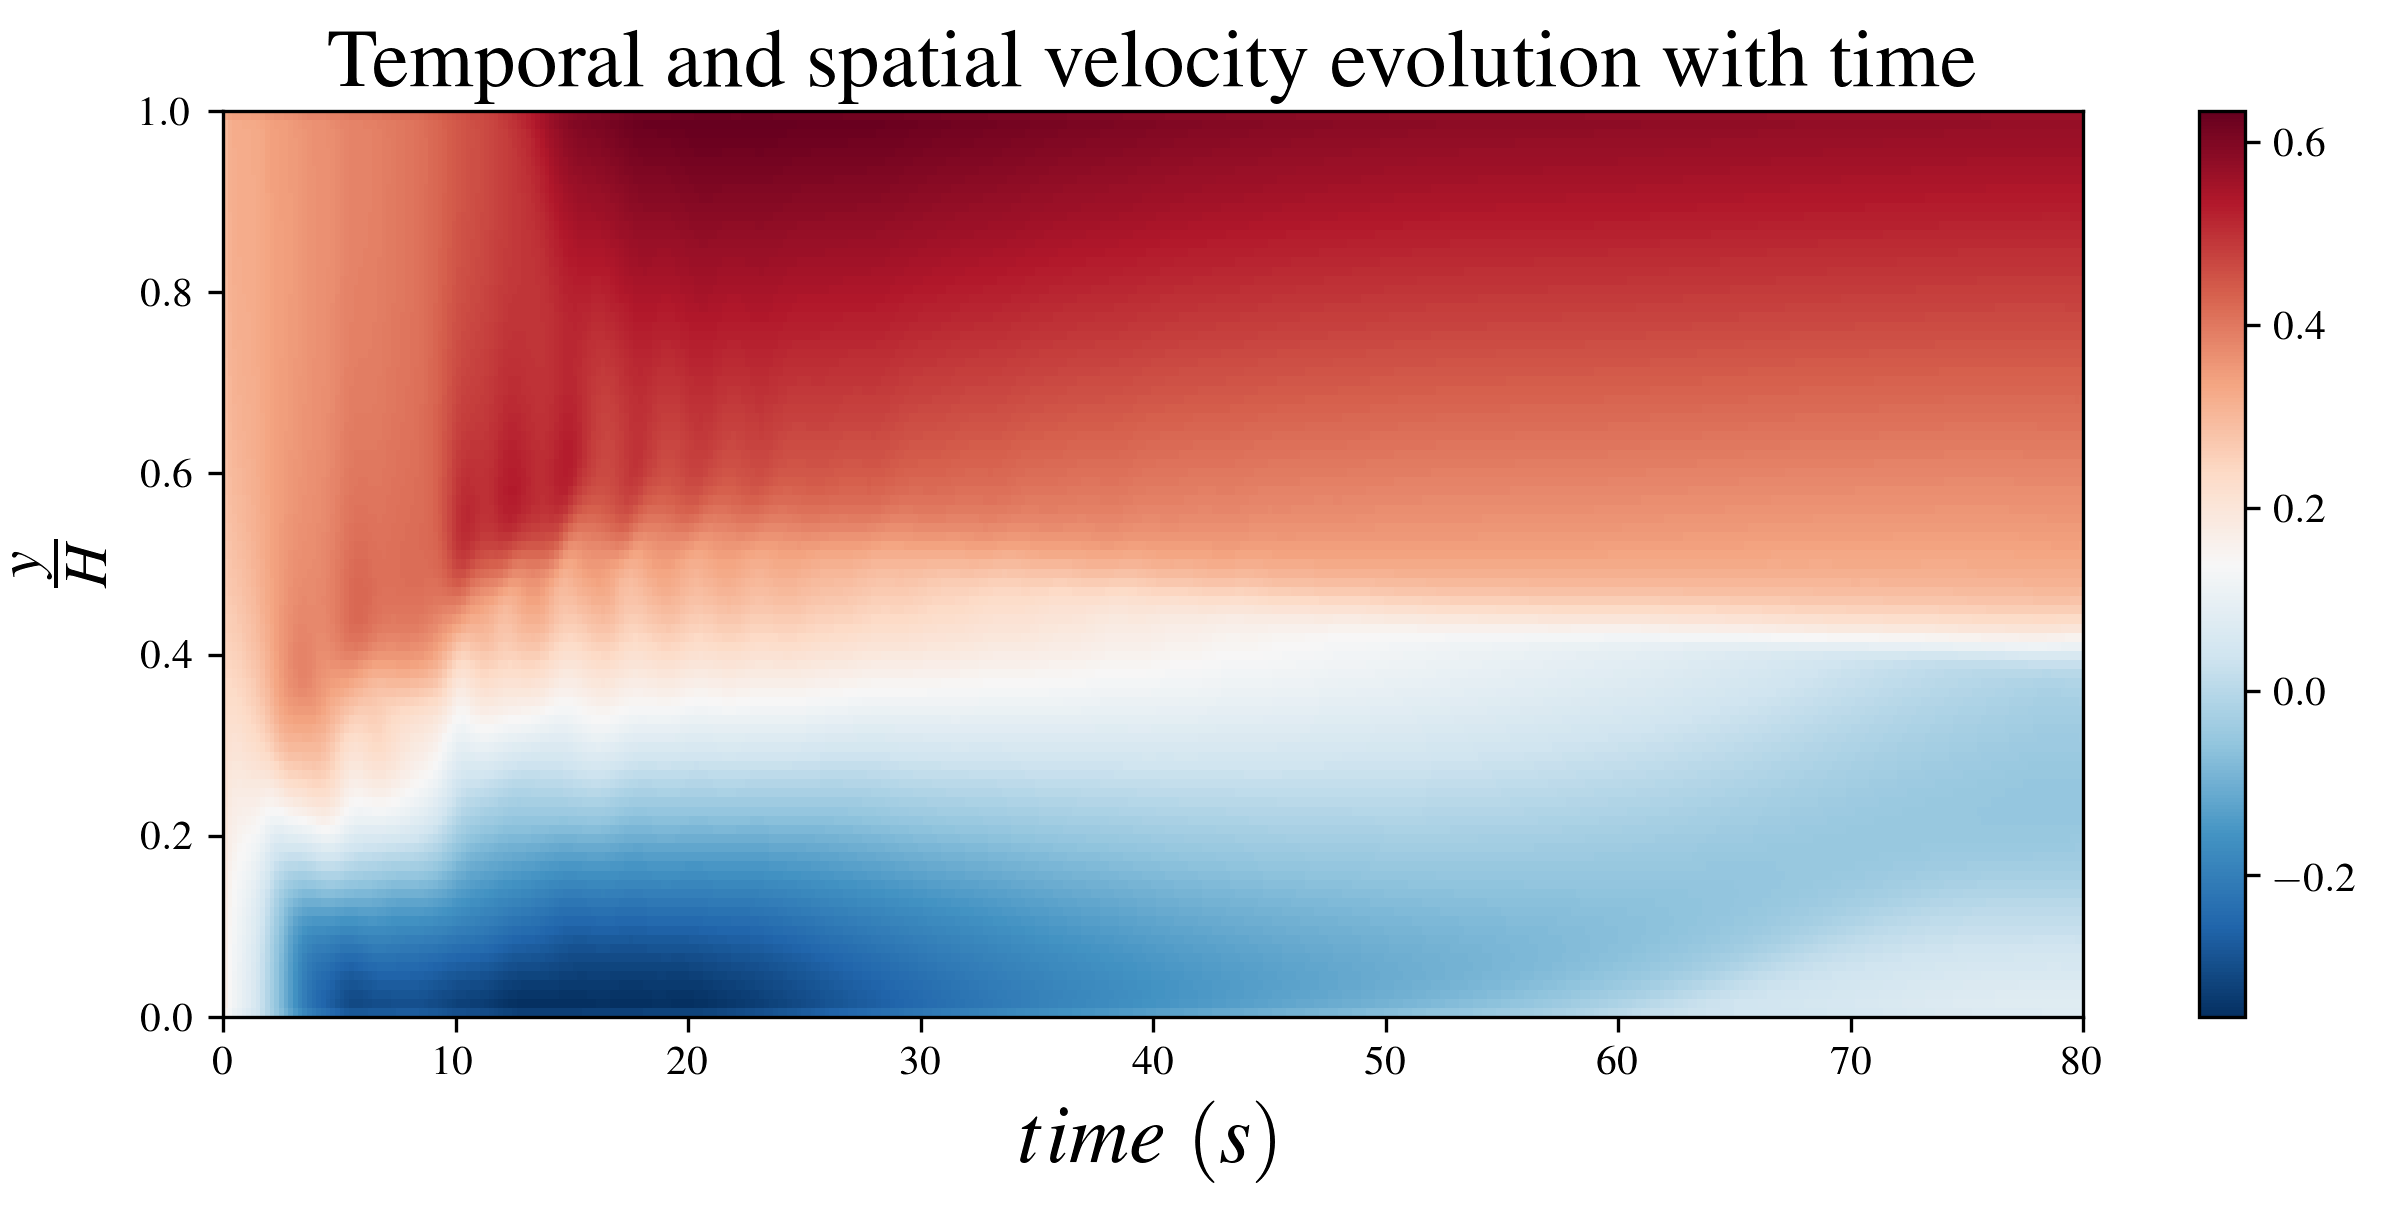

In [124]:
f, ax = plt.subplots(figsize=(10,4),dpi=300,facecolor='w')

plt.imshow(np.transpose(temporal_velocity_data[:,:,0]),
           extent=[0,80,0,1], cmap='RdBu_r',
           vmin=temporal_velocity_data.min(), vmax=temporal_velocity_data.max(),
           origin='lowest', aspect='auto')
ax.set_title('Temporal and spatial velocity evolution with time',fontsize = 20)
ax.set_xlabel('$time \ (s)$',fontsize = 20)
ax.set_ylabel('$\\frac{y_{}}{H}$',fontsize = 20)
plt.colorbar()
plt.show()

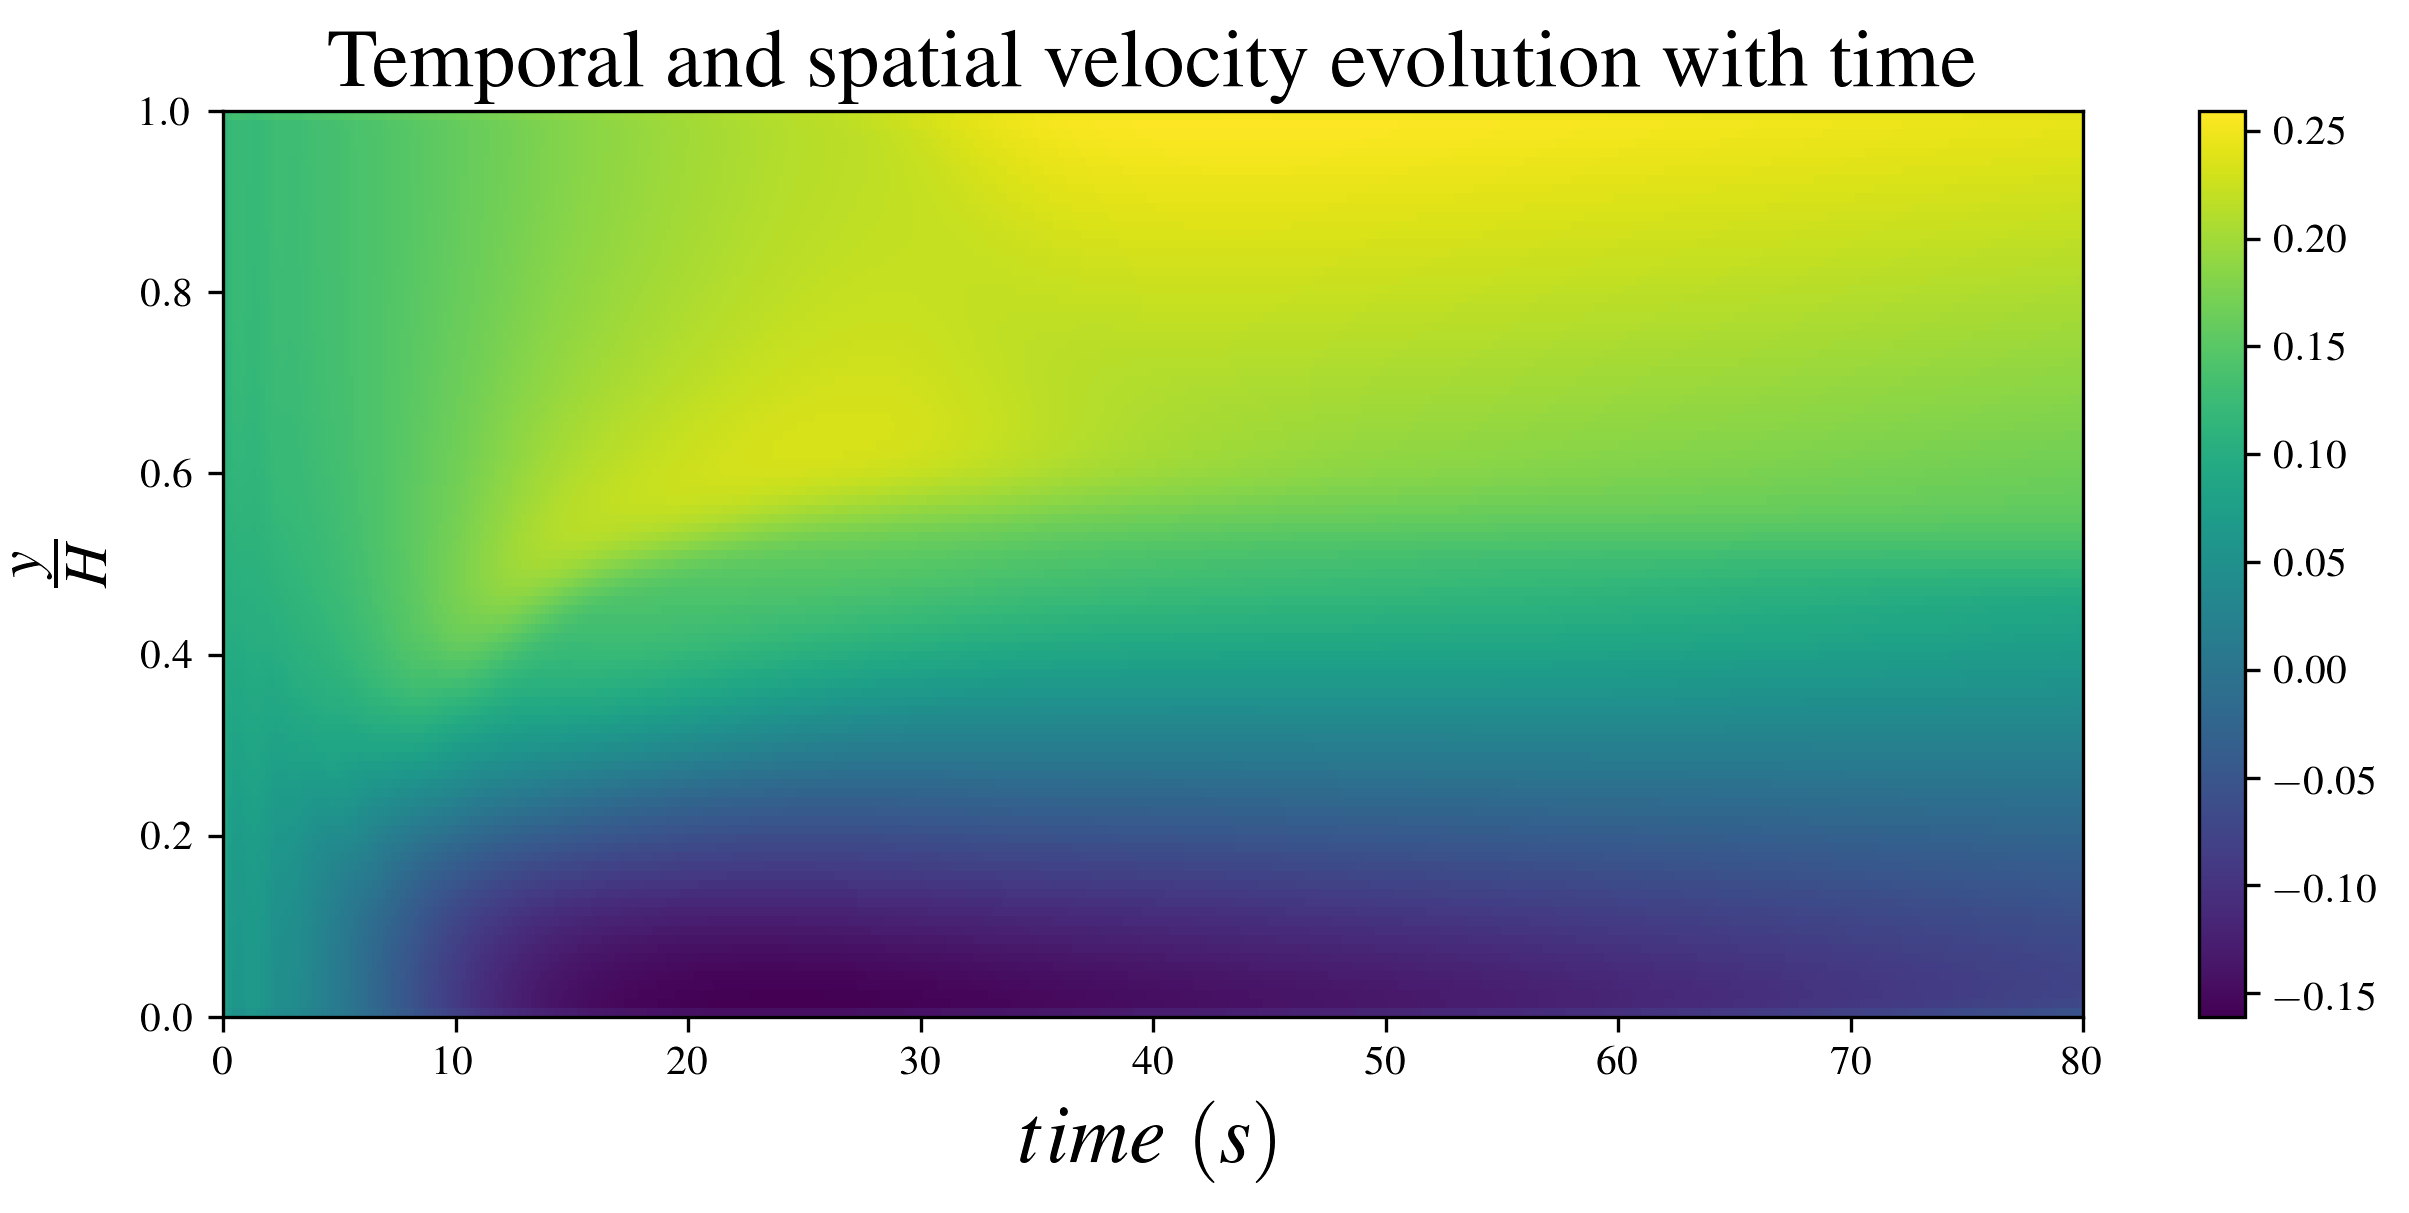

In [31]:
f, ax = plt.subplots(figsize=(10,4),dpi=300,facecolor='w')

plt.imshow(np.transpose(temporal_velocity_data[:,:,0]),
           extent=[0,80,0,1], cmap='viridis',
           vmin=temporal_velocity_data.min(), vmax=temporal_velocity_data.max(),
           origin='lowest', aspect='auto')
ax.set_title('Temporal and spatial velocity evolution with time',fontsize = 20)
ax.set_xlabel('$time \ (s)$',fontsize = 20)
ax.set_ylabel('$\\frac{y_{}}{H}$',fontsize = 20)
plt.colorbar()
plt.show()

In [32]:
np.save('U02E6H4_2_temporal.npy',temporal_velocity_data)

In [33]:
temporal_velocity_data = np.zeros((len(timesteps),99,2))

In [34]:
os.chdir(os.path.join(dataPath,problem))
for i in range(len(timesteps)):
    data_file = "U_4.{0:d}.csv".format(timesteps[i])
    df = pd.read_csv(data_file)
    df = df.fillna(0)
    Ux = df["U:0"].values[1:-1]
    Uy = df["U:1"].values[1:-1]
    temporal_velocity_data[i,:,0] = Ux
    temporal_velocity_data[i,:,1] = Uy

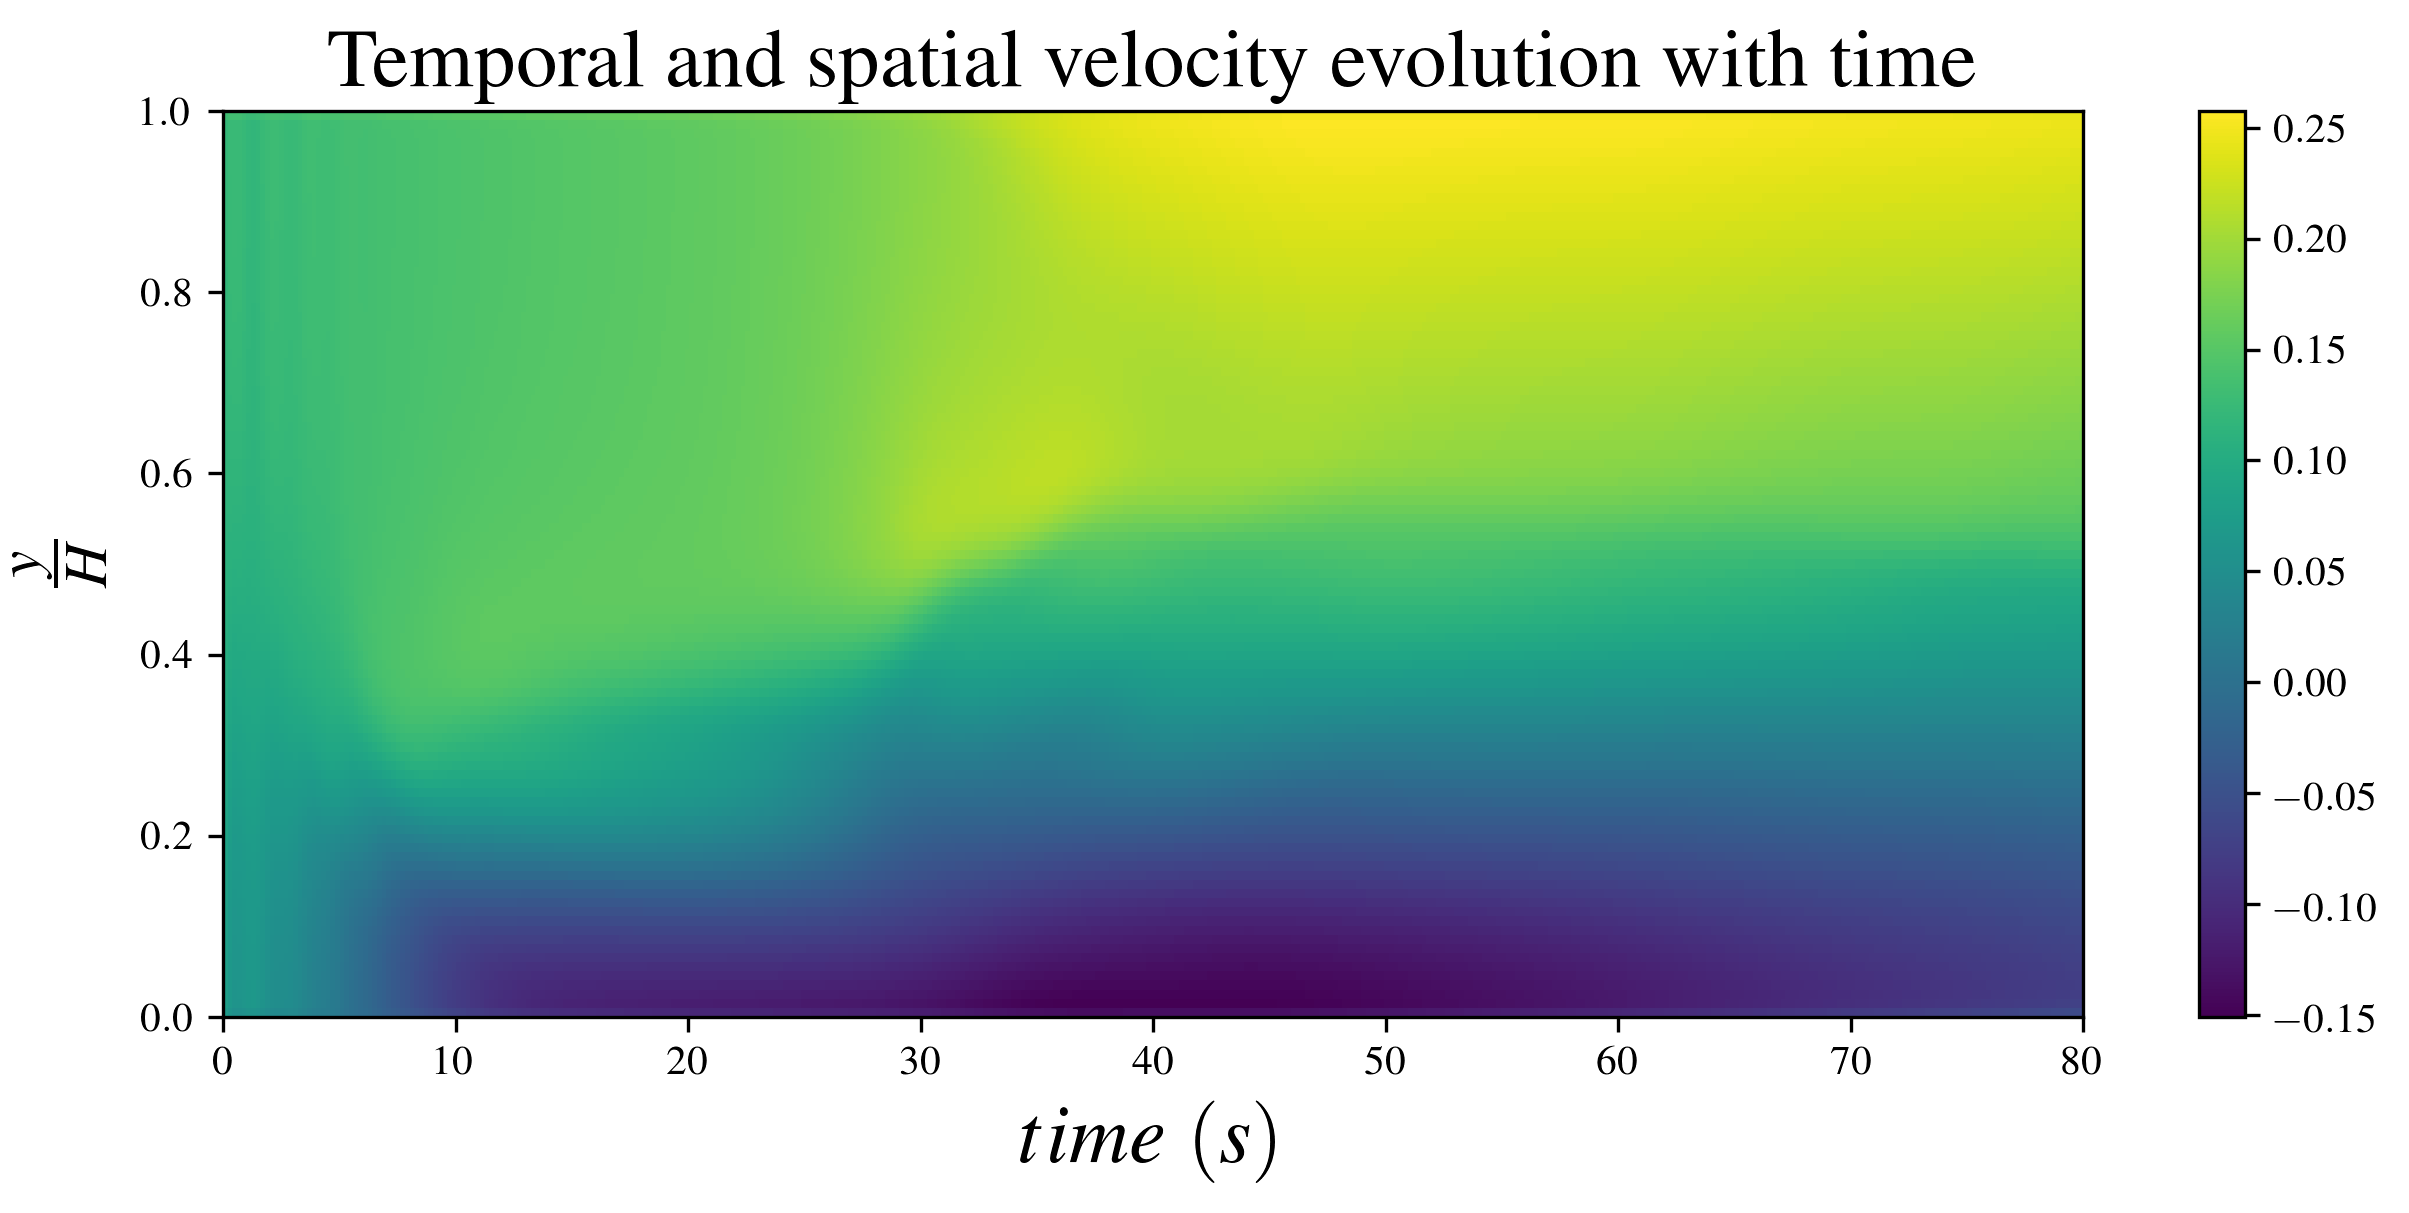

In [35]:
f, ax = plt.subplots(figsize=(10,4),dpi=300,facecolor='w')

plt.imshow(np.transpose(temporal_velocity_data[:,:,0]),
           extent=[0,80,0,1], cmap='viridis',
           vmin=temporal_velocity_data.min(), vmax=temporal_velocity_data.max(),
           origin='lowest', aspect='auto')
ax.set_title('Temporal and spatial velocity evolution with time',fontsize = 20)
ax.set_xlabel('$time \ (s)$',fontsize = 20)
ax.set_ylabel('$\\frac{y_{}}{H}$',fontsize = 20)
plt.colorbar()
plt.show()

In [36]:
np.save('U02E6H4_4_temporal.npy',temporal_velocity_data)

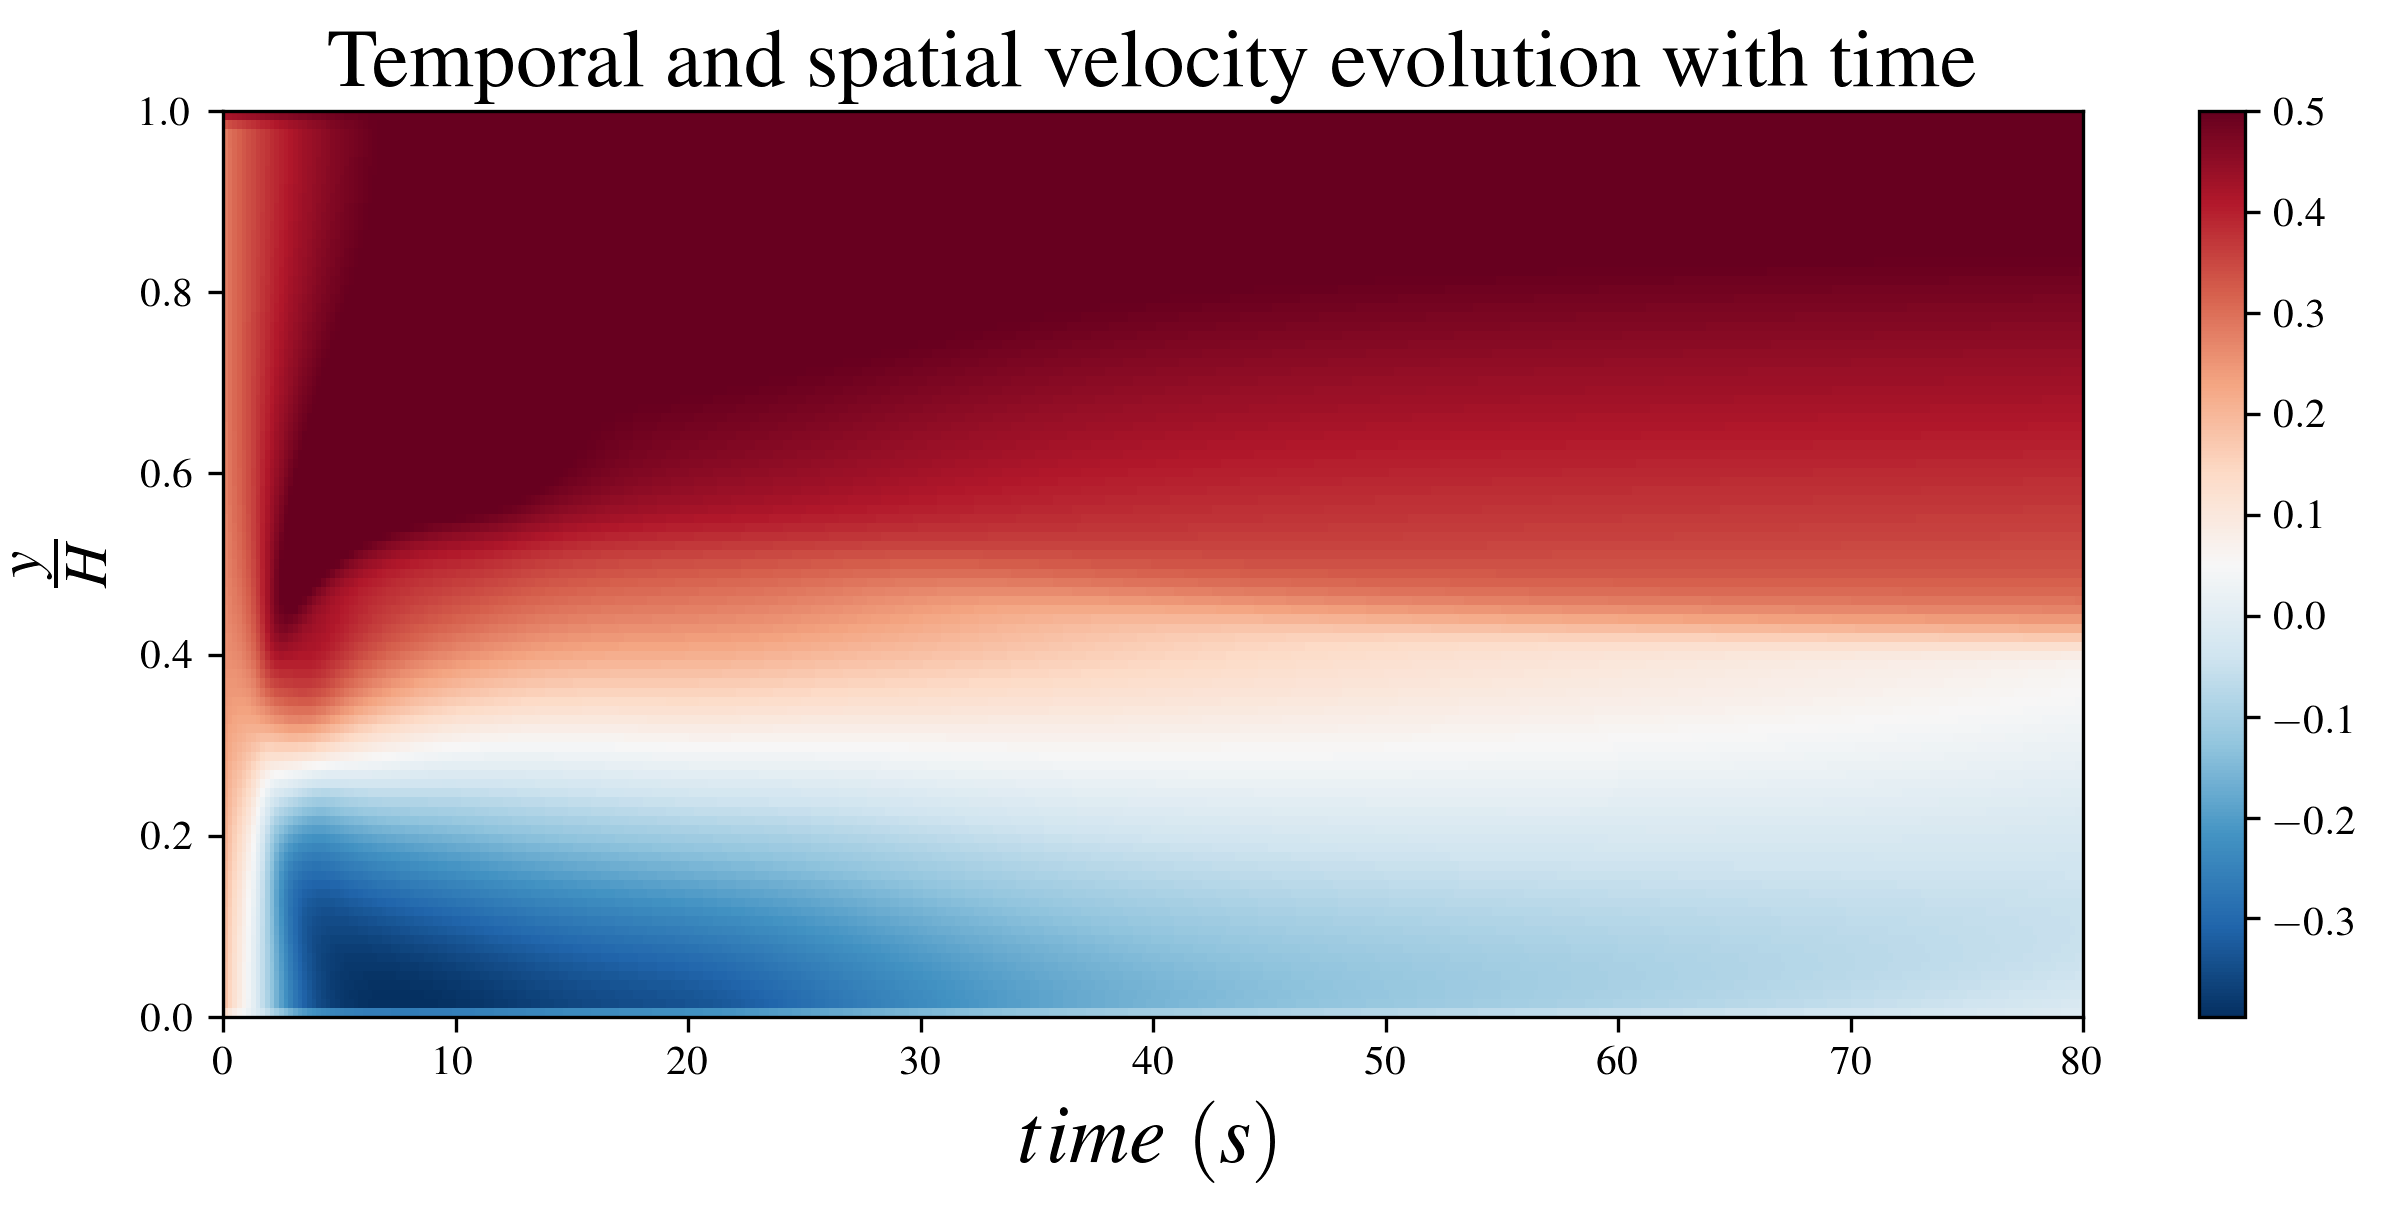

In [63]:
f, ax = plt.subplots(figsize=(10,4),dpi=300,facecolor='w')

plt.imshow(np.transpose(temporal_velocity_data[:,:,0]),
           extent=[0,80,0,1], cmap='RdBu_r',
           vmin=temporal_velocity_data.min(), vmax=0.5,
           origin='lowest', aspect='auto')
ax.set_title('Temporal and spatial velocity evolution with time',fontsize = 20)
ax.set_xlabel('$time \ (s)$',fontsize = 20)
ax.set_ylabel('$\\frac{y_{}}{H}$',fontsize = 20)
plt.colorbar()
plt.show()

In [62]:
temporal_velocity_data.max()

0.6333

In [126]:
ls

U.0.csv      U.406.csv    U_2.173.csv  U_2.481.csv  U_4.248.csv  U_4.556.csv
U.1.csv      U.407.csv    U_2.174.csv  U_2.482.csv  U_4.249.csv  U_4.557.csv
U.10.csv     U.408.csv    U_2.175.csv  U_2.483.csv  U_4.25.csv   U_4.558.csv
U.100.csv    U.409.csv    U_2.176.csv  U_2.484.csv  U_4.250.csv  U_4.559.csv
U.101.csv    U.41.csv     U_2.177.csv  U_2.485.csv  U_4.251.csv  U_4.56.csv
U.102.csv    U.410.csv    U_2.178.csv  U_2.486.csv  U_4.252.csv  U_4.560.csv
U.103.csv    U.411.csv    U_2.179.csv  U_2.487.csv  U_4.253.csv  U_4.561.csv
U.104.csv    U.412.csv    U_2.18.csv   U_2.488.csv  U_4.254.csv  U_4.562.csv
U.105.csv    U.413.csv    U_2.180.csv  U_2.489.csv  U_4.255.csv  U_4.563.csv
U.106.csv    U.414.csv    U_2.181.csv  U_2.49.csv   U_4.256.csv  U_4.564.csv
U.107.csv    U.415.csv    U_2.182.csv  U_2.490.csv  U_4.257.csv  U_4.565.csv
U.108.csv    U.416.csv    U_2.183.csv  U_2.491.csv  U_4.258.csv  U_4.566.csv
U.109.csv    U.417.csv    U_2.184.csv  U_2.492.csv  U_4.259.csv  U_4.567.csv


In [127]:
cd ..

/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/paper_data


In [128]:
ls

U02E12H4/          U02E7H4/           U02E9H8/           U05E9H6/
U02E12H6/          U02E7H4-temporal/  U02E9H8-temporal/  U20E6H4/
U02E12H6-temporal/ U02E7H6/           U05E12H4/          U20E6H4-temporal/
U02E6H4/           U02E7H6-temporal/  U05E6H4/           U20E7H4/
U02E6H4-temporal/  U02E9H4/           U05E6H4-temporal/  U20E7H4-temporal/
U02E6H6/           U02E9H4-temporal/  U05E7H4/           npy_data/
U02E6H6-temporal/  U02E9H6/           U05E9H4/


In [400]:
cd ../npy_data/

/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/paper_data/npy_data


In [130]:
ls

U02E6H4_1_temporal.npy  U02E7H4_1_temporal.npy  U05E6H4_1_temporal.npy
U02E6H4_2_temporal.npy  U02E7H4_2_temporal.npy  U05E6H4_2_temporal.npy
U02E6H4_4_temporal.npy  U02E7H4_4_temporal.npy  U05E6H4_4_temporal.npy


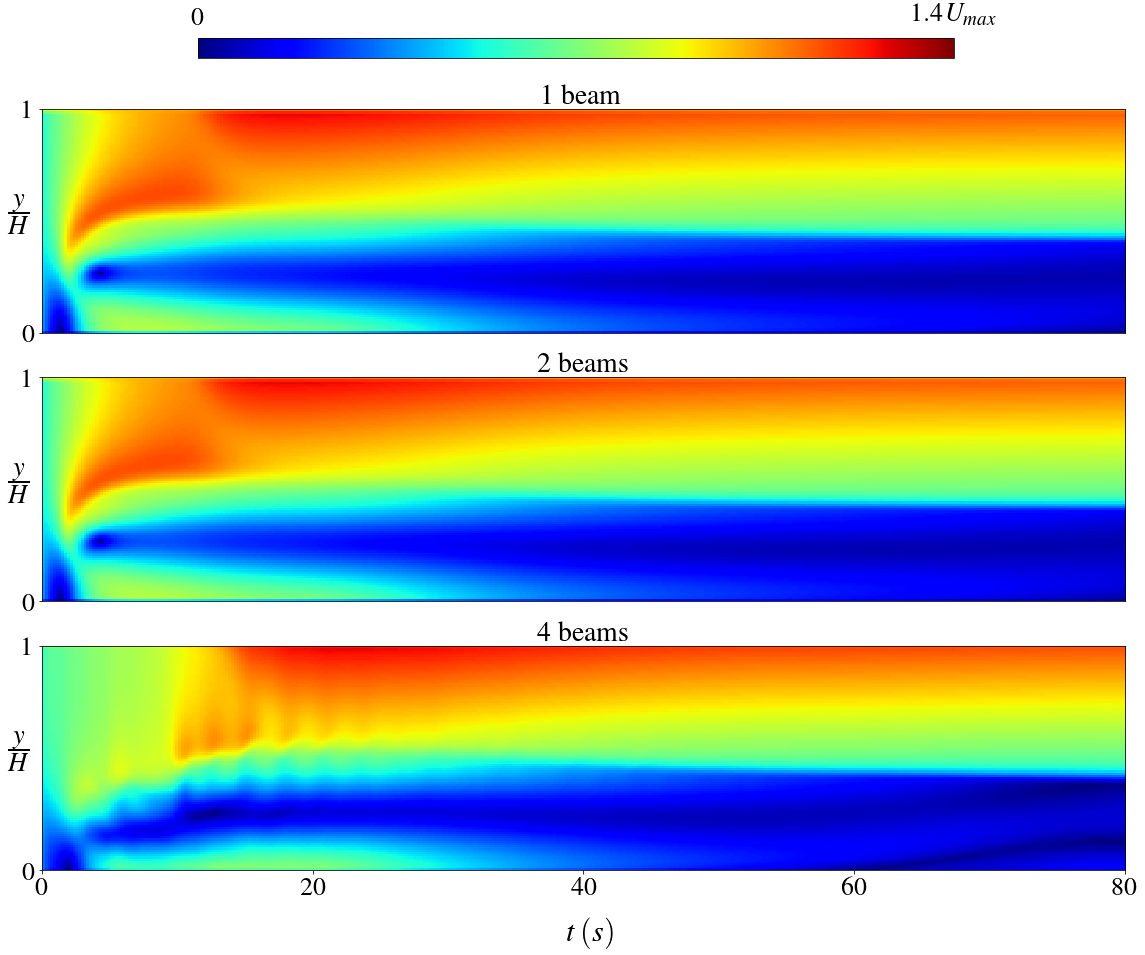

In [477]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:390]
    Uy = Uy[:390]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(U),extent=[0,80,0,1], cmap='jet',vmin=0, vmax=0.7,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1.4\,U_{max}$']):
    cbar.ax.text(j*0.7,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/U05E6H4_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

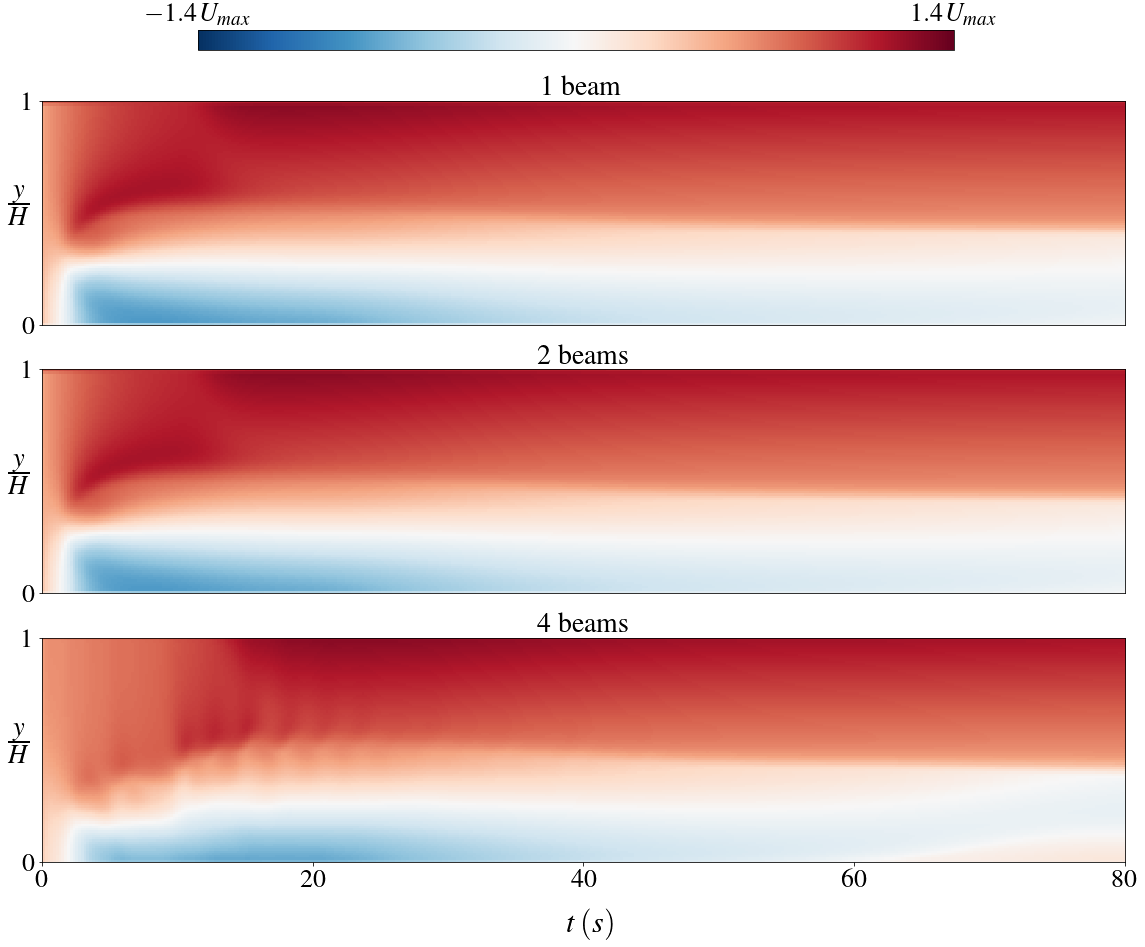

In [478]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:390]
    Uy = Uy[:390]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Ux),extent=[0,80,0,1], cmap='RdBu_r',vmin=-0.7, vmax=0.7,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-1.4\,U_{max}$','$1.4\,U_{max}$']):
    cbar.ax.text(-0.7+j*1.4,1.5, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/U05E6H4_Ux_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

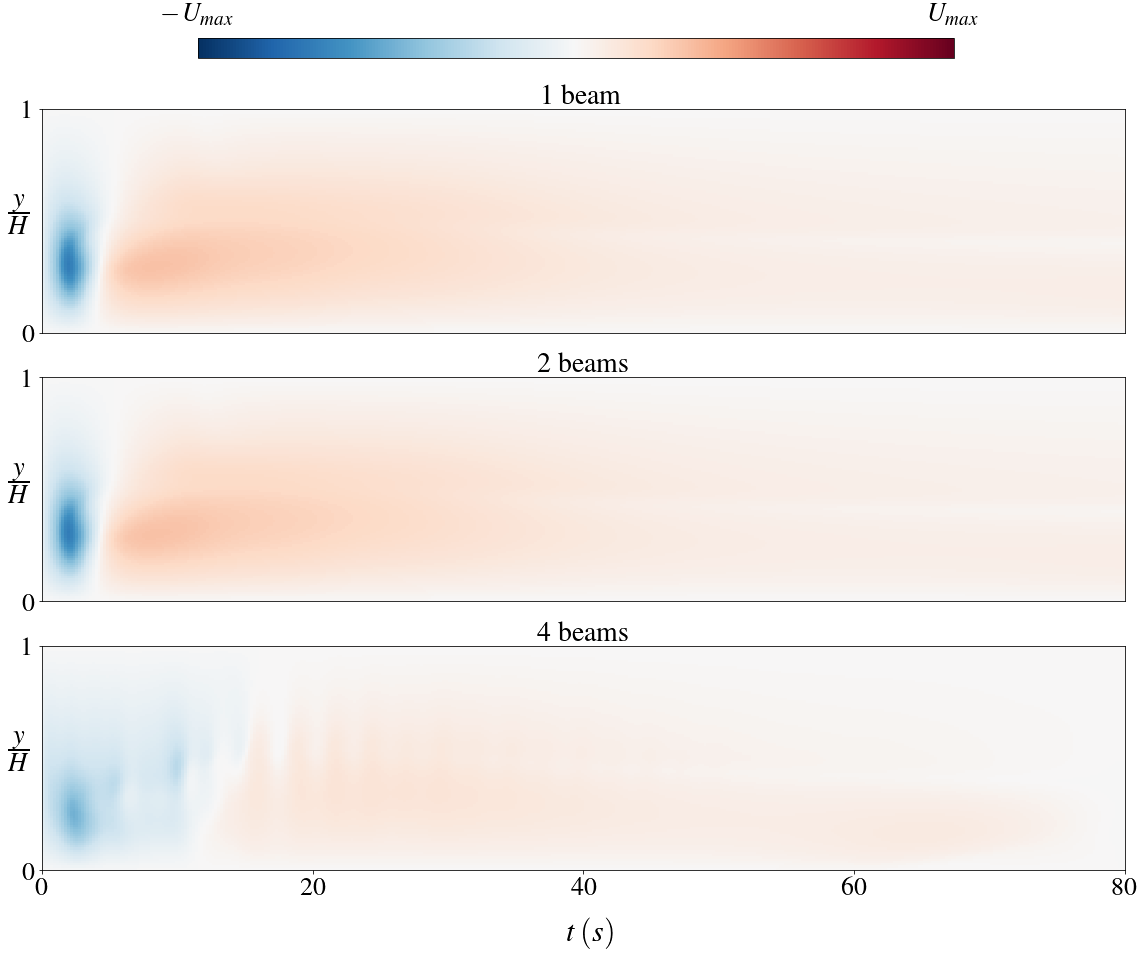

In [479]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:390]
    Uy = Uy[:390]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Uy),extent=[0,80,0,1], cmap='RdBu_r',vmin=-0.5, vmax=0.5,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-\,U_{max}$','$\,U_{max}$']):
    cbar.ax.text(-0.5+j*1,1.5, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/U05E6H4_Uy_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

In [474]:
pwd

'/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/paper_data/npy_data'

In [366]:
cd ../npy_data/

/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/paper_data/npy_data


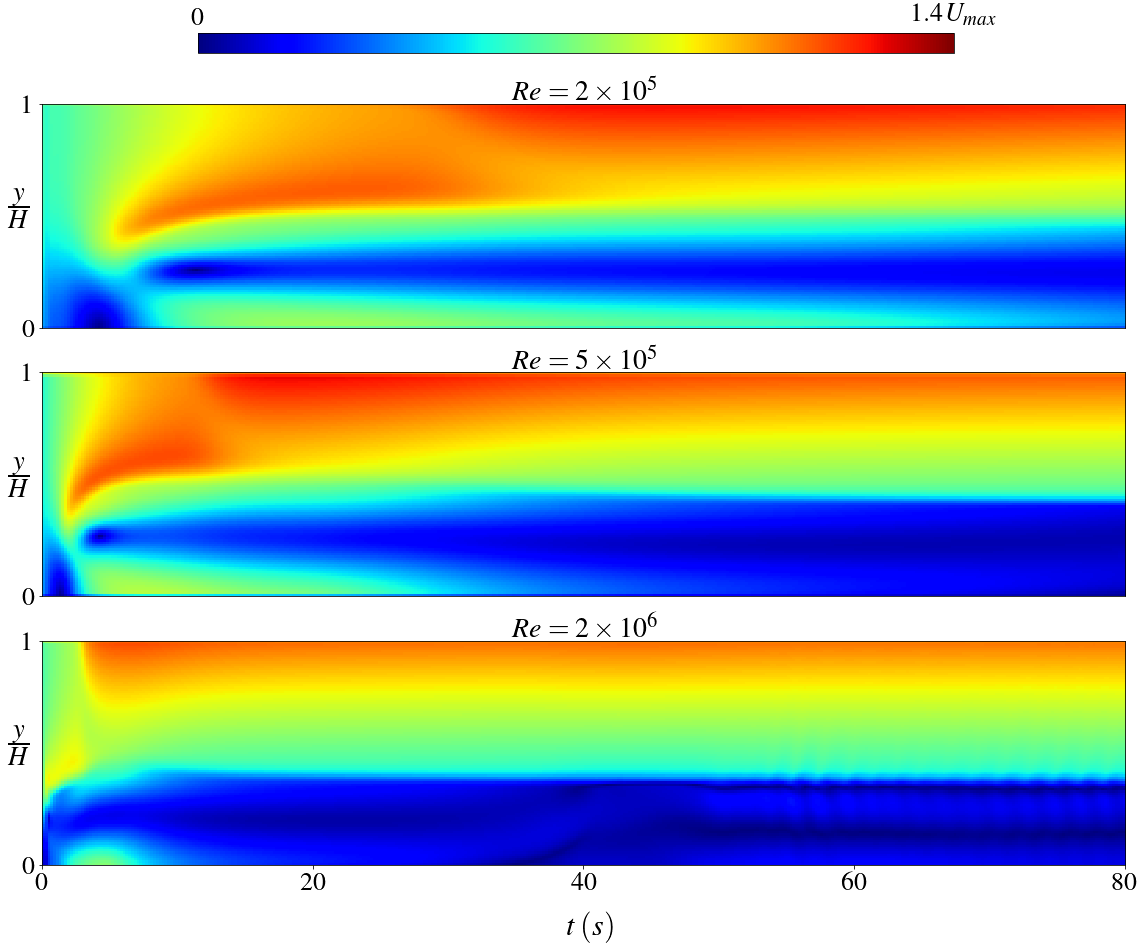

In [380]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
velocity = ["02","05","20"]
Re = ['2\\times10^5','5\\times10^5','2\\times10^6']
U_max = [0.2,0.5,2.0]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for k in range(Tot):
    #k = -1-kk
    j = velocity[k]
    file_name = "U{0:s}E6H4_1_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:390]
    Uy = Uy[:390]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(U),extent=[0,80,0,1], cmap='jet',vmin=0, vmax=U_max[k]*1.4,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('$Re = {0:s}$'.format(Re[k]),fontsize = 28, va='top')
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1.4\,U_{max}$']):
    cbar.ax.text(j*2.8,4.8, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/E6H4N1_Re_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

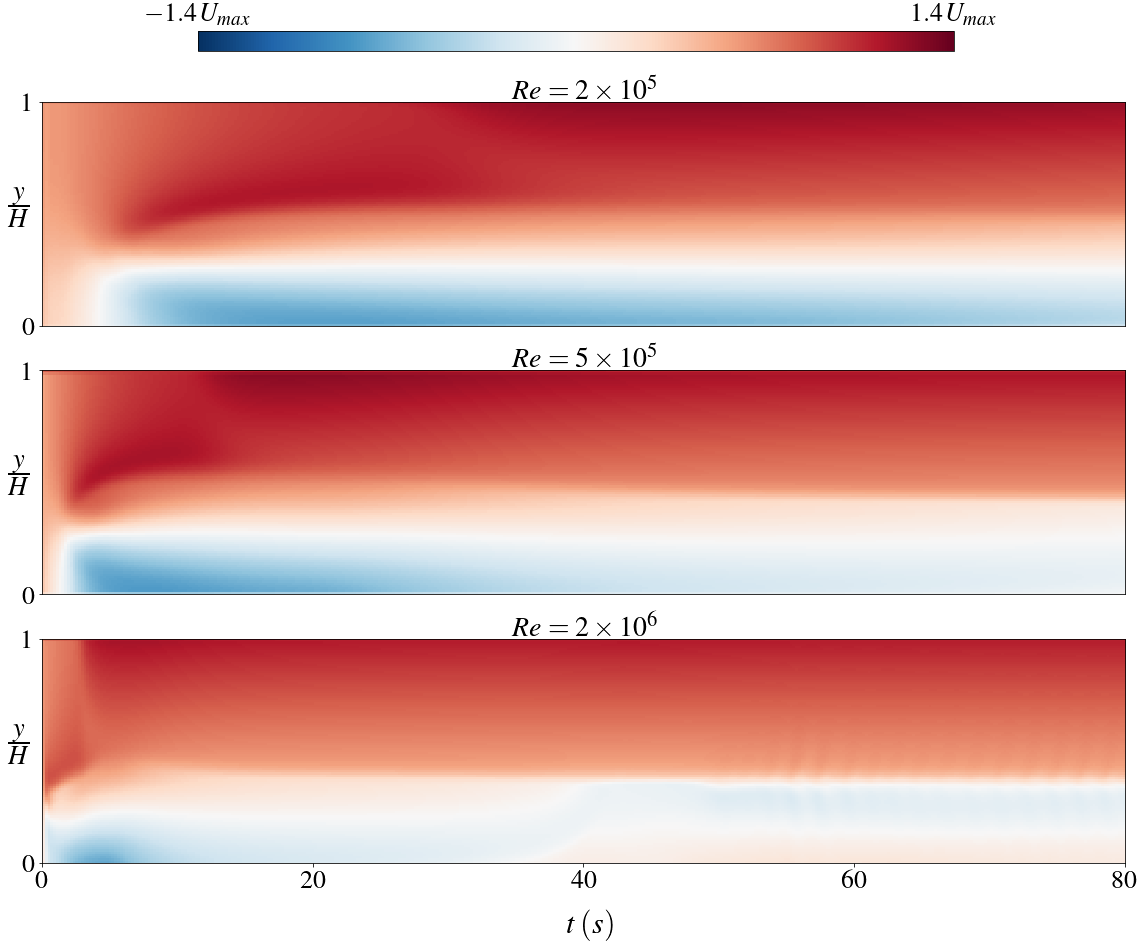

In [386]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
velocity = ["02","05","20"]
Re = ['2\\times10^5','5\\times10^5','2\\times10^6']
U_max = [0.2,0.5,2.0]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for k in range(Tot):
    #k = -1-kk
    j = velocity[k]
    file_name = "U{0:s}E6H4_1_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:390]
    Uy = Uy[:390]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Ux),extent=[0,80,0,1], cmap='RdBu_r',vmin=-U_max[k]*1.4, vmax=U_max[k]*1.4,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('$Re = {0:s}$'.format(Re[k]),fontsize = 28, va='top')
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-1.4\,U_{max}$','$1.4\,U_{max}$']):
    cbar.ax.text(-2.8+j*5.6,6.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/E6H4N1_Re_Ux_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

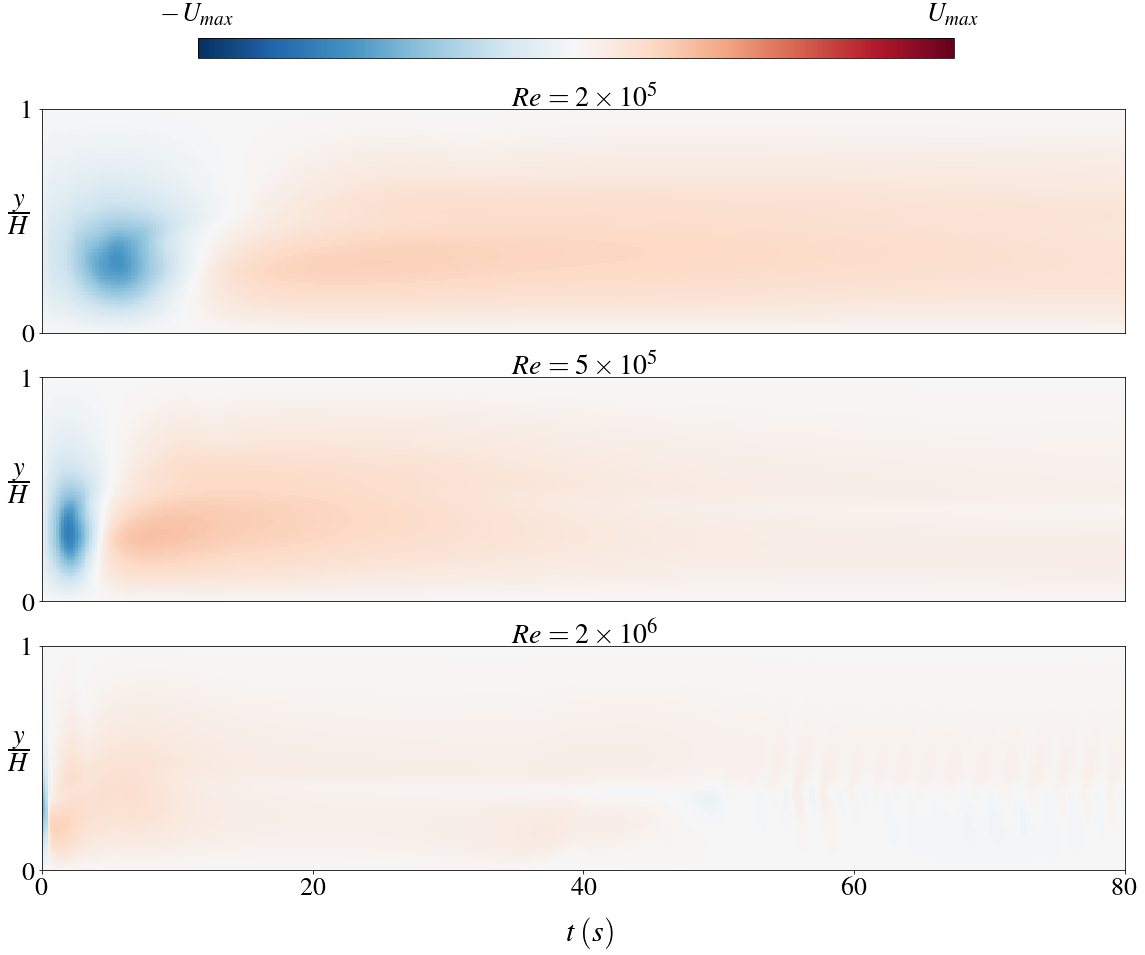

In [473]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
velocity = ["02","05","20"]
Re = ['2\\times10^5','5\\times10^5','2\\times10^6']
U_max = [0.2,0.5,2.0]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for k in range(Tot):
    #k = -1-kk
    j = velocity[k]
    file_name = "U{0:s}E6H4_1_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:390]
    Uy = Uy[:390]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Uy),extent=[0,80,0,1], cmap='RdBu_r',vmin=-U_max[k]*1, vmax=U_max[k]*1,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('$Re = {0:s}$'.format(Re[k]),fontsize = 28, va='top')
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-\,U_{max}$','$\,U_{max}$']):
    cbar.ax.text(-2*1+j*2*2,3*1*2, lab, ha='center', va='center',fontsize=26)
plt.show()

fig.savefig('%s/E6H4N1_Re_Uy_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

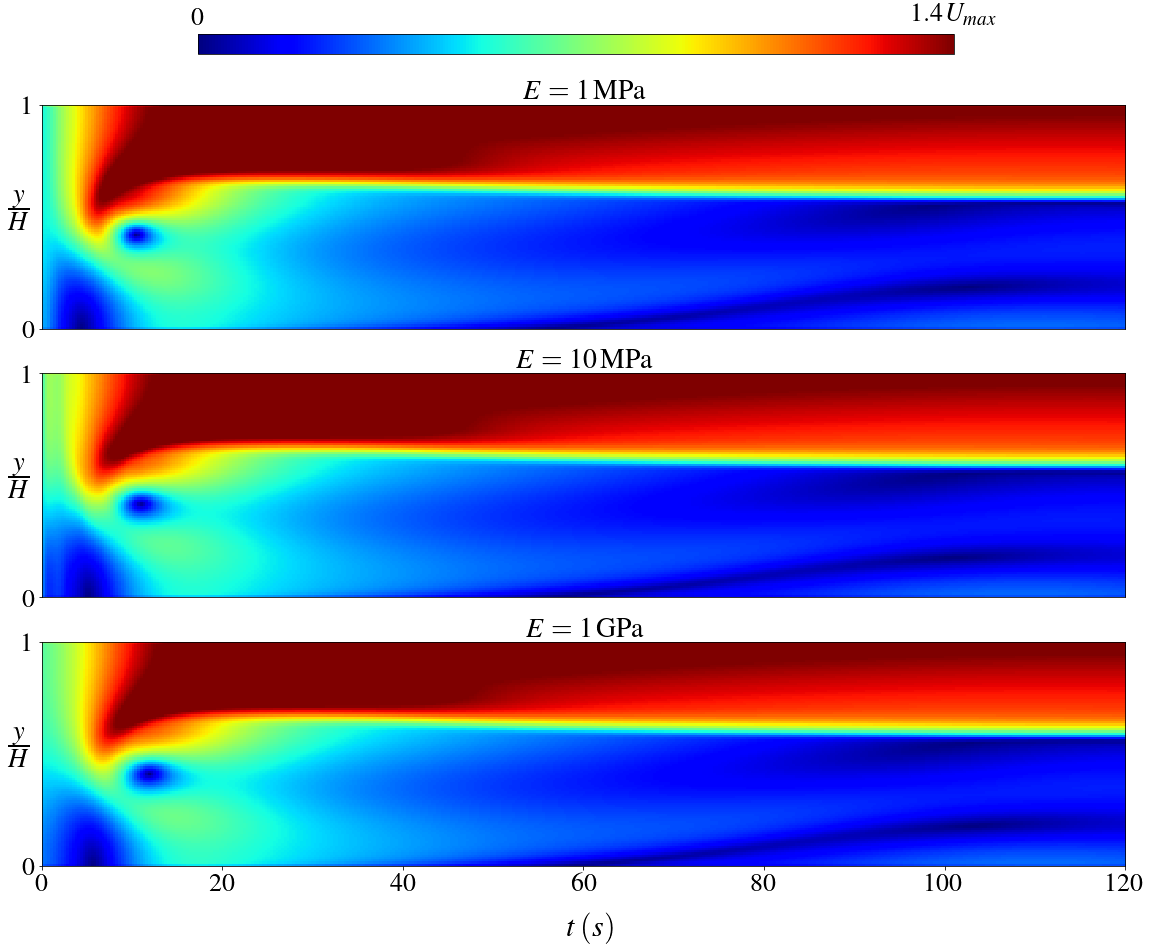

In [476]:
## import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
stiffness = ["6","7","12"]
EE = ['1\\,\\mathrm{MPa}','10\\,\\mathrm{MPa}','1\\,\\mathrm{GPa}']
U_max = [0.2,0.2,0.2]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)
U_max = [0.2,0.2,0.2]
fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for k in range(Tot):
    #k = -1-kk
    j = stiffness[k]
    file_name = "U02E{0:s}H6_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:600]
    Uy = Uy[:600]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(U),extent=[0,120,0,1], cmap='jet',vmin=0, vmax=U_max[k]*1.4,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('$E = {0:s}$'.format(EE[k]),fontsize = 28, va='top')
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,120,7)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1.4\,U_{max}$']):
    cbar.ax.text(j*0.2*1.4,0.5, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/U02H6HN1_EE_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)





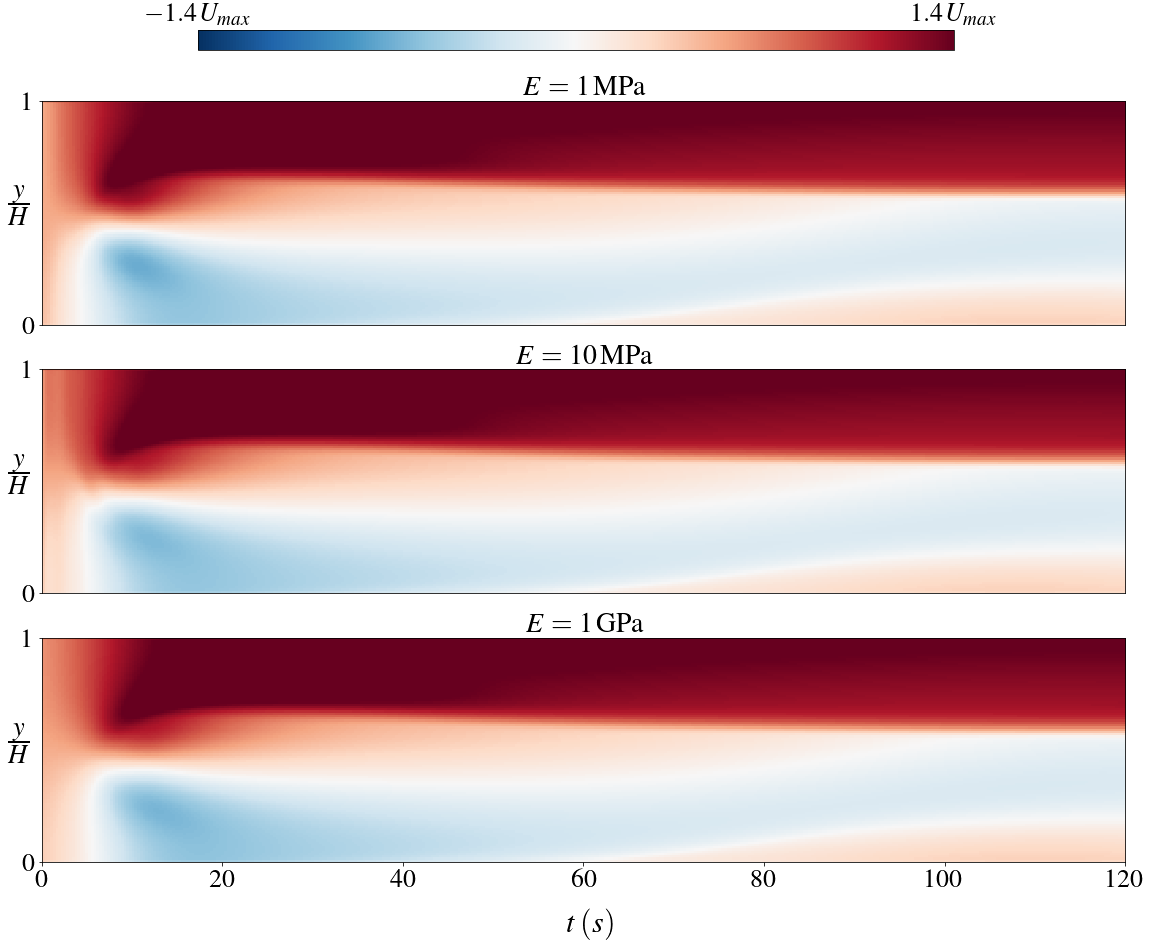

In [465]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
stiffness = ["6","7","12"]
EE = ['1\\,\\mathrm{MPa}','10\\,\\mathrm{MPa}','1\\,\\mathrm{GPa}']
U_max = [0.2,0.2,0.2]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)
U_max = [0.2,0.2,0.2]
fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for k in range(Tot):
    #k = -1-kk
    j = stiffness[k]
    file_name = "U02E{0:s}H6_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:400]
    Uy = Uy[:400]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Ux),extent=[0,120,0,1], cmap='RdBu_r',vmin=-U_max[k]*1.4, vmax=U_max[k]*1.4,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('$E = {0:s}$'.format(EE[k]),fontsize = 28, va='top')
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,120,7)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-1.4\,U_{max}$','$1.4\,U_{max}$']):
    cbar.ax.text(-0.2*1.4+j*0.2*2.8,0.6, lab, ha='center', va='center',fontsize=26)
plt.show()

fig.savefig('%s/U02H6HN1_EE_Ux_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)





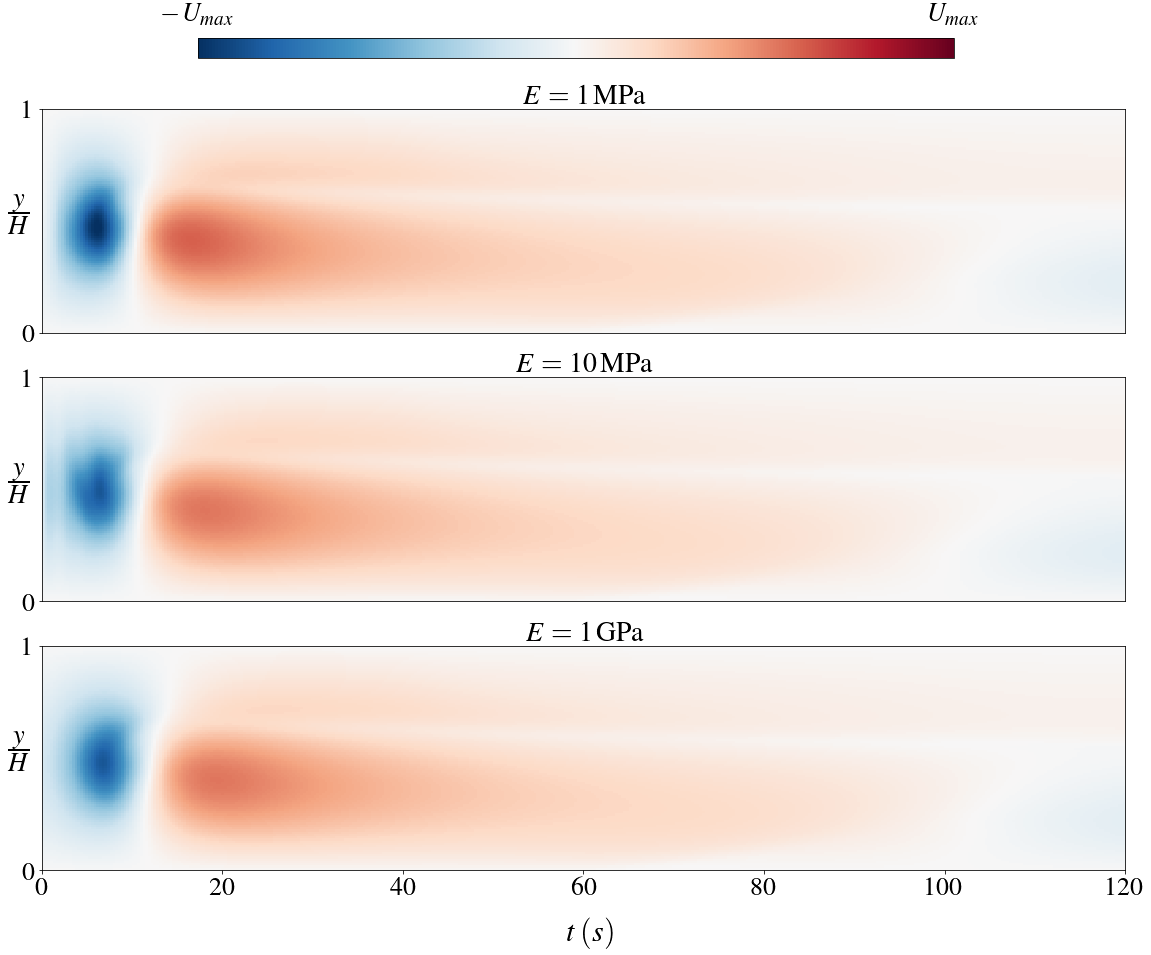

In [469]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
stiffness = ["6","7","12"]
EE = ['1\\,\\mathrm{MPa}','10\\,\\mathrm{MPa}','1\\,\\mathrm{GPa}']
U_max = [0.2,0.2,0.2]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)
U_max = [0.2,0.2,0.2]
fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for k in range(Tot):
    #k = -1-kk
    j = stiffness[k]
    file_name = "U02E{0:s}H6_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:400]
    Uy = Uy[:400]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Uy),extent=[0,120,0,1], cmap='RdBu_r',vmin=-U_max[k]*1, vmax=U_max[k]*1,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('$E = {0:s}$'.format(EE[k]),fontsize = 28, va='top')
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,120,7)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-\,U_{max}$','$\,U_{max}$']):
    cbar.ax.text(-0.2*1+j*0.2*2,3*1*0.2, lab, ha='center', va='center',fontsize=26)
plt.show()

fig.savefig('%s/U02H6HN1_EE_Uy_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)





In [161]:
file_name = "U05E6H4_{:d}_temporal.npy".format(4)
b = np.load(file_name)
b[:,:,0]

array([[0.15424 , 0.16252 , 0.16287 , ..., 0.30033 , 0.30057 , 0.32899 ],
       [0.12803 , 0.13836 , 0.13877 , ..., 0.3143  , 0.31461 , 0.33806 ],
       [0.11004 , 0.12143 , 0.12189 , ..., 0.32087 , 0.32122 , 0.34134 ],
       ...,
       [0.073609, 0.079349, 0.07523 , ..., 0.56679 , 0.57157 , 0.56756 ],
       [0.073578, 0.079294, 0.075161, ..., 0.5668  , 0.57157 , 0.56757 ],
       [0.073544, 0.079235, 0.075088, ..., 0.5668  , 0.57157 , 0.56756 ]])

In [162]:
file_name = "U05E6H4_{:d}_temporal.npy".format(2)
b = np.load(file_name)
b[:,:,0]

array([[ 0.12788  ,  0.18206  ,  0.1826   , ...,  0.28204  ,  0.33407  ,
         0.41704  ],
       [ 0.10221  ,  0.14792  ,  0.14859  , ...,  0.29683  ,  0.34338  ,
         0.42169  ],
       [ 0.080518 ,  0.11976  ,  0.12046  , ...,  0.30965  ,  0.35008  ,
         0.42504  ],
       ...,
       [-0.010476 , -0.020124 , -0.028753 , ...,  0.56302  ,  0.55344  ,
         0.52672  ],
       [-0.0098691, -0.019203 , -0.027869 , ...,  0.56297  ,  0.55341  ,
         0.5267   ],
       [-0.0092571, -0.018274 , -0.026979 , ...,  0.56293  ,  0.55337  ,
         0.52668  ]])

In [163]:
file_name = "U05E6H4_{:d}_temporal.npy".format(1)
b = np.load(file_name)
b[:,:,0]

array([[ 0.12899  ,  0.18206  ,  0.18261  , ...,  0.28204  ,  0.33409  ,
         0.41704  ],
       [ 0.1031   ,  0.14793  ,  0.1486   , ...,  0.29683  ,  0.34339  ,
         0.4217   ],
       [ 0.081213 ,  0.11977  ,  0.12046  , ...,  0.30965  ,  0.35009  ,
         0.42504  ],
       ...,
       [-0.010566 , -0.020198 , -0.028826 , ...,  0.56302  ,  0.55344  ,
         0.52672  ],
       [-0.0099546, -0.019277 , -0.027942 , ...,  0.56297  ,  0.5534   ,
         0.5267   ],
       [-0.0093373, -0.018348 , -0.027053 , ...,  0.56293  ,  0.55336  ,
         0.52668  ]])

In [480]:
cd ~/Dropbox/paper/2D_multi_beams/paper_states/NN/Herschel/124_kn2/

/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/NN/Herschel/124_kn2


In [481]:
tstep_start = 2
tstep_end = 400
timesteps = np.arange(tstep_start,tstep_end+1)
temporal_velocity_data = np.zeros((len(timesteps),99,3))

In [482]:

for i in range(len(timesteps)):
    data_file = "U1.{0:d}.csv".format(timesteps[i])
    df = pd.read_csv(data_file)
    df = df.fillna(0)
    Ux = df["U:0"].values[1:-1]
    Uy = df["U:1"].values[1:-1]
    temporal_velocity_data[i,:,0] = Ux
    temporal_velocity_data[i,:,1] = Uy
    df["U"] = df[["U:0", "U:1"]].sum(axis=1).apply(np.sqrt)
    Umag = df["U"].values[1:-1]
    temporal_velocity_data[i,:,2] = Umag
np.save('Herschel_U05E6H4N1_kn2_temporal.npy',temporal_velocity_data)

In [486]:
tstep_start = 2
tstep_end = 200
timesteps = np.arange(tstep_start,tstep_end+1)
temporal_velocity_data = np.zeros((len(timesteps),99,3))

In [484]:
for i in range(len(timesteps)):
    data_file = "U2.{0:d}.csv".format(timesteps[i])
    df = pd.read_csv(data_file)
    df = df.fillna(0)
    Ux = df["U:0"].values[1:-1]
    Uy = df["U:1"].values[1:-1]
    temporal_velocity_data[i,:,0] = Ux
    temporal_velocity_data[i,:,1] = Uy
    df["U"] = df[["U:0", "U:1"]].sum(axis=1).apply(np.sqrt)
    Umag = df["U"].values[1:-1]
    temporal_velocity_data[i,:,2] = Umag
np.save('Herschel_U05E6H4N2_kn2_temporal.npy',temporal_velocity_data)

In [487]:
for i in range(len(timesteps)):
    data_file = "U4.{0:d}.csv".format(timesteps[i])
    df = pd.read_csv(data_file)
    df = df.fillna(0)
    Ux = df["U:0"].values[1:-1]
    Uy = df["U:1"].values[1:-1]
    temporal_velocity_data[i,:,0] = Ux
    temporal_velocity_data[i,:,1] = Uy
    df["U"] = df[["U:0", "U:1"]].sum(axis=1).apply(np.sqrt)
    Umag = df["U"].values[1:-1]
    temporal_velocity_data[i,:,2] = Umag
np.save('Herschel_U05E6H4N4_kn2_temporal.npy',temporal_velocity_data)

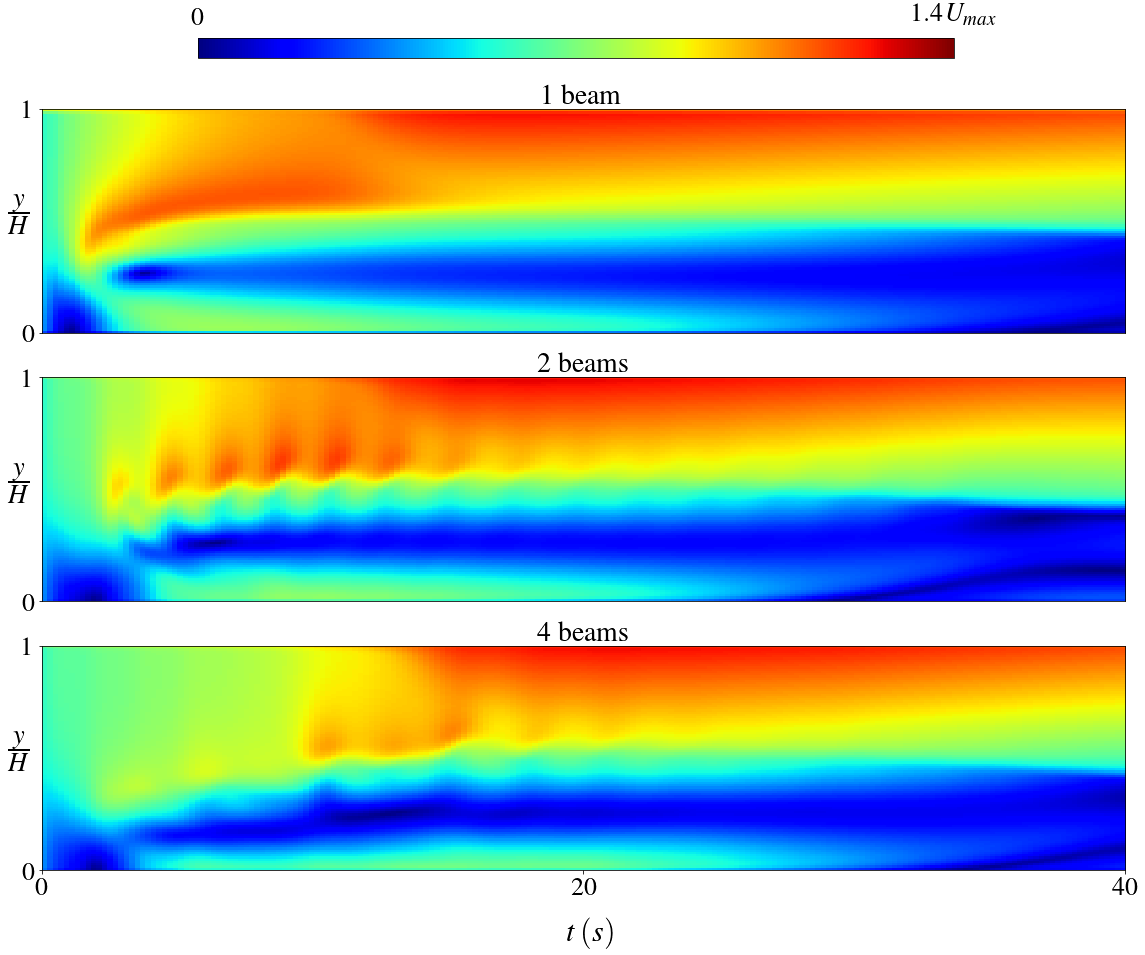

In [490]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    #file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    file_name = "Herschel_U05E6H4N{:d}_kn2_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:200]
    Uy = Uy[:200]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(U),extent=[0,40,0,1], cmap='jet',vmin=0, vmax=0.7,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,40,3)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1.4\,U_{max}$']):
    cbar.ax.text(j*0.7,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/NN_H_U05E6H4_kn2_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

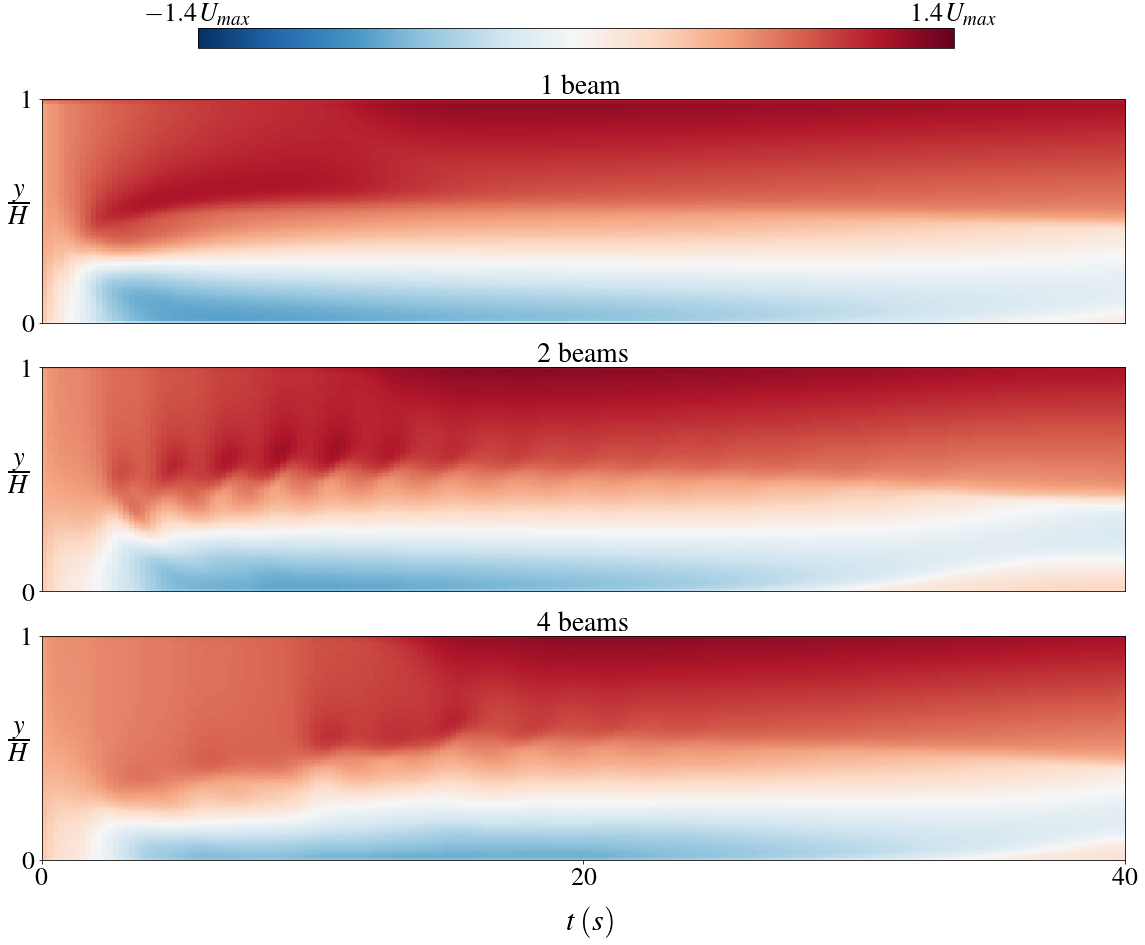

In [496]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    #file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    file_name = "Herschel_U05E6H4N{:d}_kn2_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:200]
    Uy = Uy[:200]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Ux),extent=[0,40,0,1], cmap='RdBu_r',vmin=-0.7, vmax=0.7,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,40,3)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-1.4\,U_{max}$','$1.4\,U_{max}$']):
    cbar.ax.text(-0.7+j*1.4,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/NN_H_U05E6H4_kn2_Ux_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

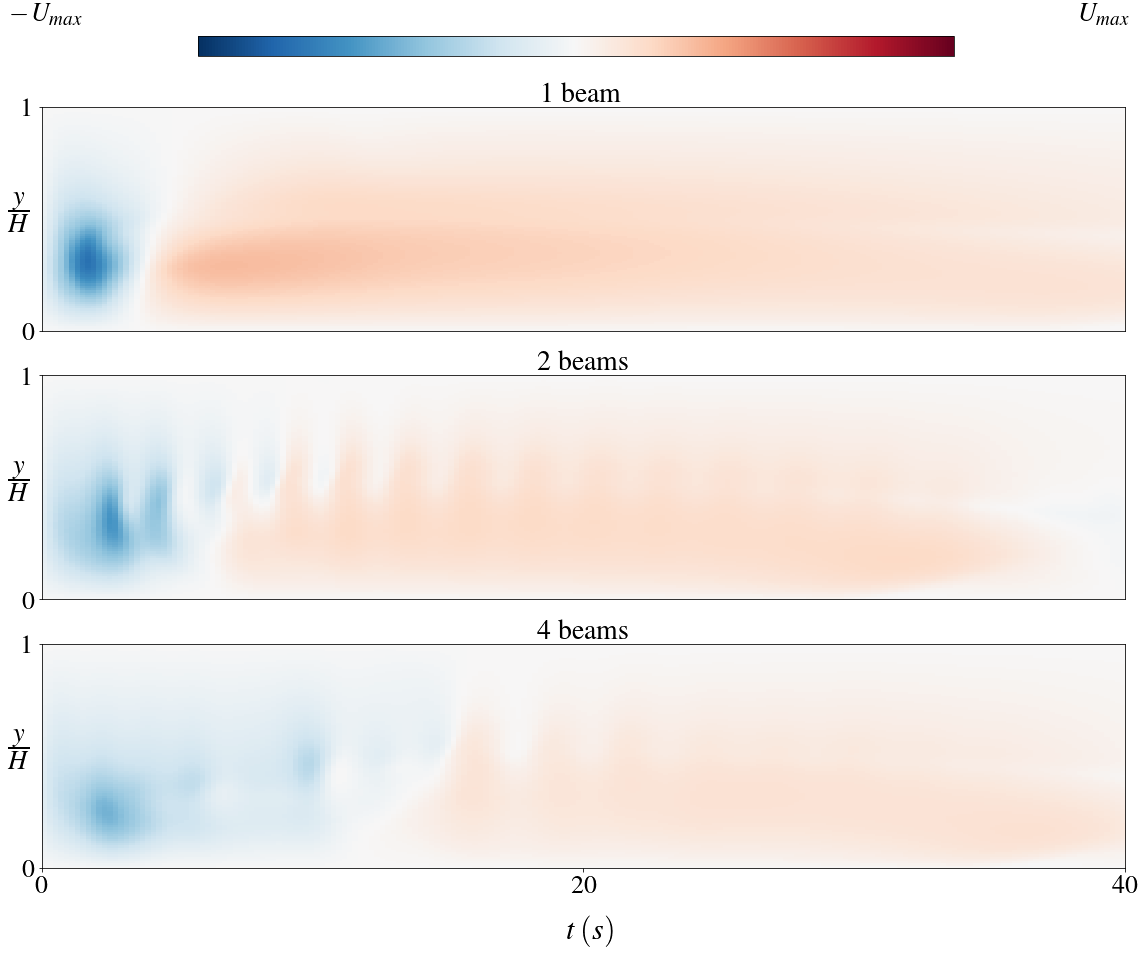

In [497]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    #file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    file_name = "Herschel_U05E6H4N{:d}_kn2_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:200]
    Uy = Uy[:200]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Uy),extent=[0,40,0,1], cmap='RdBu_r',vmin=-0.5, vmax=0.5,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,40,3)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-\,U_{max}$','$\,U_{max}$']):
    cbar.ax.text(-0.7+j*1.4,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/NN_H_U05E6H4_kn2_Uy_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

In [498]:
pwd

'/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/NN/Herschel/124_kn2'

In [499]:
cd ../../Carreau/

/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/NN/Carreau


In [500]:
ls

124_kn1/ 124_kn2/ 124_kn3/ single/


In [501]:
cd single/

/Users/Ali/Dropbox/paper/2D_multi_beams/paper_states/NN/Carreau/single


In [506]:
tstep_start = 2
tstep_end = 400
timesteps = np.arange(tstep_start,tstep_end+1)
temporal_velocity_data = np.zeros((len(timesteps),99,3))

In [507]:
for i in range(len(timesteps)):
    data_file = "U_kn3.{0:d}.csv".format(timesteps[i])
    df = pd.read_csv(data_file)
    df = df.fillna(0)
    Ux = df["U:0"].values[1:-1]
    Uy = df["U:1"].values[1:-1]
    temporal_velocity_data[i,:,0] = Ux
    temporal_velocity_data[i,:,1] = Uy
    df["U"] = df[["U:0", "U:1"]].sum(axis=1).apply(np.sqrt)
    Umag = df["U"].values[1:-1]
    temporal_velocity_data[i,:,2] = Umag
np.save('Carreau_U05E6H4_kn3_temporal.npy',temporal_velocity_data)

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
nbeams = [1,2,4]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = nbeams[k]
    #file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    file_name = "Herschel_U05E6H4N{:d}_kn2_temporal.npy".format(j)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:200]
    Uy = Uy[:200]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(U),extent=[0,40,0,1], cmap='jet',vmin=0, vmax=0.7,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    if k!=0:
        ax.set_title('{0:d} beams'.format(j),fontsize = 28)
    else:
        ax.set_title('{0:d} beam'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,40,3)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1.4\,U_{max}$']):
    cbar.ax.text(j*0.7,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/NN_H_U05E6H4_kn2_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

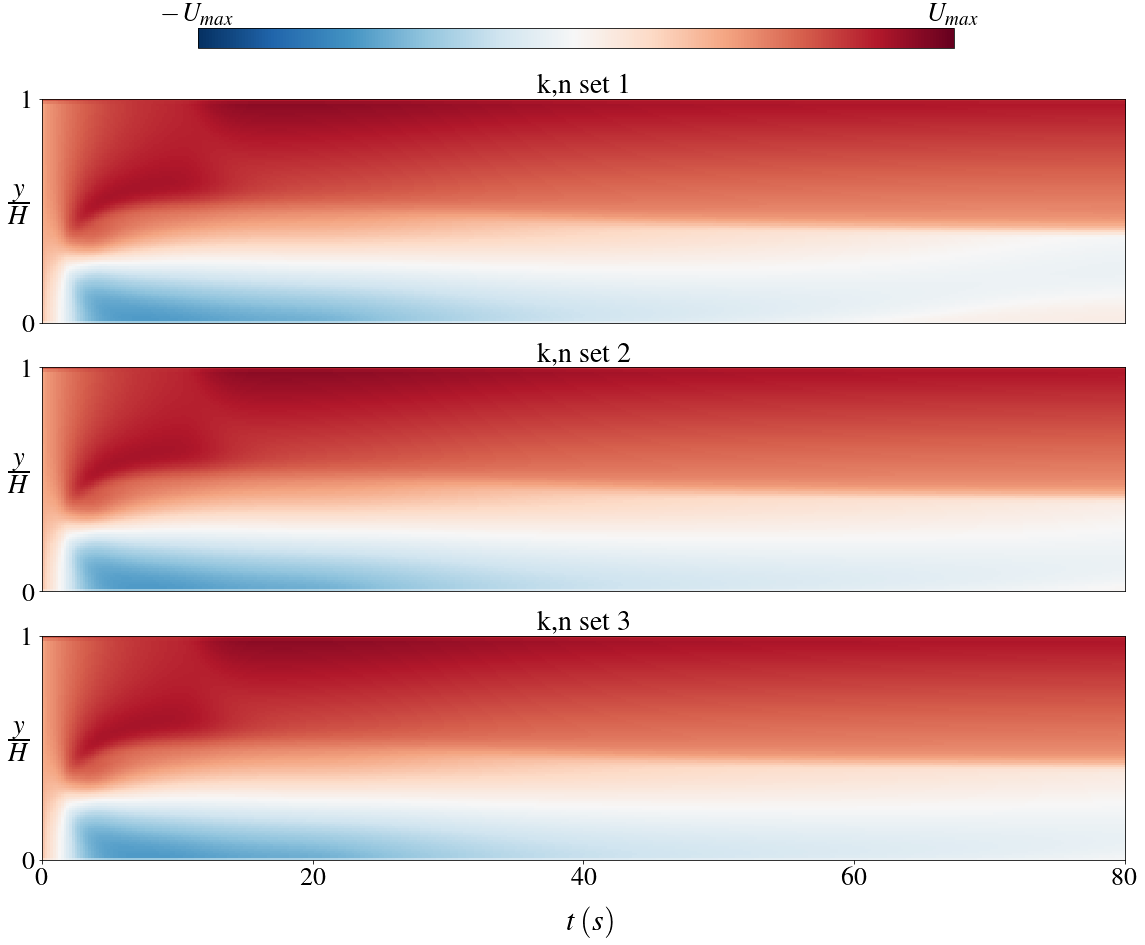

In [510]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
kn = [1,2,3]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = k+1
    #file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    file_name = "Carreau_U05E6H4_kn{0:d}_temporal.npy".format(k+1)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:400]
    Uy = Uy[:400]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Ux),extent=[0,80,0,1], cmap='RdBu_r',vmin=-0.7, vmax=0.7,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('k,n set {0:d}'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-\,U_{max}$','$\,U_{max}$']):
    cbar.ax.text(-0.7+j*1.4,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/NN_C_U05E6H4_kns_Ux_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

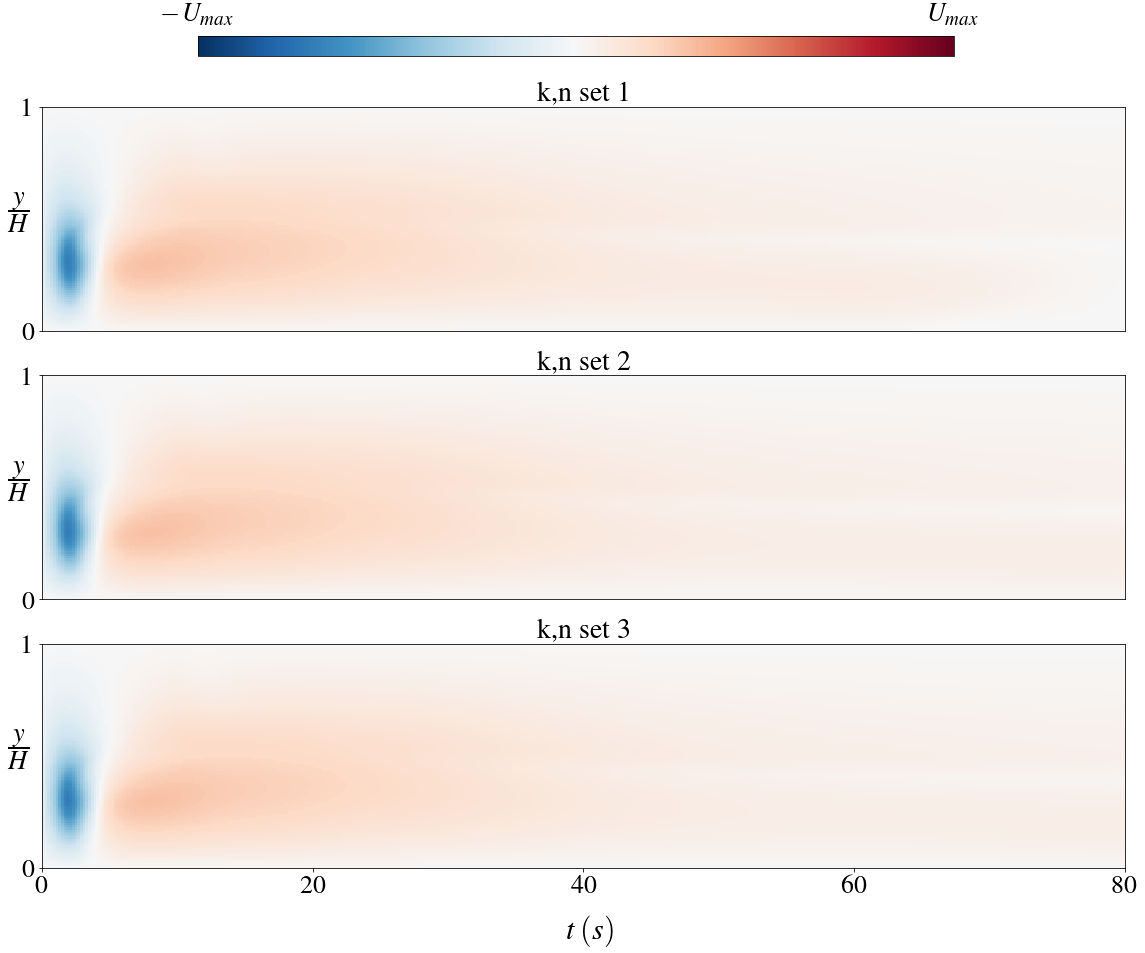

In [509]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = 3
Cols = 1
kn = [1,2,3]
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(14,14))
fig.subplots_adjust(wspace=0)
for kk in range(Tot):
    #k = -1-kk
    k = kk
    j = k+1
    #file_name = "U05E6H4_{:d}_temporal.npy".format(j)
    file_name = "Carreau_U05E6H4_kn{0:d}_temporal.npy".format(k+1)
    b = np.load(file_name)
    Ux = b[:,:,0]
    Uy = b[:,:,1]
    Ux = Ux[:400]
    Uy = Uy[:400]
    U = np.sqrt(Ux**2+Uy**2)
    ax = fig.add_subplot(Rows,Cols,Position[k])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
    #if k!=2:
    #    ax.xaxis.set_visible(False)
    im = ax.imshow(np.transpose(Uy),extent=[0,80,0,1], cmap='RdBu_r',vmin=-0.5, vmax=0.5,origin='lowest', aspect='auto')
    #if not k%2:
    #ax.yaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([0,1])
    ax.set_ylabel('$\\frac{y}{H}$',fontsize = 36,rotation='horizontal',ha='center',va='center')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

    ax.set_title('k,n set {0:d}'.format(j),fontsize = 28)
    if k==2:
        ax.set_xticks([])
        ax.set_xticks(list(np.linspace(0,80,5)))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(26)
    else:
        ax.xaxis.set_visible(False)

axx = fig.gca()
fig.text(0.67, 0.055, '$t\,(s)$', ha='center',fontsize=30)

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.28, 0.93, 0.75, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['$-\,U_{max}$','$\,U_{max}$']):
    cbar.ax.text(-0.5+j,1.4, lab, ha='center', va='center',fontsize=26)

plt.show()

fig.savefig('%s/NN_C_U05E6H4_kns_Uy_temporal.pdf'%figPath, bbox_inches = 'tight', orientation='landscape',dpi=fig.dpi)

In [512]:
file_name = "Carreau_U05E6H4_kn1_temporal.npy"
b = np.load(file_name)
b

array([[[ 1.27800000e-01, -2.71640000e-03,  3.53671599e-01],
        [ 1.80980000e-01, -5.57010000e-03,  4.18819651e-01],
        [ 1.81650000e-01, -8.44660000e-03,  4.16177126e-01],
        ...,
        [ 2.82420000e-01, -1.58870000e-03,  5.29935185e-01],
        [ 3.34110000e-01, -1.05780000e-03,  5.77106749e-01],
        [ 4.17050000e-01, -5.28900000e-04,  6.45384459e-01]],

       [[ 1.02800000e-01, -3.72430000e-03,  3.14762927e-01],
        [ 1.48010000e-01, -7.68650000e-03,  3.74597784e-01],
        [ 1.48830000e-01, -1.17570000e-02,  3.70233710e-01],
        ...,
        [ 2.97110000e-01, -2.33870000e-03,  5.42928448e-01],
        [ 3.43390000e-01, -1.55630000e-03,  5.84665460e-01],
        [ 4.21690000e-01, -7.78140000e-04,  6.48777204e-01]],

       [[ 8.12460000e-02, -4.67150000e-03,  2.76720979e-01],
        [ 1.20120000e-01, -9.49900000e-03,  3.32597354e-01],
        [ 1.21010000e-01, -1.44440000e-02,  3.26444482e-01],
        ...,
        [ 3.09840000e-01, -2.92630000e-03,

In [511]:
b

array([[[ 1.31060000e-01, -2.64750000e-03,  3.58346899e-01],
        [ 1.83810000e-01, -5.40390000e-03,  4.22381463e-01],
        [ 1.84340000e-01, -8.16290000e-03,  4.19734559e-01],
        ...,
        [ 2.81220000e-01, -1.48770000e-03,  5.28897249e-01],
        [ 3.34170000e-01, -9.90750000e-04,  5.77216814e-01],
        [ 4.17090000e-01, -4.95380000e-04,  6.45441415e-01]],

       [[ 1.03480000e-01, -3.78230000e-03,  3.15749426e-01],
        [ 1.47550000e-01, -7.81330000e-03,  3.73813724e-01],
        [ 1.48220000e-01, -1.19320000e-02,  3.69172047e-01],
        ...,
        [ 2.96600000e-01, -2.29870000e-03,  5.42495438e-01],
        [ 3.43950000e-01, -1.53000000e-03,  5.85166643e-01],
        [ 4.21970000e-01, -7.64980000e-04,  6.49003097e-01]],

       [[ 8.06490000e-02, -4.76160000e-03,  2.75476678e-01],
        [ 1.18490000e-01, -9.69380000e-03,  3.29842690e-01],
        [ 1.19200000e-01, -1.47440000e-02,  3.23196535e-01],
        ...,
        [ 3.09760000e-01, -2.91670000e-03,